In [44]:
# -*- coding: utf-8 -*-
"""
mainDMRG_MPO.py
---------------------------------------------------------------------
Script file for initializing the Hamiltonian of a 1D spin chain as an MPO \
before passing to the DMRG routine.

    by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
"""

#### Preamble
import numpy as np
from scipy import linalg as LA
import matplotlib.pyplot as plt
#import plotly.graph_objects as go

from ncon_jax import ncon
#from tensornetwork.ncon_interface import ncon
from doDMRG_MPO_comm_real2_jax import doDMRG_MPO

import tensornetwork as tn
import math
from numpy import *
import jax

%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [45]:
def createMPS(num):    
    c=[]
    for i in range(N):
        c.append(tn.Node(num[i]))
    for i in range(N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [46]:
def conjMPS(mps):
    c=[]
    for i in range(N):
        c.append(tn.conj(mps[i]))
    for i in range(1,N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [47]:
def rightcollapsePsiPsi(mps1,mps2,l):
    node = mps1[N-1] @ mps2[N-1]
    for i in range(N-2,l-1,-1):
        node = mps1[i] @ node
        node = node @ mps2[i]
    return node.tensor

In [48]:
def getrhoin(num,k):
    mps2 = createMPS(num)
    mps1 = conjMPS(mps2)
    for i in range(N):
        mps1[i][1] ^ mps2[i][1]
    tensor4 = rightcollapsePsiPsi(mps1,mps2,k+1)
    if k==N-2:
        matrix = tensor4[:,0,:,0]
    else:
        matrix = tensor4[:,0,0,:]
    return matrix

In [49]:
def calcEntrdiag(rhoin):
    diagrhoin = np.diag(np.diag(rhoin))
    lndiagrhoin = LA.logm(diagrhoin)
    entr = -np.trace(np.dot(diagrhoin,lndiagrhoin))
    return entr

In [50]:
def calcEntrsing(rhoin):
    u,s,vh = LA.svd(rhoin, full_matrices=False)
    smatrix = np.diag(s)
    lnsmatrix = LA.logm(smatrix)
    entr = -np.trace(np.dot(smatrix,lnsmatrix))
    return entr

In [51]:
def ground_state():
    #print('h =',h)
    global chi
    
    #### Define Hamiltonian MPO (quantum XX model)
    global chid
    chid = 4
    sX = np.array([[0, 1], [1, 0]])
    sZ = np.array([[1, 0], [0,-1]])
    sI = np.array([[1, 0], [0, 1]])
    MH = np.zeros([3,3,2,2]);
    MH[0,0,:,:] = sI
    MH[1,0,:,:] = sZ
    MH[2,0,:,:] = h*sZ + g*sX
    MH[2,1,:,:] = -sZ
    MH[2,2,:,:] = sI

    MLH = np.array([0,0,1]).reshape(3,1,1) #left MPO boundary
    MRH = np.array([1,0,0]).reshape(3,1,1) #right MPO boundary
    
    x = MLH.shape[0]
    
    c=[]
    MLarr=[]
    MRarr=[]
    Marr=[]
    
    MM1 = ncon([MH,MH],[[-1,-3,-8,-6],[-2,-4,-5,-7]]).reshape(x**2,x**2,chid,chid)
    ML1 = ncon([MLH[:,0,0],MLH[:,0,0]],[[-1],[-2]]).reshape(x**2,1,1)
    MR1 = ncon([MRH[:,0,0],MRH[:,0,0]],[[-1],[-2]]).reshape(x**2,1,1)
    MLarr.append(ML1)
    MRarr.append(MR1)
    c.append(-2)
    
    M1=[]
    for i in range(N):
        M1.append(MM1)
    Marr.append(M1)
    
    iden = np.eye(2)
    
    MLarr.append(ML1)
    MRarr.append(MR1)
    MM2 = ncon([MH,MH,iden],[[-1,-3,-8,1],[-2,-4,1,-6],[-5,-7]]).reshape(x**2,x**2,chid,chid)
    c.append(1)
    
    M2=[]
    for i in range(N):
        M2.append(MM2)
    Marr.append(M2)
    
    MLarr.append(ML1)
    MRarr.append(MR1)
    MM3 = ncon([MH,MH,iden],[[-1,-3,-5,1],[-2,-4,1,-7],[-6,-8]]).reshape(x**2,x**2,chid,chid)
    c.append(1)
    
    M3=[]
    for i in range(N):
        M3.append(MM3) 
    Marr.append(M3)
    
    sigmaz = np.zeros((1,1,2,2))
    sigmaz[0,0,:,:] = sZ
    
    ML4 = np.ones((1,1,1))
    MR4 = np.ones((1,1,1))
    MLarr.append(ML4)
    MRarr.append(MR4)
    Mbulk4 = np.zeros((1,1,4,4))
    Mbulk4[0,0,:,:] = np.eye(4)
    MM4 = ncon([sigmaz,sigmaz],[[-1,-3,-8,-6],[-2,-4,-5,-7]]).reshape(1,1,chid,chid)
    c.append(-2)
    
    M4=[]
    for i in range(N-1):
        M4.append(Mbulk4)
    M4.append(MM4)
    Marr.append(M4)
    
    MLarr.append(ML4)
    MRarr.append(MR4)
    Mbulk5 = Mbulk4
    MM5 = ncon([sigmaz,sigmaz,iden],[[-1,-3,-8,1],[-2,-4,1,-6],[-5,-7]]).reshape(1,1,chid,chid)
    c.append(1)
    
    M5=[]
    for i in range(N-1):
        M5.append(Mbulk5)
    M5.append(MM5)
    Marr.append(M5)
    
    MLarr.append(ML4)
    MRarr.append(MR4)
    Mbulk6 = Mbulk4
    MM6 = ncon([sigmaz,sigmaz,iden],[[-1,-3,-5,1],[-2,-4,1,-7],[-6,-8]]).reshape(1,1,chid,chid)
    c.append(1)
    
    M6=[]
    for i in range(N-1):
        M6.append(Mbulk6)
    M6.append(MM6)
    Marr.append(M6)
    
    
    
    Mbulk7 = ncon([iden,iden],[[-1,-2],[-3,-4]]).reshape(1,1,chid,chid)
    MLarr.append(ML4)
    MRarr.append(MR4)
    c.append(100)
    
    M7=[]
    for i in range(N):
        M7.append(Mbulk7)
    Marr.append(M7)
    
    
    
    
    
    
    
    chi = 4
    
    #### Initialize MPS tensors
    A = [0 for x in range(N)]
    A[0] = np.random.rand(1,chid,min(chi,chid))
    for k in range(1,N):
        A[k] = np.random.rand(A[k-1].shape[2],chid,min(min(chi,A[k-1].shape[2]*chid),chid**(N-k-1)))
    
    En=[]
    
    
    for i in range(5):
        #### Do DMRG sweeps (2-site approach)
        Enn, A, sWeight, B = doDMRG_MPO(A,MLarr,Marr,MRarr,c,chi, numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)
        #print('Bond dimension: ', chi)
        print('Minimal value of the functional: ', np.real(Enn[len(Enn)-1]))
        #print(Enn)
        print()
        En.append(Enn)
        '''
        for i in range(N-1):
            tens1 = A[i]
            tens2 = A[i+1]
            matr1 = tens1.reshape((tens1.shape[0]*tens1.shape[1],tens1.shape[2]))
            matr2 = tens2.reshape((tens2.shape[0],tens2.shape[1]*tens2.shape[2]))
            m = matr1 @ matr2
            node = tn.Node(m)
            u, s, vh, truncated_singular_values = tn.split_node_full_svd(node, left_edges=[node[0]], right_edges=[node[1]], max_singular_values=4)
            print('i =',i)
            print('u =',u.tensor)
            print('s =',s.tensor)
            print('vh =',vh.tensor)
            print('truncated_singular_values =',truncated_singular_values)
        '''
        chi *= 2
        #printentrlocdensmatr(A)
        #for j in range(len(sWeight)):
            #print('j=',j)
            #print(np.diag(sWeight[j]))
        printentrlocsvd(sWeight)
    
    
    Enn, A, sWeight, B = doDMRG_MPO(A,MLarr,Marr,MRarr,c,4, numsweeps = 2, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)
    print('Minimal value of the functional: ', np.real(Enn[len(Enn)-1]))
    En.append(Enn)
    
    printentrlocsvd(sWeight)
    #for i in range(N):
        #print(A[i].shape)
    #print("*")
    #for i in range(N):
        #print(B[i].shape)
    
    #print('A=')
    #print(A)
    
    return (En[len(En)-1][len(En[len(En)-1])-1],A)

In [52]:
def printentrhdensmatr():
    global h
    print()
    print('Entanglement entropy for the central position for different values of h:')

    entr = []
    for it in range(11):
        h = it/10
        m = ground_state()
        rhoin=getrhoin(m,N//2)
        entr.append(calcEntrdiag(rhoin))
        print('h =',h,':',entr[it])
    
    arange = linspace(0, 1, 11)

    f = plt.figure(figsize=(18, 10))
    plt.plot(arange, entr, 'bs')
    #plt.legend()
    plt.xlabel("h", fontsize=20)
    plt.ylabel("Entanglement entropy for the central position", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()
    
    #printEntr(A)

In [53]:
def printentrlocdensmatr(m):
    global h
    #h=0
    #m=ground_state()
    entrloc = []
    #print('h =',h)
    #print('g =',g)
    print('Entanglement entropy for different positions:')
    for i in range(N-1):
        rhoin=getrhoin(m,i)
        entrloc.append(calcEntrdiag(rhoin))
        print('Position = ', i,': ',entrloc[i])
    
    t = np.arange(N-1)
    #func = 1/(11.5)*np.log(np.sin(np.pi*(t+1)/N))+0.584
    #print(arange)

    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, entrloc, 'bs', label="Entaglement entropy")
    #plt.plot(t, func, 'r', label="1/11.5 log(sin(pi*(t+1)/N)) + 0.584")
    #plt.legend()
    plt.xlabel("Position", fontsize=20)
    plt.ylabel("Entanglement entropy", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()

In [54]:
def printentrlocsvd(sWeight):
    global h
    #h=0
    #m=ground_state()
    entrloc = []
    #print('h =',h)
    #print('g =',g)
    print('Entanglement entropy for different positions:')
    print()
    for i in range(1,N):
        #matr = m[i].reshape(m[i].shape[0]*m[i].shape[1],m[i].shape[2])
        #u,s,vh = LA.svd(matr,full_matrices=False)
        s = np.diag(sWeight[i])
        summ = 0
        for j in range(len(s)):
            mod2 = s[j]*np.conj(s[j])
            summ -= mod2 * np.log(mod2)
        entrloc.append(summ)
        print('Position = ', i-1,': ',entrloc[i-1])
        print()
        for j in range(len(s)):
            print('Lambda_i =',s[j])
        tt = np.arange(len(s))
        fff = plt.figure(figsize=(18, 10))
        plt.plot(tt, s, 'bs', label="Lambda_i")
        plt.xlabel("i", fontsize=20)
        plt.ylabel("Lambda_i", fontsize=20)
        plt.axis('tight')
        plt.show()
    
    t = np.arange(N-1)
    #func = 1/(11.5)*np.log(np.sin(np.pi*(t+1)/N))+0.584
    #print(arange)

    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, entrloc, 'rs', label="Entaglement entropy")
    #plt.plot(t, func, 'r', label="1/11.5 log(sin(pi*(t+1)/N)) + 0.584")
    #plt.legend()
    plt.xlabel("Position", fontsize=20)
    plt.ylabel("Entanglement entropy", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()

In [55]:
def CalculateEnergy():
    global h
    global g
    global N
    g=1.05
    print('g =',g)
    print('h =',h)
    print()
    E=[]
    for N in range(14,15):
        print('The length of the Ising spin chain N =',N)
        Ecur, A = ground_state()
        print('Mininimal value of the functional')
        print(np.around(np.real(Ecur),decimals=acc))
        print()
        E.append(np.around(np.real(Ecur),decimals=acc))
        
        
        
    """
    t=np.arange(8,9)
    
    #fig = go.Figure(data=[go.Table(header=dict(values=['h', 'Energy']),
                 #cells=dict(values=[t, E]))
                     #])
    #fig.show()
    
    
    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, E, 'bs')
    plt.legend()
    plt.xlabel("The length of the Ising spin chain N", fontsize=20)
    plt.ylabel("Mininimal value of the functional", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()
    """

In [56]:
tn.set_default_backend("jax")

H = - ZZ + hZ + gX
g = 1.05
h = 0.1

The length of the Ising spin chain N = 14
Sweep: 1 of 50, Energy: 0.654403, Bond dim: 4
Sweep: 2 of 50, Energy: 0.391577, Bond dim: 4
Sweep: 3 of 50, Energy: 0.277739, Bond dim: 4
Sweep: 4 of 50, Energy: 0.214770, Bond dim: 4
Sweep: 5 of 50, Energy: 0.172489, Bond dim: 4
Sweep: 6 of 50, Energy: 0.143279, Bond dim: 4
Sweep: 7 of 50, Energy: 0.123850, Bond dim: 4
Sweep: 8 of 50, Energy: 0.111152, Bond dim: 4
Sweep: 9 of 50, Energy: 0.099692, Bond dim: 4
Sweep: 10 of 50, Energy: 0.089964, Bond dim: 4
Sweep: 11 of 50, Energy: 0.082235, Bond dim: 4
Sweep: 12 of 50, Energy: 0.075739, Bond dim: 4
Sweep: 13 of 50, Energy: 0.069884, Bond dim: 4
Sweep: 14 of 50, Energy: 0.064405, Bond dim: 4
Sweep: 15 of 50, Energy: 0.058669, Bond dim: 4
Sweep: 16 of 50, Energy: 0.053456, Bond dim: 4
Sweep: 17 of 50, Energy: 0.049166, Bond dim: 4
Sweep: 18 of 50, Energy: 0.045876, Bond dim: 4
Sweep: 19 of 50, Energy: 0.043274, Bond dim: 4
Sweep: 20 of 50, Energy: 0.041138, Bo

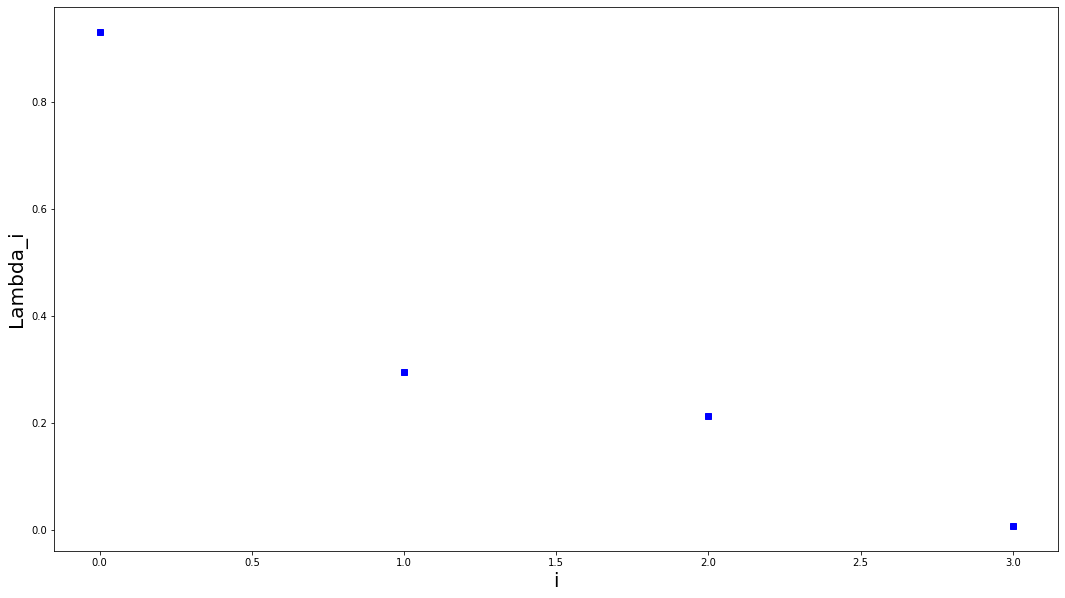

Position =  1 :  0.6351206696841758

Lambda_i = 0.8944764040432851
Lambda_i = 0.3458378880238426
Lambda_i = 0.28335720166600925
Lambda_i = 0.004100497654003143


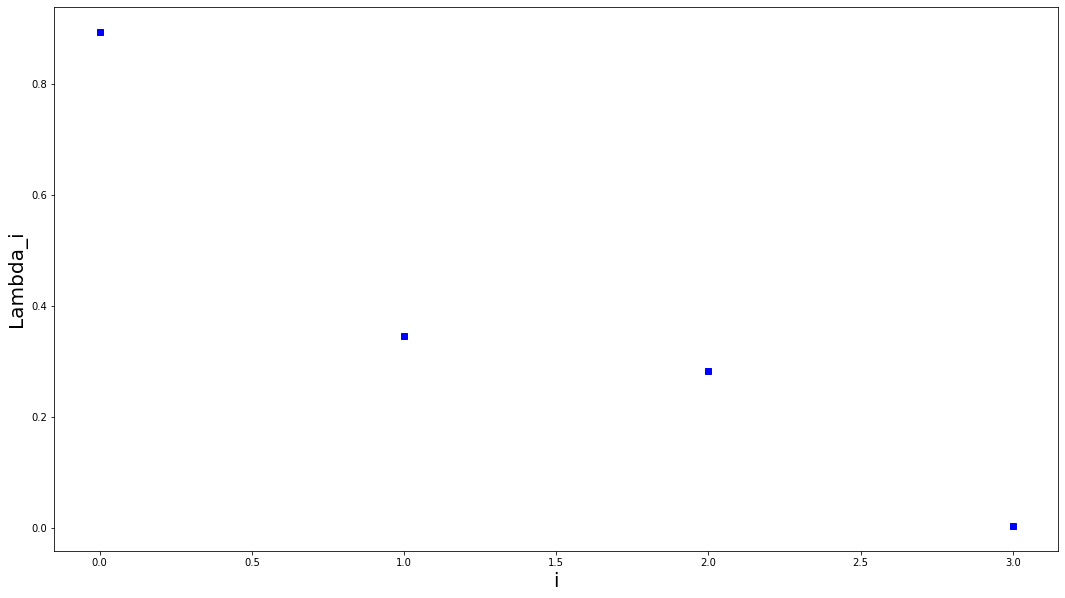

Position =  2 :  0.7222948918259741

Lambda_i = 0.8654199854335427
Lambda_i = 0.41199882133743637
Lambda_i = 0.2849798290077026
Lambda_i = 0.009576903858278344


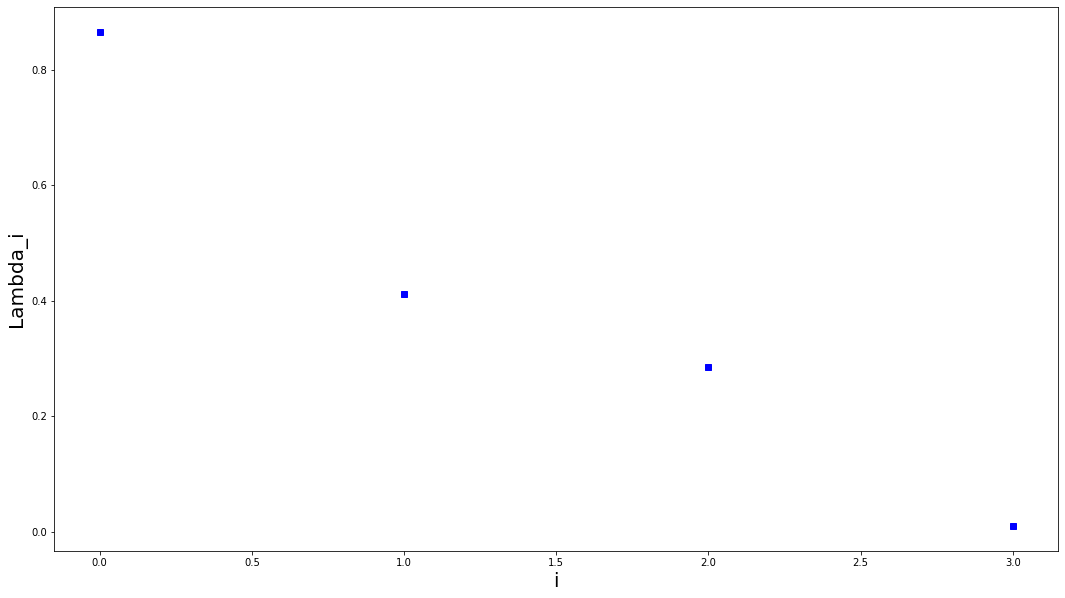

Position =  3 :  0.7448501541107414

Lambda_i = 0.8551125256934595
Lambda_i = 0.43721250004307327
Lambda_i = 0.2783024381007713
Lambda_i = 0.013249571895146415


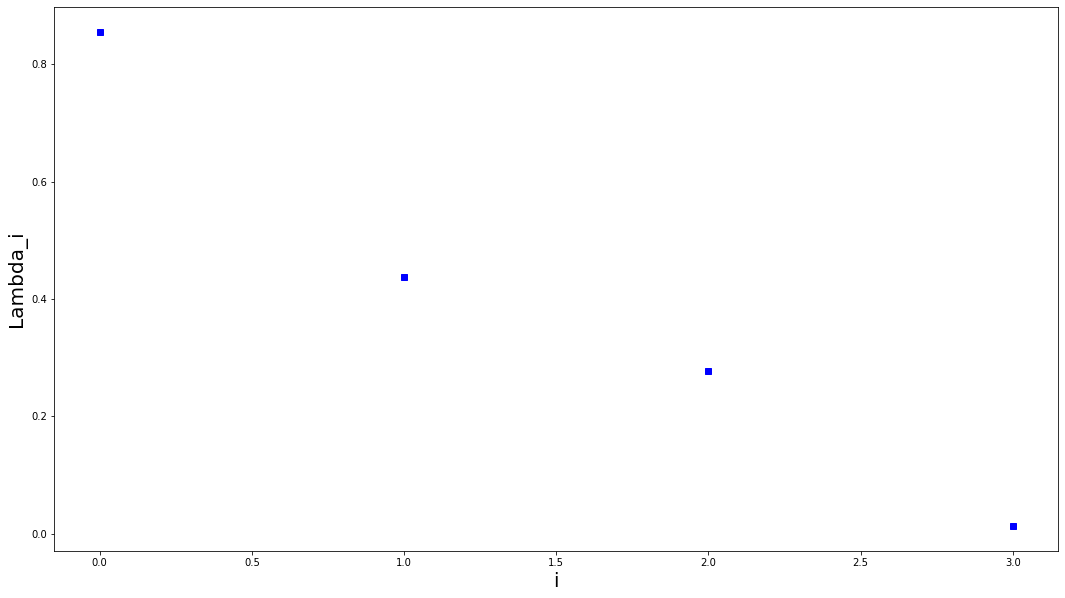

Position =  4 :  0.7186221870201095

Lambda_i = 0.8639870957890297
Lambda_i = 0.4266211483649315
Lambda_i = 0.26698149297881973
Lambda_i = 0.015542730925606218


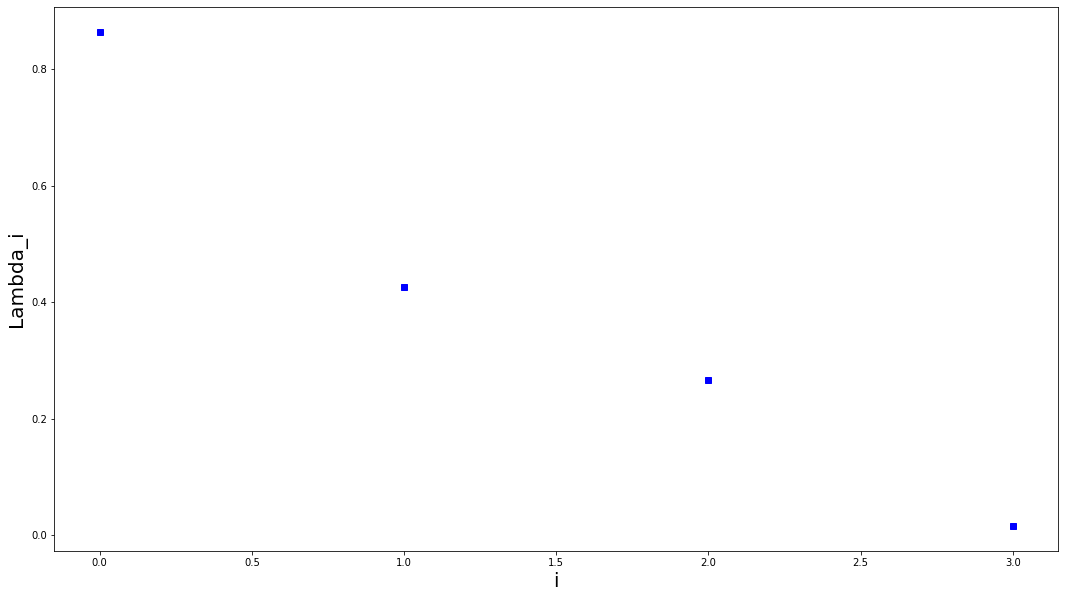

Position =  5 :  0.6543209320004691

Lambda_i = 0.8854542889157296
Lambda_i = 0.39054654587905197
Lambda_i = 0.2513264931285435
Lambda_i = 0.016706034669824125


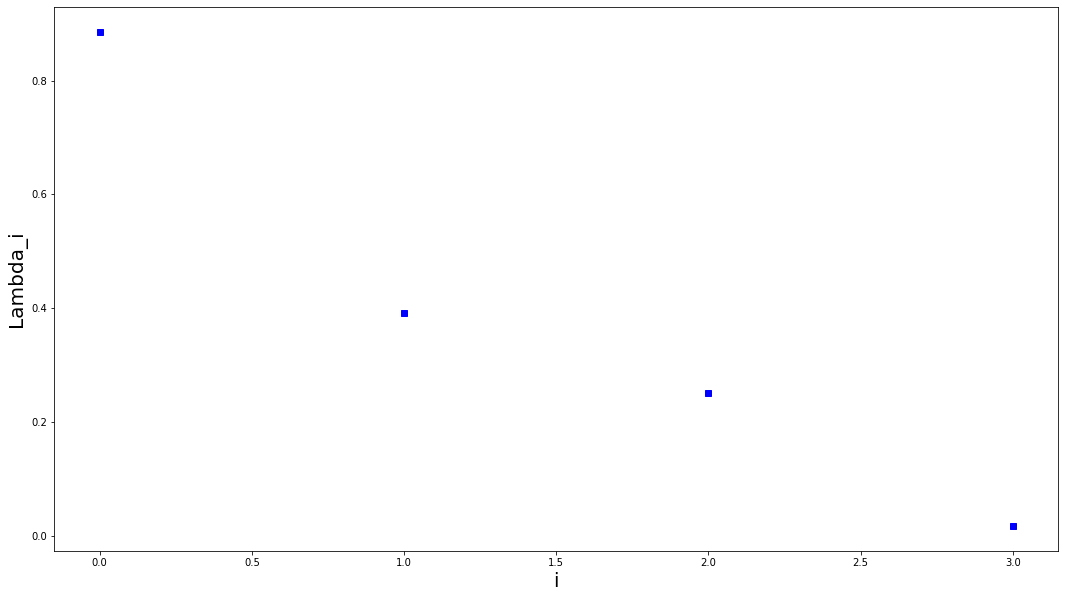

Position =  6 :  0.5620730838012403

Lambda_i = 0.9115429166056853
Lambda_i = 0.3394030999647207
Lambda_i = 0.23153026838121446
Lambda_i = 0.016993579483483606


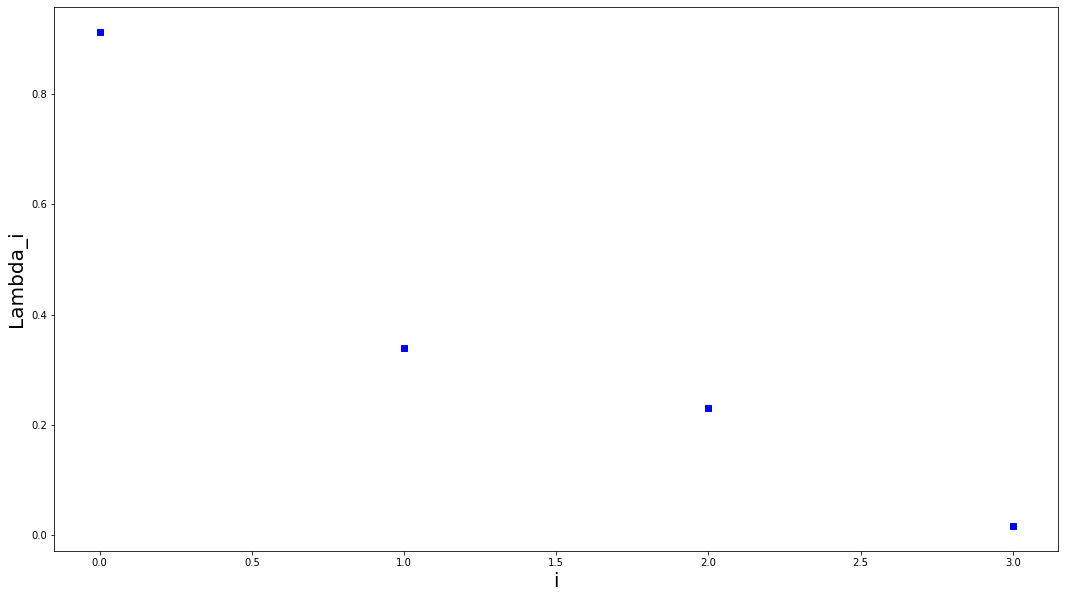

Position =  7 :  0.45206728756677106

Lambda_i = 0.9369912285536417
Lambda_i = 0.28044038943356114
Lambda_i = 0.20767547053916938
Lambda_i = 0.016478001220545265


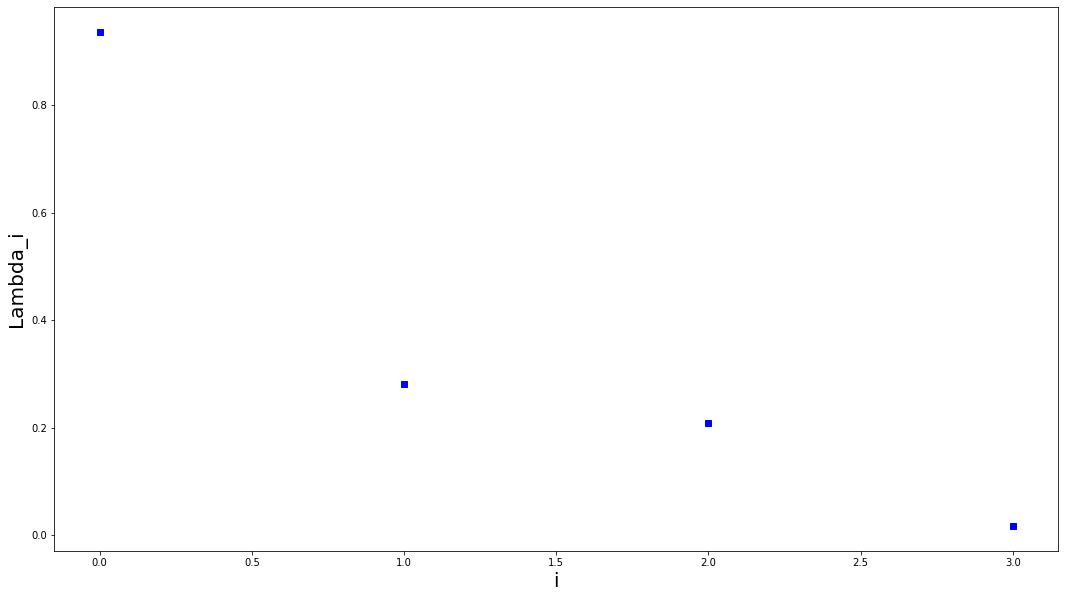

Position =  8 :  0.33505071785498586

Lambda_i = 0.9590131745739487
Lambda_i = 0.21854791951745575
Lambda_i = 0.17972645408728796
Lambda_i = 0.015130749135405235


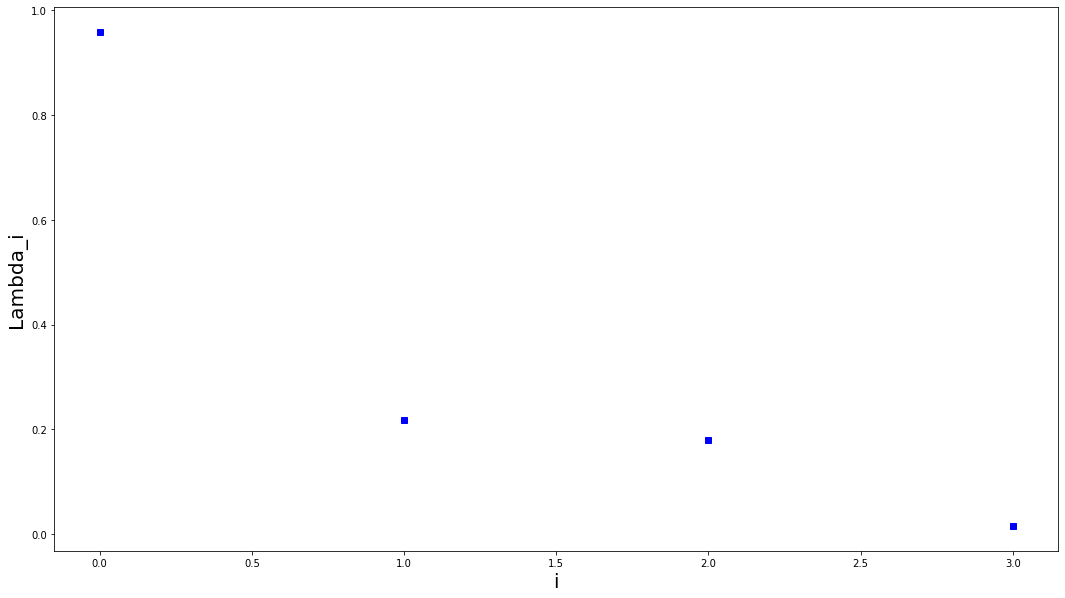

Position =  9 :  0.2223917321925067

Lambda_i = 0.9763050606460313
Lambda_i = 0.15827110996075638
Lambda_i = 0.14701007935480193
Lambda_i = 0.012912043867419332


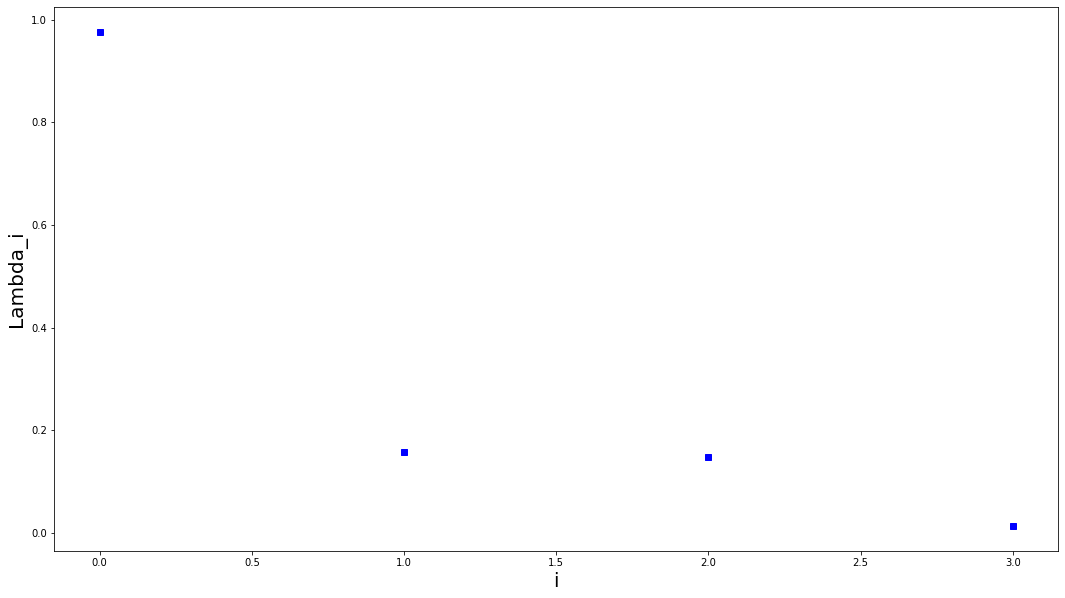

Position =  10 :  0.12535219503818115

Lambda_i = 0.9884780845923493
Lambda_i = 0.1144594310575937
Lambda_i = 0.09855250251551972
Lambda_i = 0.009875179519431461


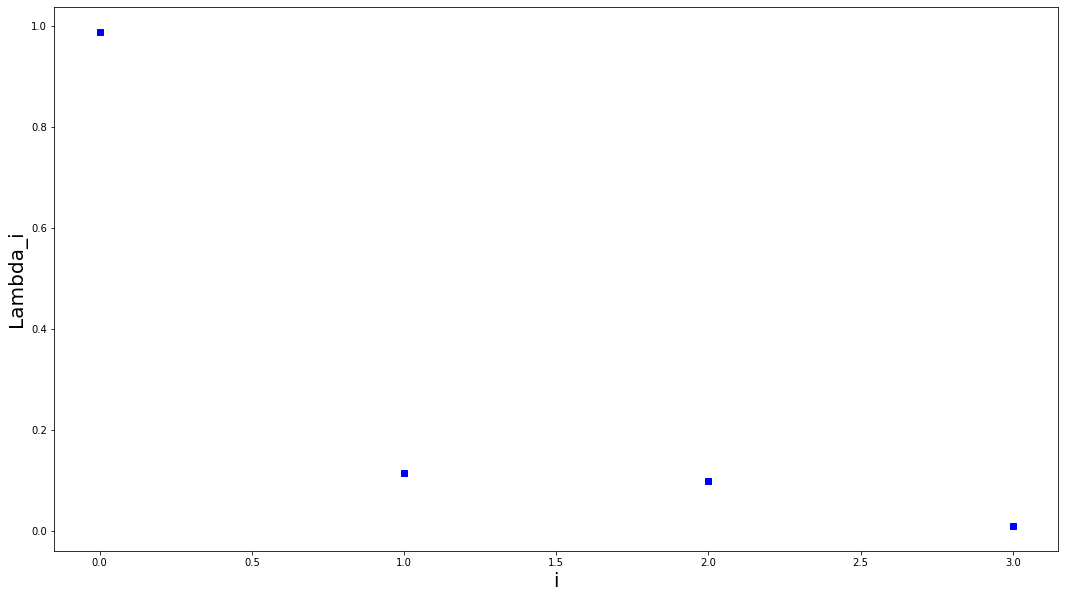

Position =  11 :  0.05341822856894406

Lambda_i = 0.9958302623921431
Lambda_i = 0.07635658357057065
Lambda_i = 0.04953183087580097
Lambda_i = 0.006193414205190331


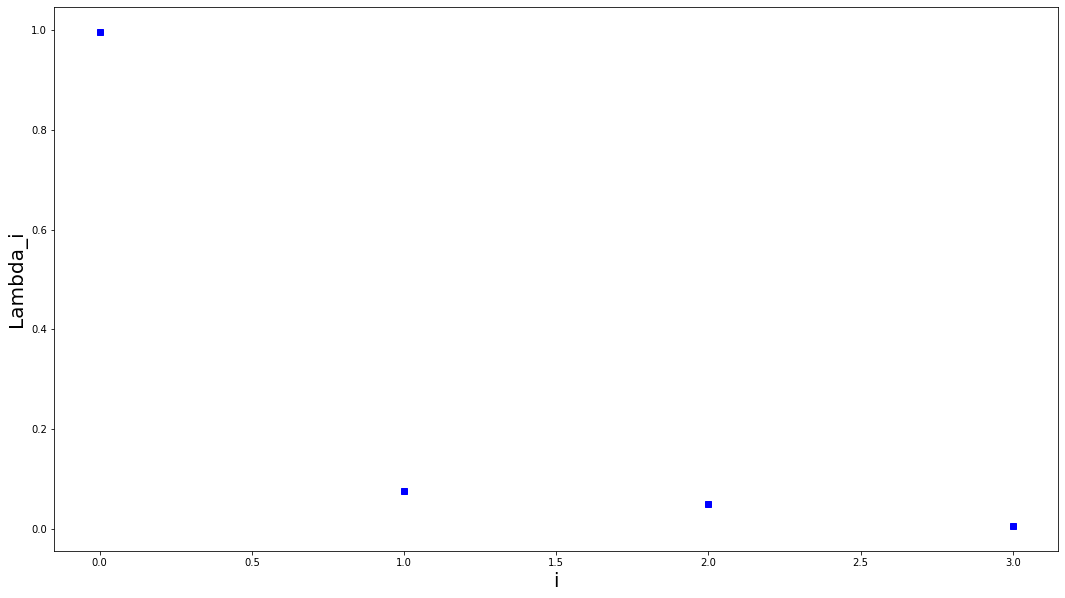

Position =  12 :  0.012040097247637785

Lambda_i = 0.9992310777269494
Lambda_i = 0.03704339072220449
Lambda_i = 0.012656160927650754
Lambda_i = 0.002205016783355196


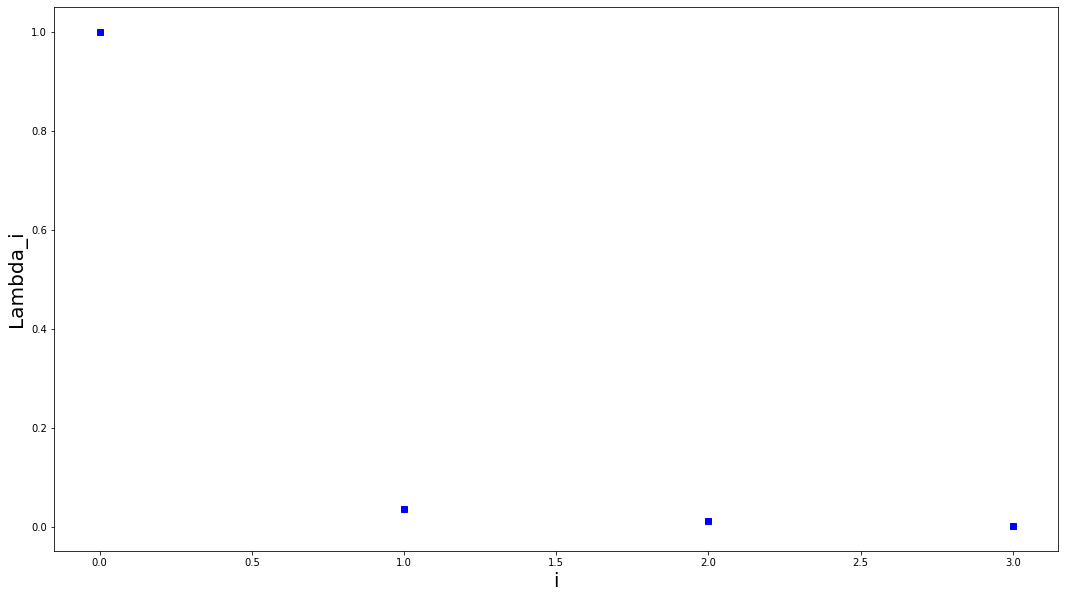

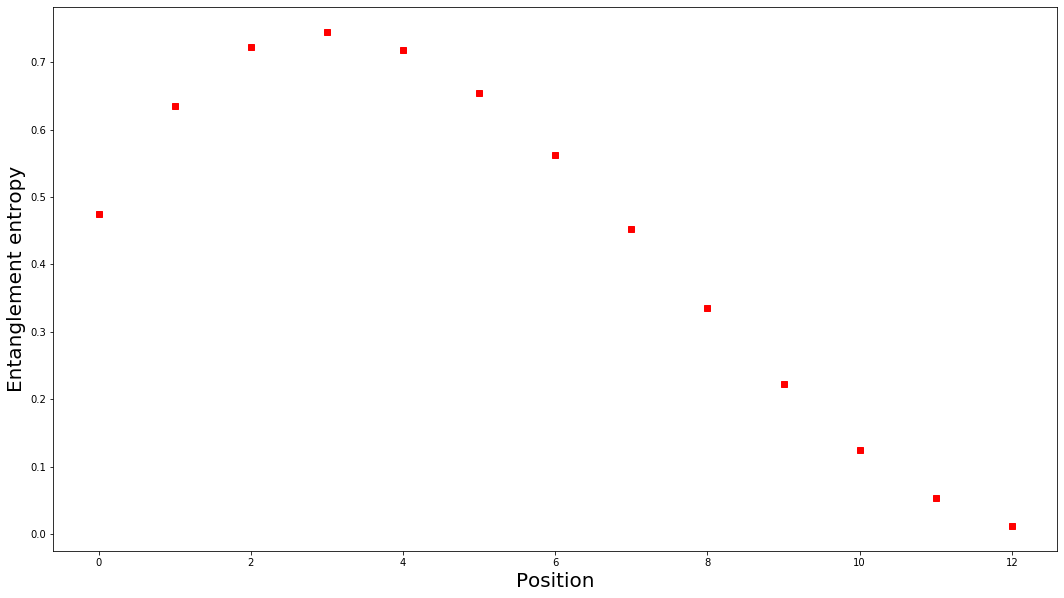

Sweep: 1 of 50, Energy: 0.017799, Bond dim: 8
Sweep: 2 of 50, Energy: 0.017104, Bond dim: 8
Sweep: 3 of 50, Energy: 0.016542, Bond dim: 8
Sweep: 4 of 50, Energy: 0.016076, Bond dim: 8
Sweep: 5 of 50, Energy: 0.015649, Bond dim: 8
Sweep: 6 of 50, Energy: 0.015269, Bond dim: 8
Sweep: 7 of 50, Energy: 0.014923, Bond dim: 8
Sweep: 8 of 50, Energy: 0.014609, Bond dim: 8
Sweep: 9 of 50, Energy: 0.014319, Bond dim: 8
Sweep: 10 of 50, Energy: 0.014055, Bond dim: 8
Sweep: 11 of 50, Energy: 0.013811, Bond dim: 8
Sweep: 12 of 50, Energy: 0.013587, Bond dim: 8
Sweep: 13 of 50, Energy: 0.013378, Bond dim: 8
Sweep: 14 of 50, Energy: 0.013186, Bond dim: 8
Sweep: 15 of 50, Energy: 0.013007, Bond dim: 8
Sweep: 16 of 50, Energy: 0.012840, Bond dim: 8
Sweep: 17 of 50, Energy: 0.012684, Bond dim: 8
Sweep: 18 of 50, Energy: 0.012537, Bond dim: 8
Sweep: 19 of 50, Energy: 0.012399, Bond dim: 8
Sweep: 20 of 50, Energy: 0.012270, Bond dim: 8
Sweep: 21 of 50, Energy: 0.012148, Bond dim: 8
Sweep: 22 of 50, Energ

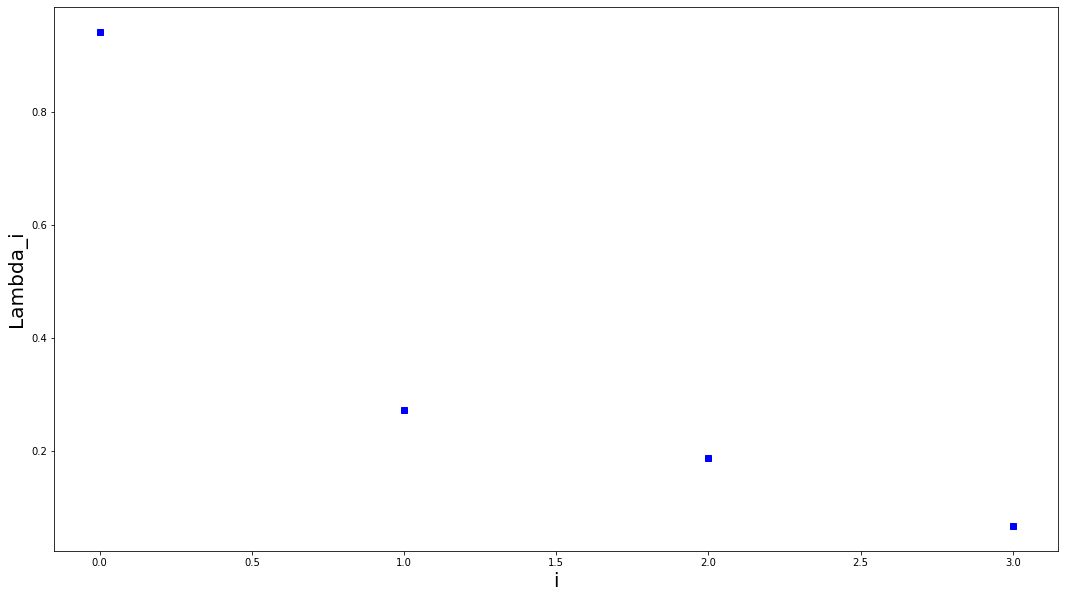

Position =  1 :  0.7372133856936428

Lambda_i = 0.8707295204496058
Lambda_i = 0.3902890048904523
Lambda_i = 0.2880170004629142
Lambda_i = 0.07953509274664479
Lambda_i = 0.010810067473371501
Lambda_i = 0.008245555253666877
Lambda_i = 0.005433251547210679
Lambda_i = 0.003256437125649321


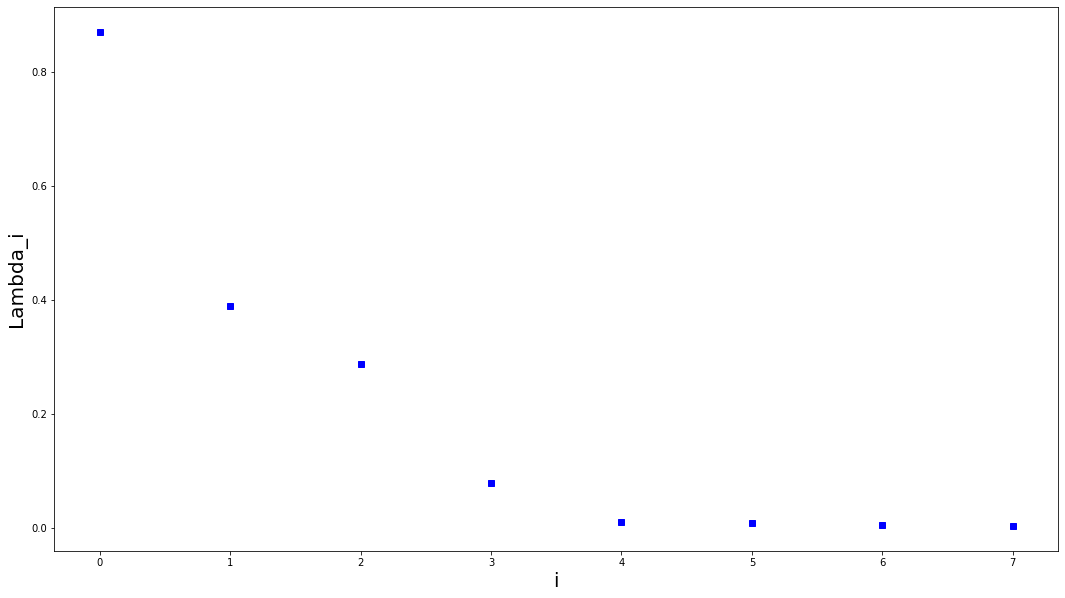

Position =  2 :  0.8593464400960961

Lambda_i = 0.8093882061575213
Lambda_i = 0.5103947851479803
Lambda_i = 0.2797412297889684
Lambda_i = 0.0768146647656262
Lambda_i = 0.011431301951207437
Lambda_i = 0.008053599556256175
Lambda_i = 0.0052012816393283
Lambda_i = 0.0031077643335684973


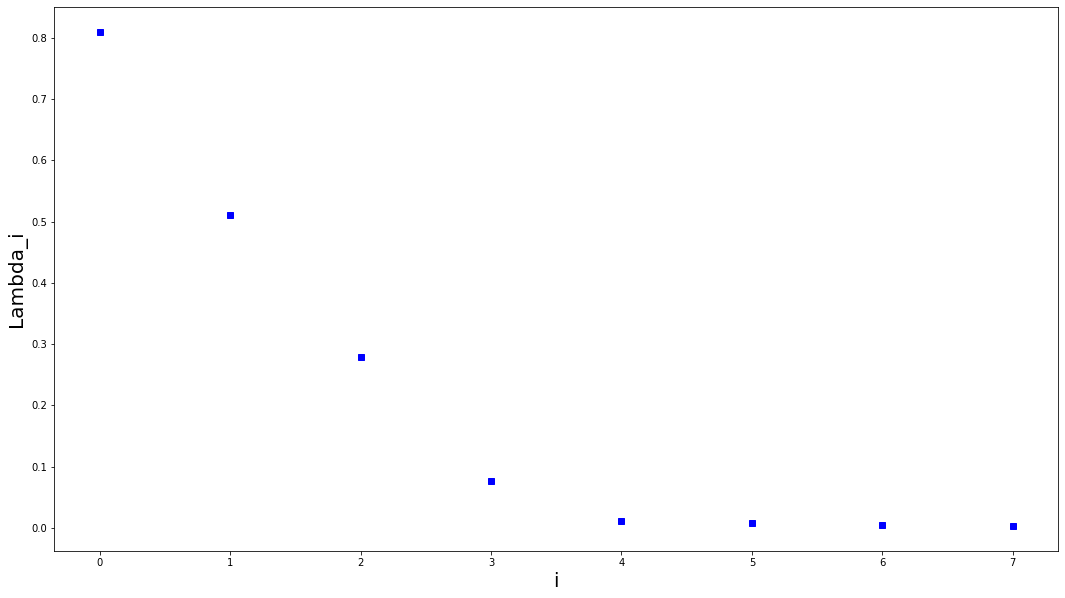

Position =  3 :  0.8844122945994207

Lambda_i = 0.7804213133748276
Lambda_i = 0.5602628680155107
Lambda_i = 0.26738541055895176
Lambda_i = 0.07288991502931766
Lambda_i = 0.01125678714362688
Lambda_i = 0.007803458573235149
Lambda_i = 0.006764046161721314
Lambda_i = 0.0026140615150006155


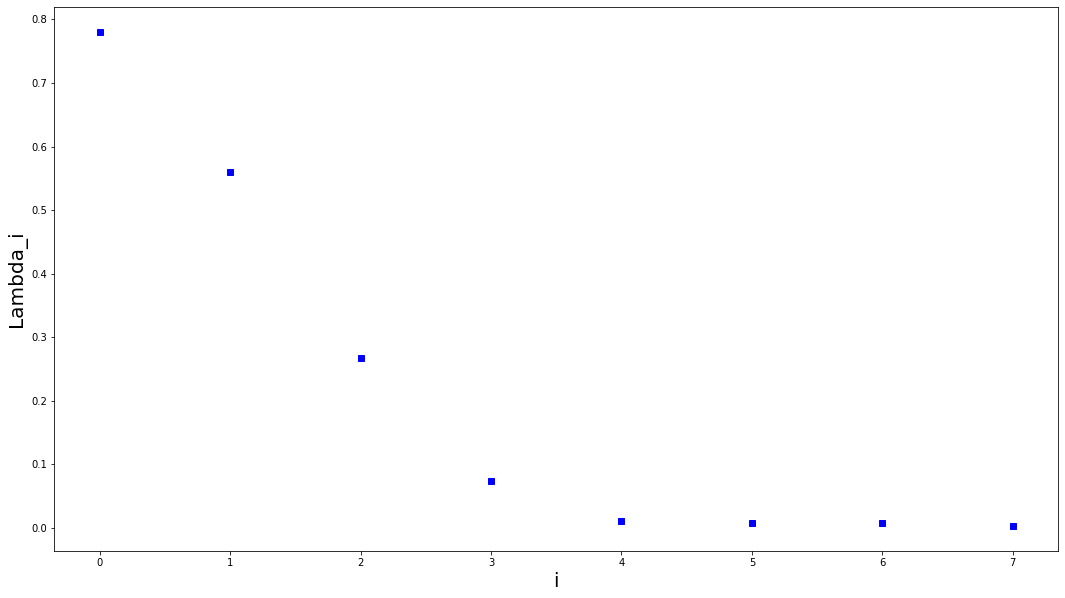

Position =  4 :  0.8428929535480894

Lambda_i = 0.8038425395459833
Lambda_i = 0.5340684367277339
Lambda_i = 0.25226273707808017
Lambda_i = 0.06876874972619633
Lambda_i = 0.010668844131644926
Lambda_i = 0.00852317290610746
Lambda_i = 0.0071324739473248725
Lambda_i = 0.0022596801384628545


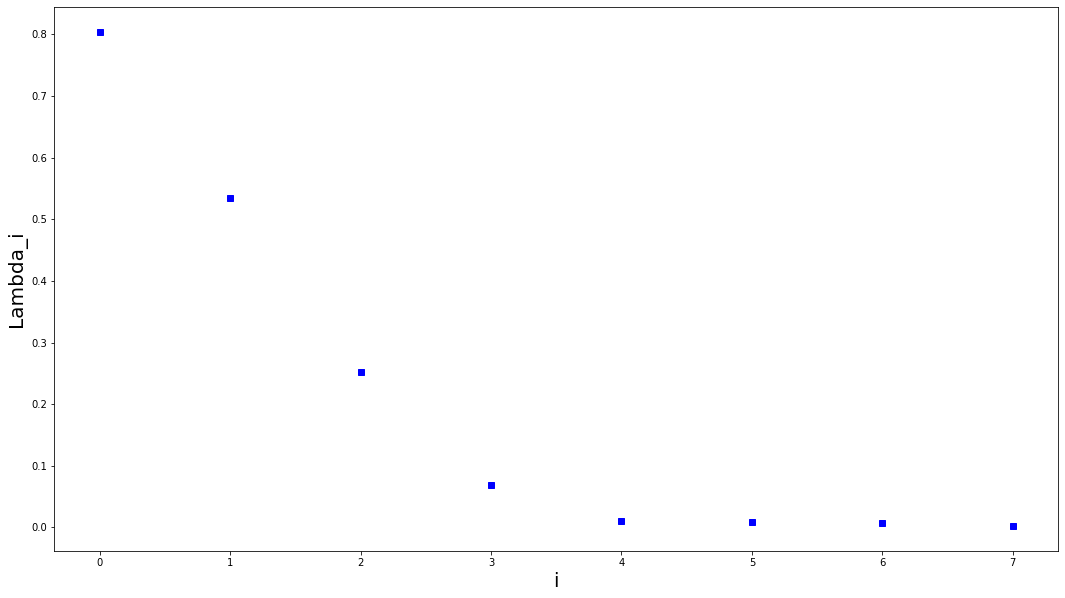

Position =  5 :  0.7529221135333115

Lambda_i = 0.8490033657435666
Lambda_i = 0.46918317689390304
Lambda_i = 0.233936921172825
Lambda_i = 0.06400096100440429
Lambda_i = 0.010254741811338263
Lambda_i = 0.00953831245880766
Lambda_i = 0.006156371503243546
Lambda_i = 0.0019455935514506137


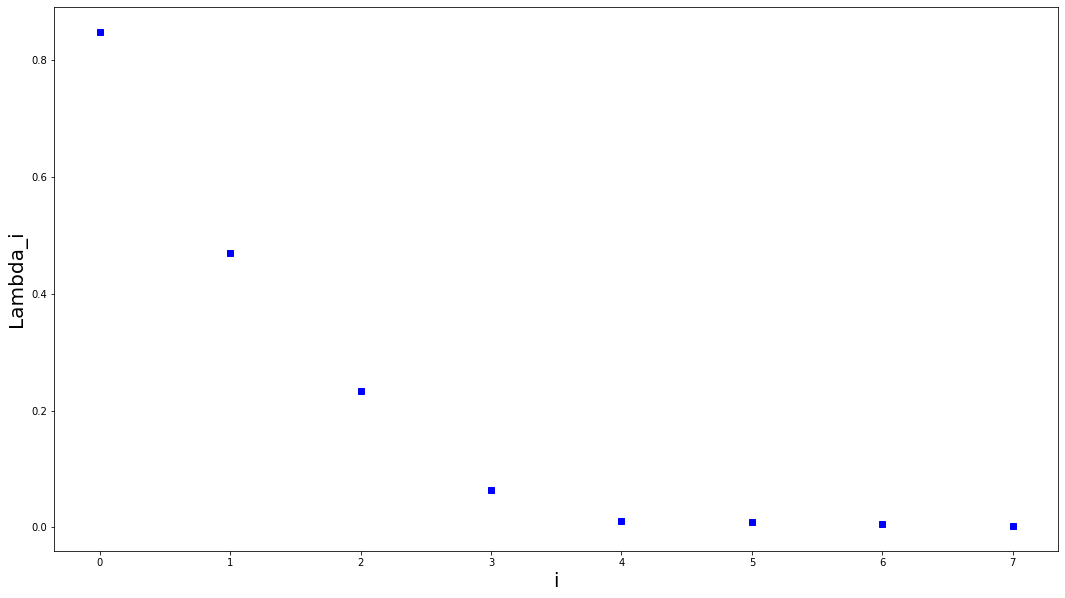

Position =  6 :  0.6303694309185855

Lambda_i = 0.8927378699275487
Lambda_i = 0.3928559426200773
Lambda_i = 0.21226210969797102
Lambda_i = 0.05833198529546251
Lambda_i = 0.011183546641967497
Lambda_i = 0.008517253009384057
Lambda_i = 0.0050264126811060674
Lambda_i = 0.001612477786144535


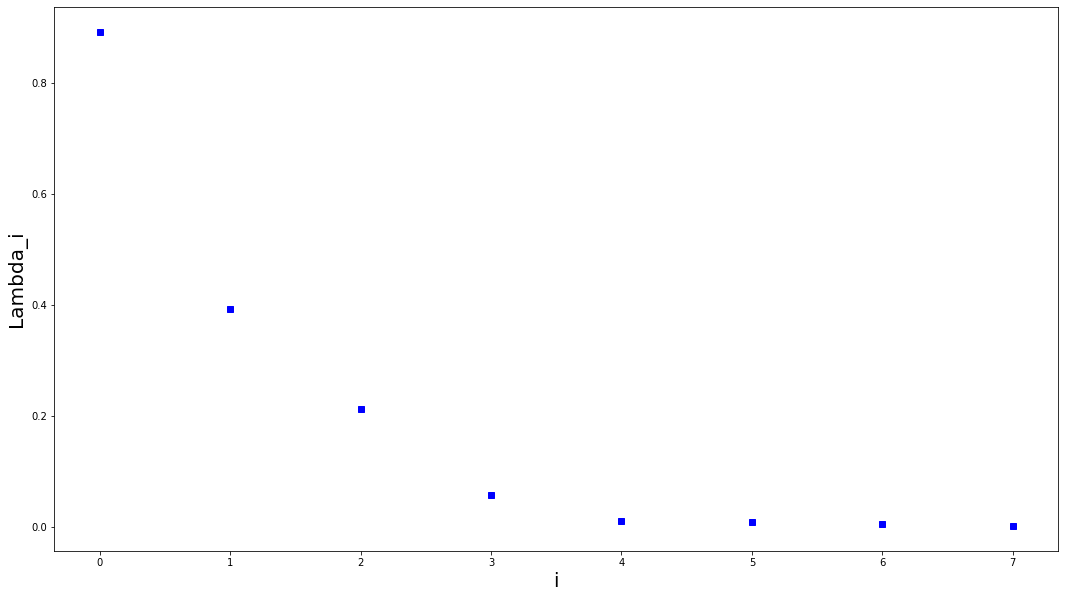

Position =  7 :  0.4906272553229529

Lambda_i = 0.9291565042042347
Lambda_i = 0.3142271962203857
Lambda_i = 0.18726697257219468
Lambda_i = 0.05158382847262845
Lambda_i = 0.011401188386596994
Lambda_i = 0.007229708163293935
Lambda_i = 0.003957759272808841
Lambda_i = 0.0013152334311450366


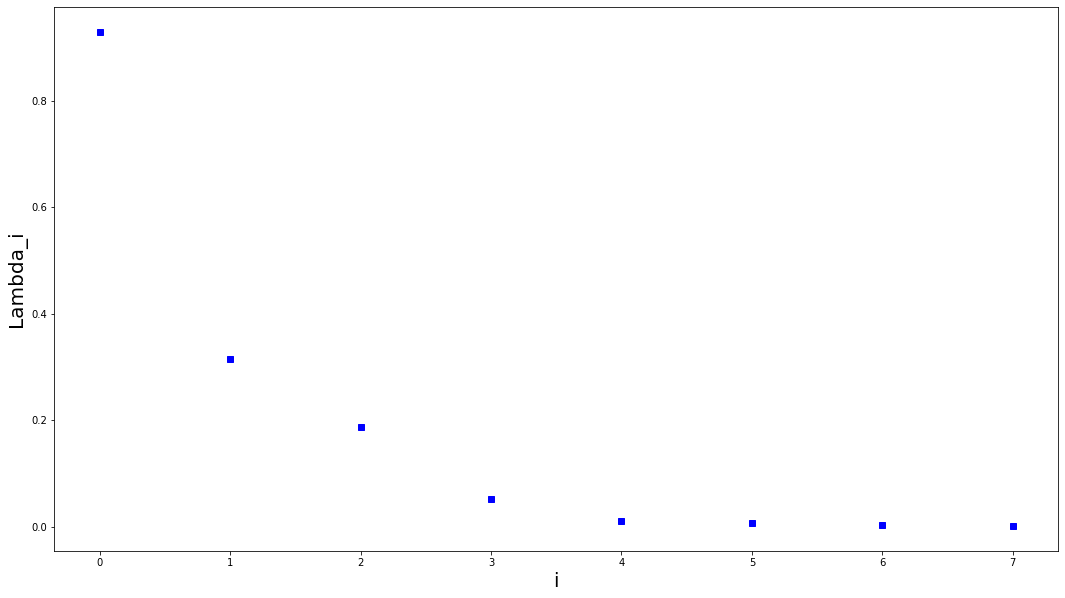

Position =  8 :  0.3488880044513914

Lambda_i = 0.9571848293980574
Lambda_i = 0.2374930561916448
Lambda_i = 0.15916051676276768
Lambda_i = 0.043681572721333904
Lambda_i = 0.01052775541190117
Lambda_i = 0.005716305240711491
Lambda_i = 0.003056980483028614
Lambda_i = 0.0011161675825577498


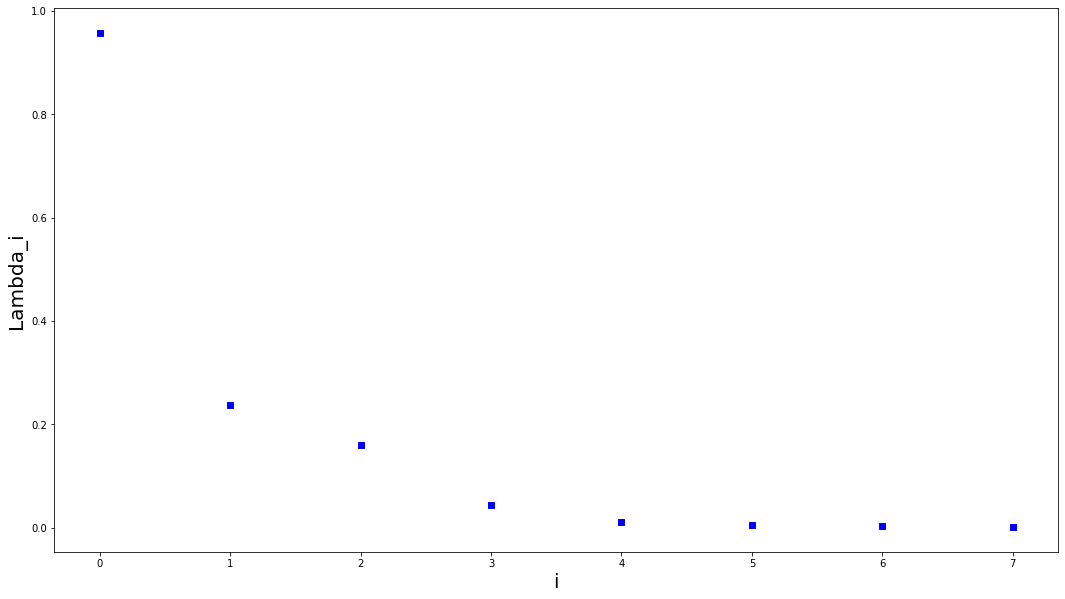

Position =  9 :  0.21956838206118012

Lambda_i = 0.9771268624457405
Lambda_i = 0.16570561734163222
Lambda_i = 0.12830720348654456
Lambda_i = 0.03472859975855621
Lambda_i = 0.00854187055227964
Lambda_i = 0.004099889983494071
Lambda_i = 0.0022675931825169916
Lambda_i = 0.0010071402056133828


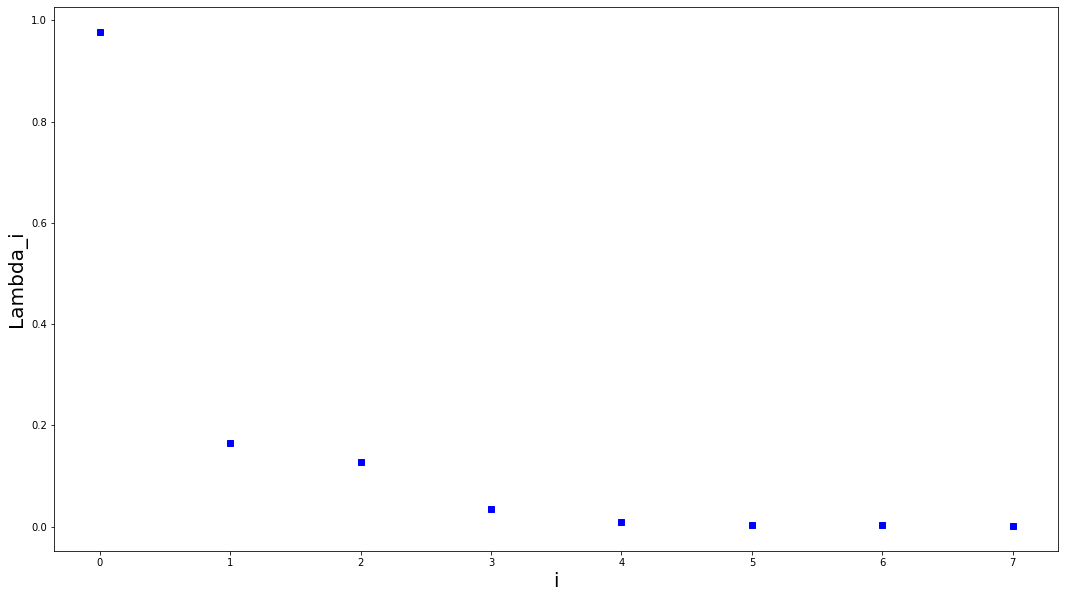

Position =  10 :  0.11497609771602492

Lambda_i = 0.9898950890570548
Lambda_i = 0.10268316856255544
Lambda_i = 0.0943233062008782
Lambda_i = 0.025009745803552943
Lambda_i = 0.0056899217985746115
Lambda_i = 0.0024536301539040805
Lambda_i = 0.001499799813215098
Lambda_i = 0.0009279905013643683


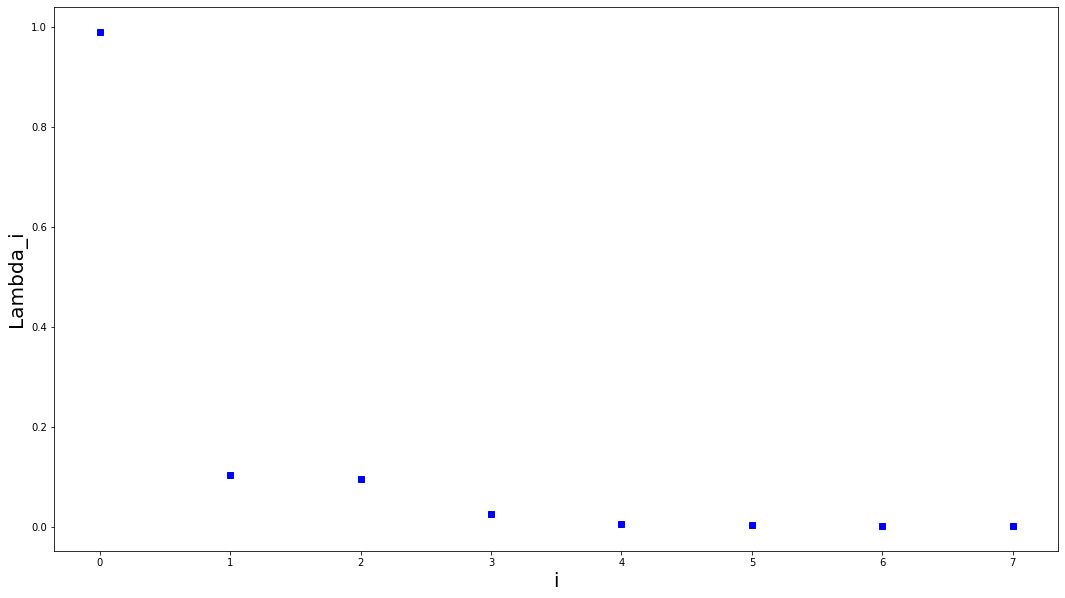

Position =  11 :  0.04338153546215231

Lambda_i = 0.9968300282330197
Lambda_i = 0.06221163801559618
Lambda_i = 0.04727822450138413
Lambda_i = 0.014656136739287489
Lambda_i = 0.0027018474986627455
Lambda_i = 0.0012161474701472231
Lambda_i = 0.000787543476302027
Lambda_i = 0.00041813029967072493


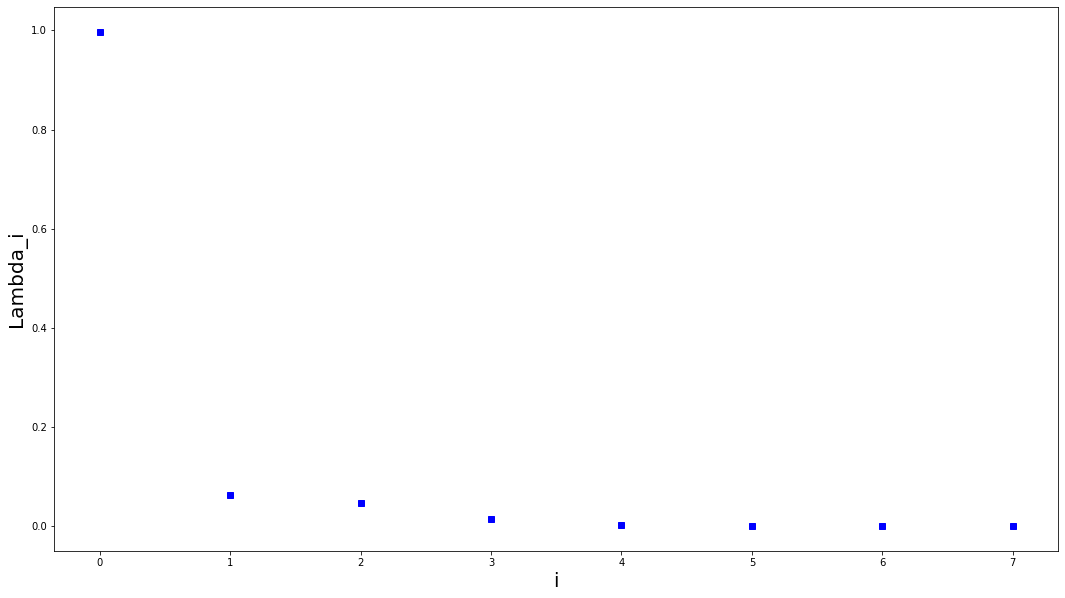

Position =  12 :  0.007576705069897333

Lambda_i = 0.9995541980459023
Lambda_i = 0.0275690962997593
Lambda_i = 0.010635075539200565
Lambda_i = 0.004271447799469746


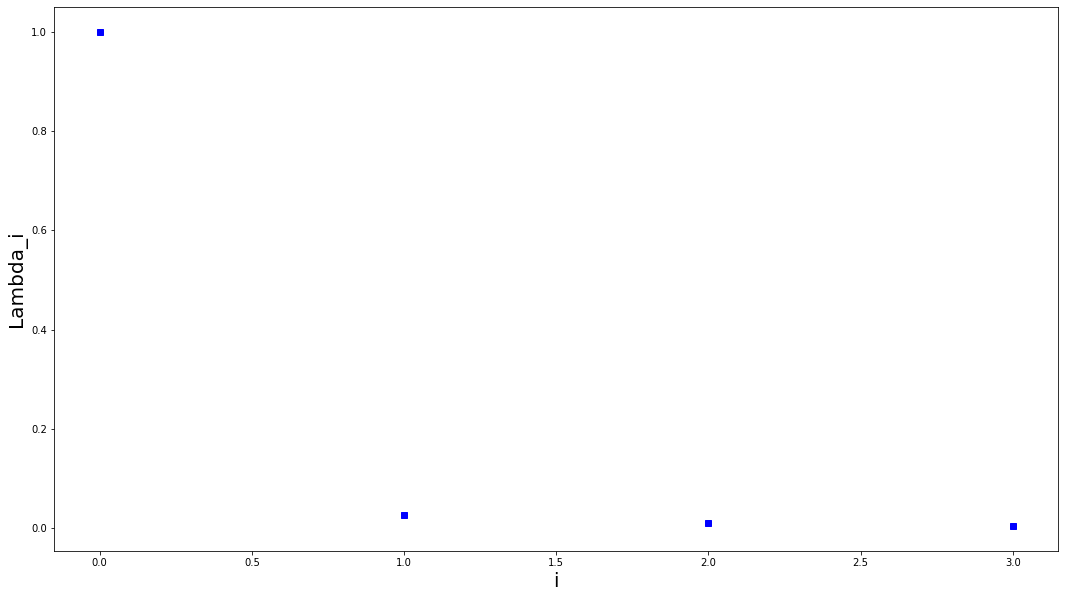

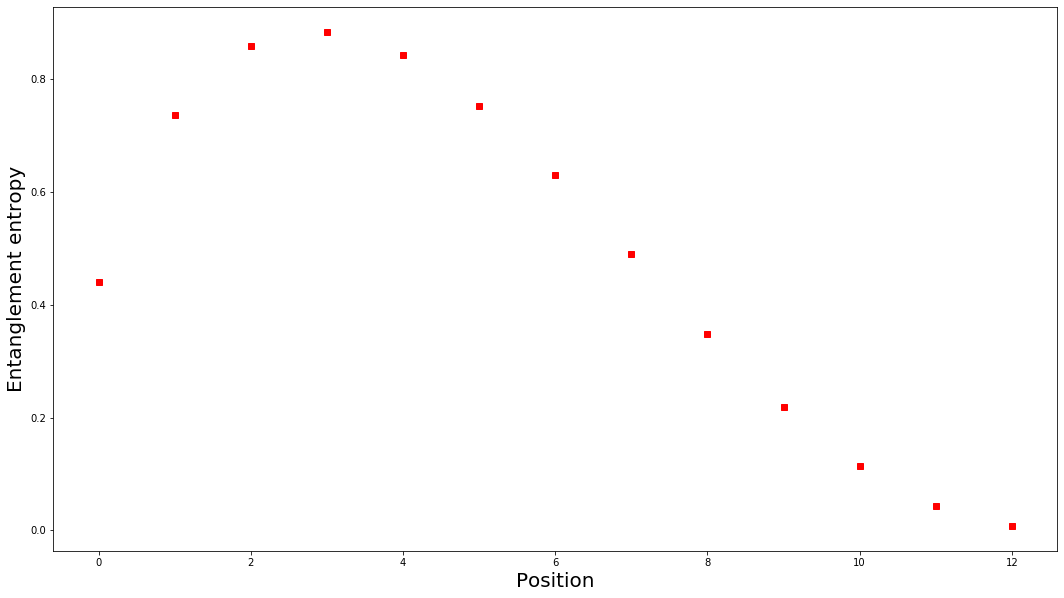

Sweep: 1 of 50, Energy: 0.009575, Bond dim: 16
Sweep: 2 of 50, Energy: 0.009392, Bond dim: 16
Sweep: 3 of 50, Energy: 0.009276, Bond dim: 16
Sweep: 4 of 50, Energy: 0.009183, Bond dim: 16
Sweep: 5 of 50, Energy: 0.009105, Bond dim: 16
Sweep: 6 of 50, Energy: 0.009036, Bond dim: 16
Sweep: 7 of 50, Energy: 0.008973, Bond dim: 16
Sweep: 8 of 50, Energy: 0.008915, Bond dim: 16
Sweep: 9 of 50, Energy: 0.008862, Bond dim: 16
Sweep: 10 of 50, Energy: 0.008812, Bond dim: 16
Sweep: 11 of 50, Energy: 0.008764, Bond dim: 16
Sweep: 12 of 50, Energy: 0.008719, Bond dim: 16
Sweep: 13 of 50, Energy: 0.008677, Bond dim: 16
Sweep: 14 of 50, Energy: 0.008635, Bond dim: 16
Sweep: 15 of 50, Energy: 0.008596, Bond dim: 16
Sweep: 16 of 50, Energy: 0.008558, Bond dim: 16
Sweep: 17 of 50, Energy: 0.008522, Bond dim: 16
Sweep: 18 of 50, Energy: 0.008487, Bond dim: 16
Sweep: 19 of 50, Energy: 0.008454, Bond dim: 16
Sweep: 20 of 50, Energy: 0.008423, Bond dim: 16
Sweep: 21 of 50, Energy: 0.008392, Bond dim: 16
S

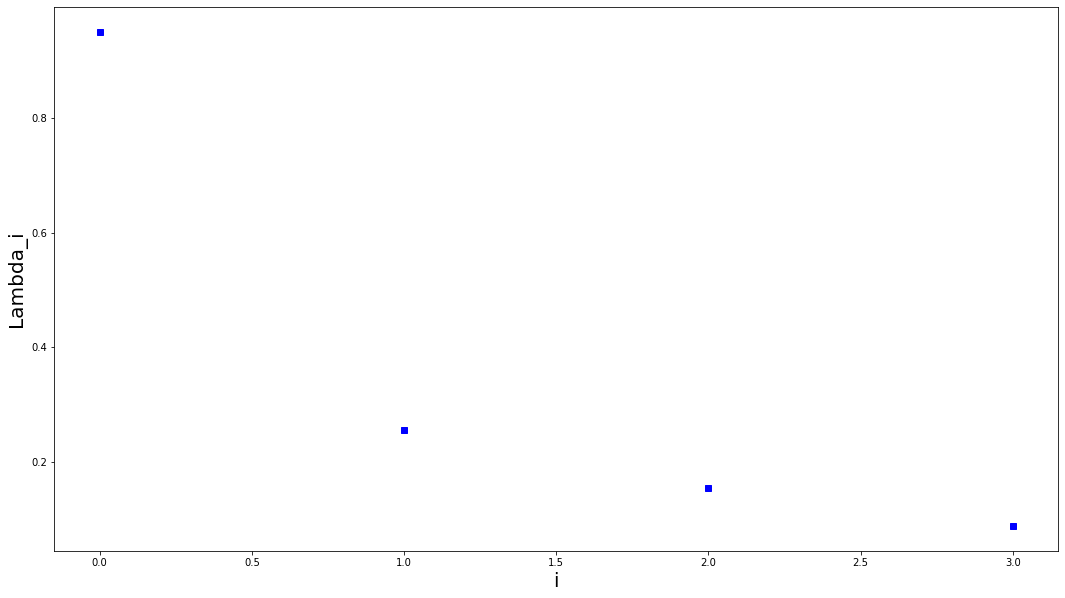

Position =  1 :  0.7770739466948705

Lambda_i = 0.8685758292512276
Lambda_i = 0.375698439521171
Lambda_i = 0.2984104334861586
Lambda_i = 0.11699195828025355
Lambda_i = 0.02233693192815923
Lambda_i = 0.017597269228426304
Lambda_i = 0.015407005358404485
Lambda_i = 0.01490624877115533
Lambda_i = 0.013305963263049827
Lambda_i = 0.012609991138841634
Lambda_i = 0.005994317329541695
Lambda_i = 0.0042197129627323075
Lambda_i = 0.0036536563328771056
Lambda_i = 0.003141298688193119
Lambda_i = 0.002633406132326589
Lambda_i = 0.001637572878388106


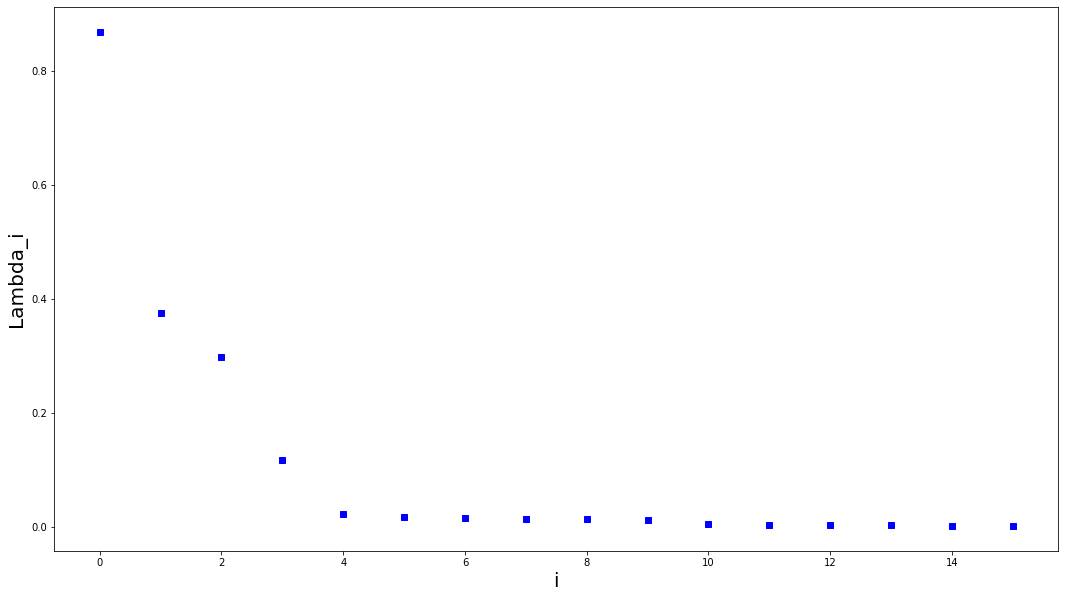

Position =  2 :  0.9323878311047253

Lambda_i = 0.7897558124045773
Lambda_i = 0.5249207004230863
Lambda_i = 0.29260016953610246
Lambda_i = 0.11561826729984441
Lambda_i = 0.021632082068855474
Lambda_i = 0.018146910541173407
Lambda_i = 0.016687849517399184
Lambda_i = 0.014647328080487616
Lambda_i = 0.013298671024041551
Lambda_i = 0.011682208525592236
Lambda_i = 0.009223776043803212
Lambda_i = 0.004828429595589064
Lambda_i = 0.004117279174622676
Lambda_i = 0.0038132796248700938
Lambda_i = 0.0036241359144117196
Lambda_i = 0.0022222380566461067


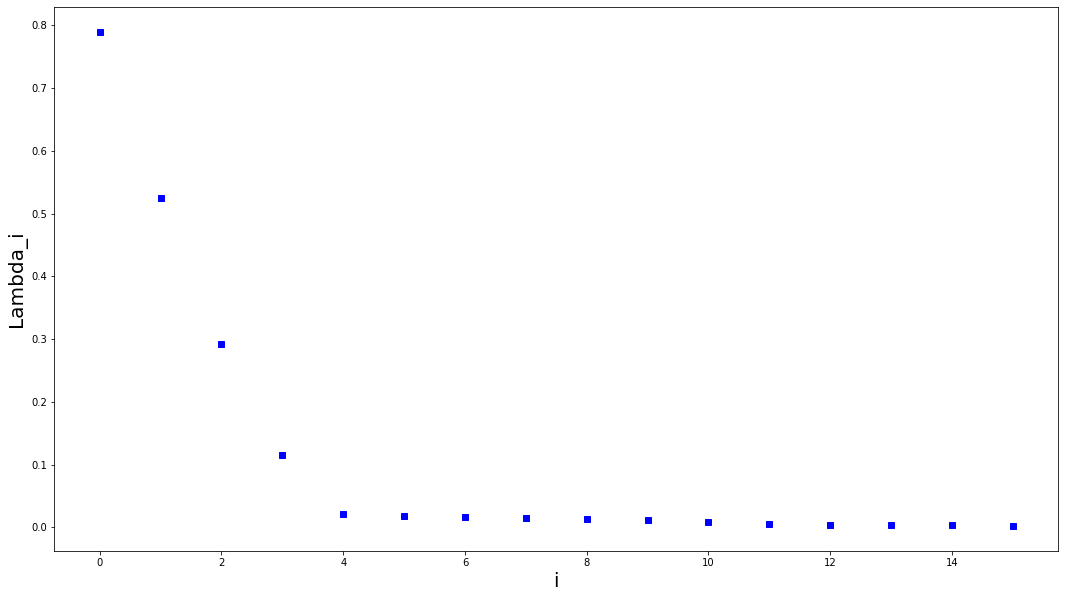

Position =  3 :  0.9617819135361474

Lambda_i = 0.7410894598285961
Lambda_i = 0.5997633225948696
Lambda_i = 0.2783868549793867
Lambda_i = 0.10910435847723632
Lambda_i = 0.02181949188399969
Lambda_i = 0.017459710915757903
Lambda_i = 0.015563221720274517
Lambda_i = 0.015033156264337955
Lambda_i = 0.012663161386323727
Lambda_i = 0.010819784148071129
Lambda_i = 0.008854807683313712
Lambda_i = 0.004772009692161805
Lambda_i = 0.004000062238246735
Lambda_i = 0.0033018507280797873
Lambda_i = 0.0032416406363062556
Lambda_i = 0.001487251453433205


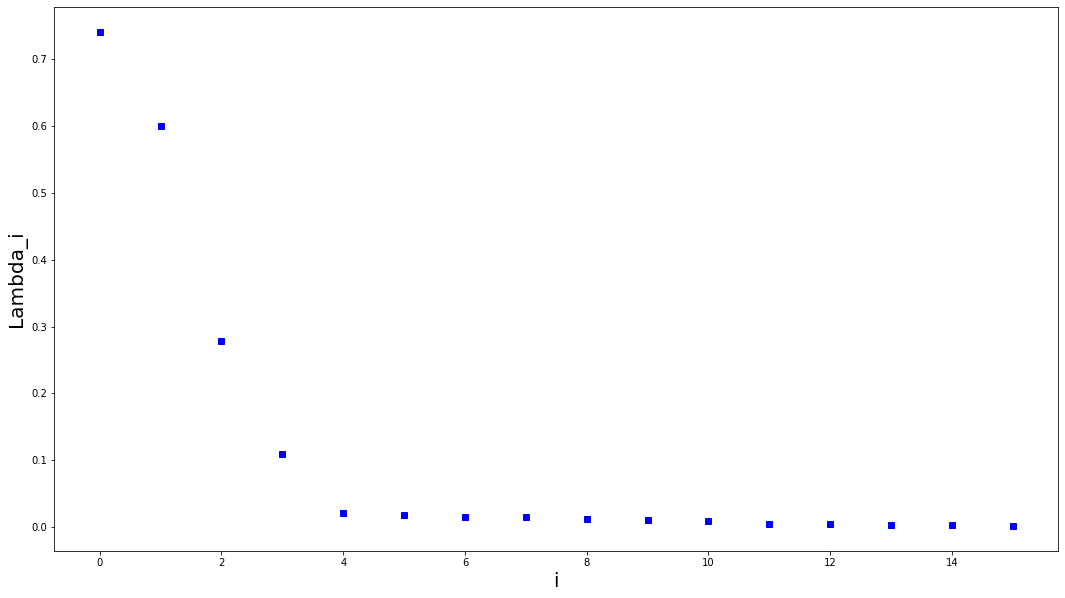

Position =  4 :  0.910750967028283

Lambda_i = 0.7774192375994942
Lambda_i = 0.5620006057946747
Lambda_i = 0.26073863933450225
Lambda_i = 0.10161984738319231
Lambda_i = 0.020677025463725254
Lambda_i = 0.016316481924774782
Lambda_i = 0.015036652614255698
Lambda_i = 0.013626880135625304
Lambda_i = 0.011578880446101954
Lambda_i = 0.009679618364279219
Lambda_i = 0.008299580394214759
Lambda_i = 0.00525445550310869
Lambda_i = 0.0037603623741627253
Lambda_i = 0.0031449051609293774
Lambda_i = 0.002752708259319311
Lambda_i = 0.0014110088989591429


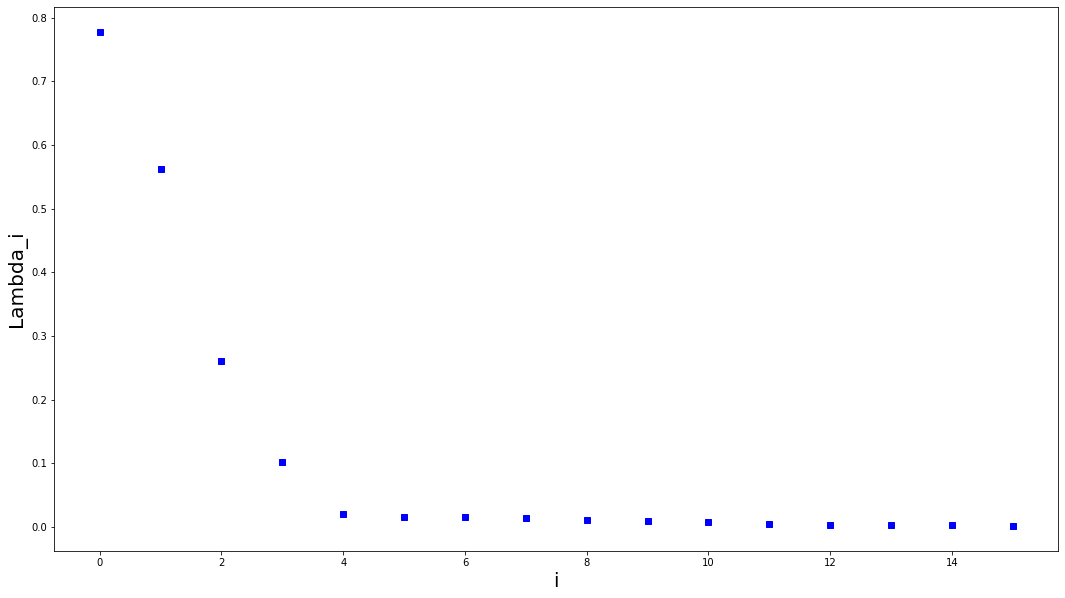

Position =  5 :  0.8050879418329966

Lambda_i = 0.8365669882630302
Lambda_i = 0.4823949620937539
Lambda_i = 0.23993047941963982
Lambda_i = 0.09308251948484272
Lambda_i = 0.019018340915448392
Lambda_i = 0.01506130516722182
Lambda_i = 0.01423979233162381
Lambda_i = 0.011818618807823355
Lambda_i = 0.010355184830944475
Lambda_i = 0.008268325537322943
Lambda_i = 0.007547195225787913
Lambda_i = 0.005362350949512181
Lambda_i = 0.003323377454428235
Lambda_i = 0.002870896894986039
Lambda_i = 0.002455323026574918
Lambda_i = 0.001472122552072545


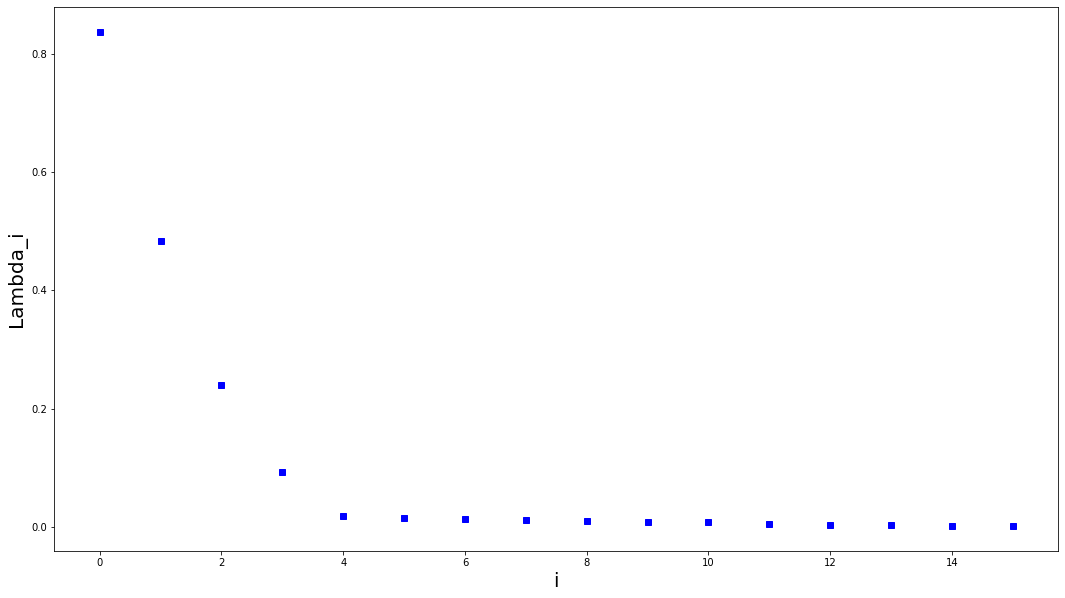

Position =  6 :  0.6651903718926204

Lambda_i = 0.8875692714269089
Lambda_i = 0.3970730871625587
Lambda_i = 0.21596551166102632
Lambda_i = 0.08339495227316213
Lambda_i = 0.016990961485349062
Lambda_i = 0.01381682346080617
Lambda_i = 0.012655615023918534
Lambda_i = 0.010103454255181096
Lambda_i = 0.008916829816945662
Lambda_i = 0.006809262392714435
Lambda_i = 0.006631114458630229
Lambda_i = 0.005007449669601419
Lambda_i = 0.002815034612815506
Lambda_i = 0.002528437262468936
Lambda_i = 0.0021342995375392927
Lambda_i = 0.001514934696233121


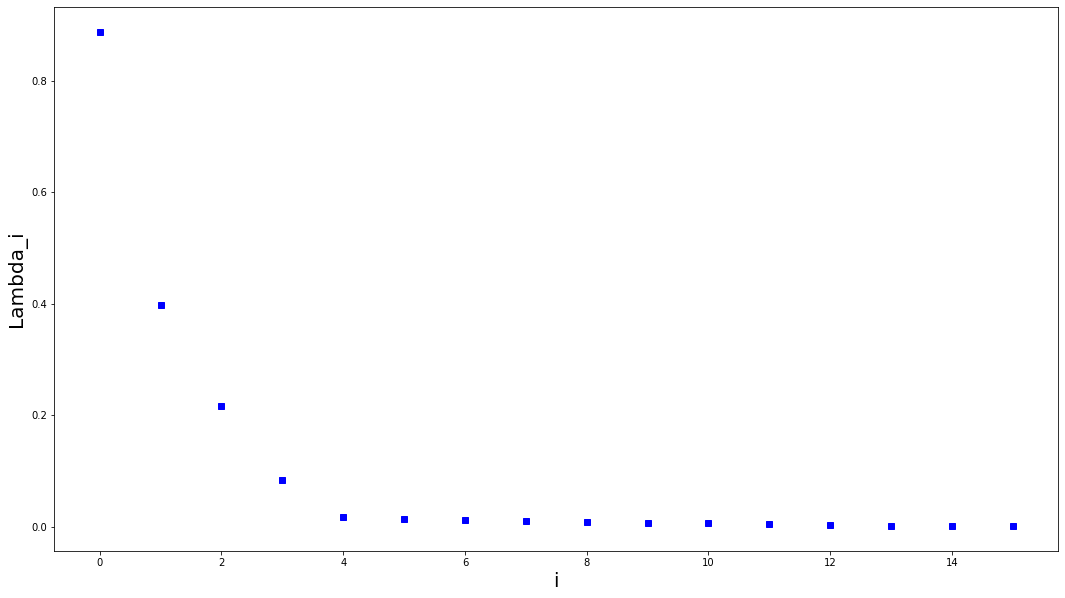

Position =  7 :  0.5095510030500616

Lambda_i = 0.9276606478776335
Lambda_i = 0.3127183618844917
Lambda_i = 0.18893457403651034
Lambda_i = 0.07251881147918321
Lambda_i = 0.014665528376500474
Lambda_i = 0.012332072530323136
Lambda_i = 0.010662090272506534
Lambda_i = 0.008455890454601808
Lambda_i = 0.007304920236506951
Lambda_i = 0.005626027296812088
Lambda_i = 0.005242352422367012
Lambda_i = 0.0042086606514647965
Lambda_i = 0.0022871413741993763
Lambda_i = 0.0021333521313413296
Lambda_i = 0.0017940794265992465
Lambda_i = 0.0014653302793555924


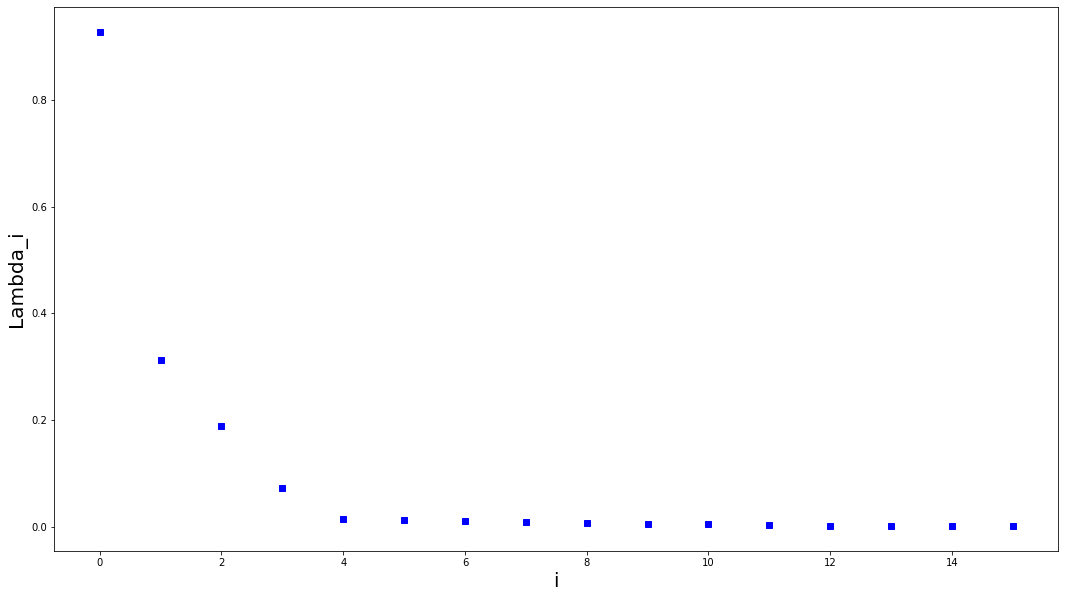

Position =  8 :  0.35534312607659296

Lambda_i = 0.957387448242148
Lambda_i = 0.23236997898608103
Lambda_i = 0.15905450683922803
Lambda_i = 0.060475407260545636
Lambda_i = 0.012105844848142379
Lambda_i = 0.010500388948082083
Lambda_i = 0.008455825633931723
Lambda_i = 0.006766929828696186
Lambda_i = 0.005565301615797544
Lambda_i = 0.004326527101739765
Lambda_i = 0.00380534107491203
Lambda_i = 0.003148108373636302
Lambda_i = 0.0017646077146993037
Lambda_i = 0.0016692720731597502
Lambda_i = 0.0014619660182152321
Lambda_i = 0.0012780966498702176


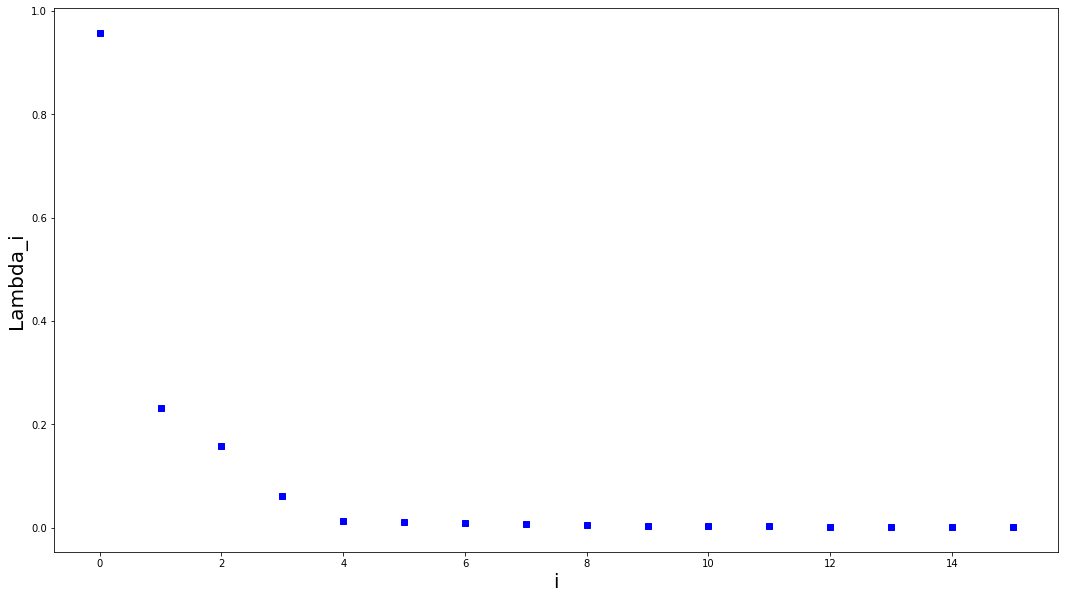

Position =  9 :  0.21790908919413113

Lambda_i = 0.9779063279109996
Lambda_i = 0.15867796148734908
Lambda_i = 0.12658024552104566
Lambda_i = 0.04735301605669438
Lambda_i = 0.009337905464340844
Lambda_i = 0.008279936735170312
Lambda_i = 0.006070115144173723
Lambda_i = 0.004981408784059587
Lambda_i = 0.0037807057127200506
Lambda_i = 0.002962809293459677
Lambda_i = 0.002420084032461973
Lambda_i = 0.00204112043437636
Lambda_i = 0.0013042435160265855
Lambda_i = 0.0012486773402952517
Lambda_i = 0.00101037155326637
Lambda_i = 0.0009279391149889589


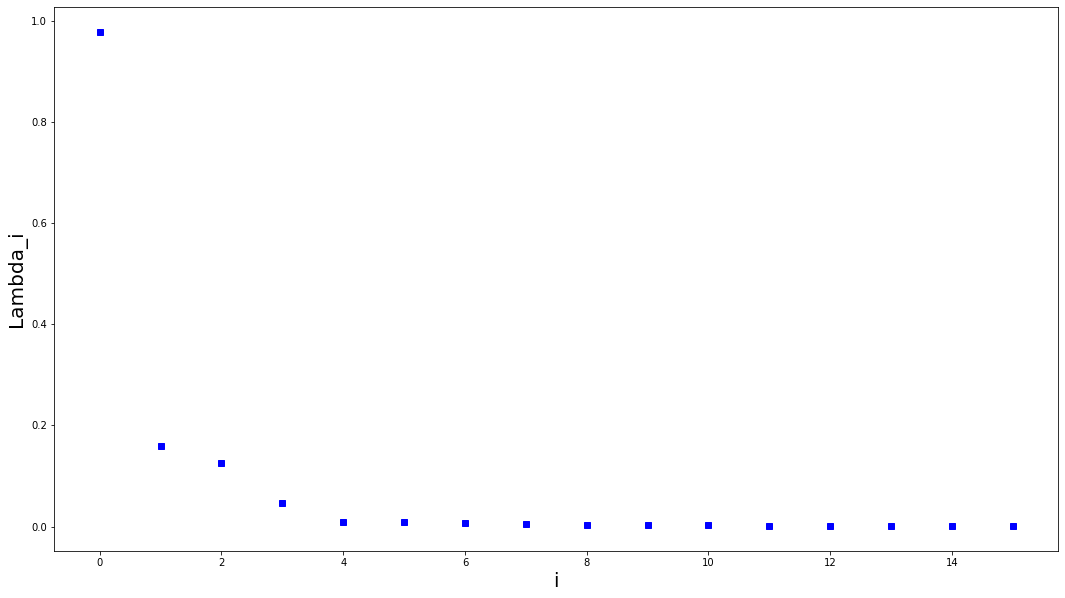

Position =  10 :  0.10974706710215283

Lambda_i = 0.9906381391326701
Lambda_i = 0.09647472426380868
Lambda_i = 0.09007696326002655
Lambda_i = 0.03327758569299933
Lambda_i = 0.006388736446031866
Lambda_i = 0.005647518015061976
Lambda_i = 0.0035897128192933277
Lambda_i = 0.003187687298686799
Lambda_i = 0.0021432210330275476
Lambda_i = 0.0015802814912640288
Lambda_i = 0.0012154480594381563
Lambda_i = 0.0010221851259432054
Lambda_i = 0.0008666843854439244
Lambda_i = 0.0008242730754957914
Lambda_i = 0.0006700550341984058
Lambda_i = 0.0004445769363362431


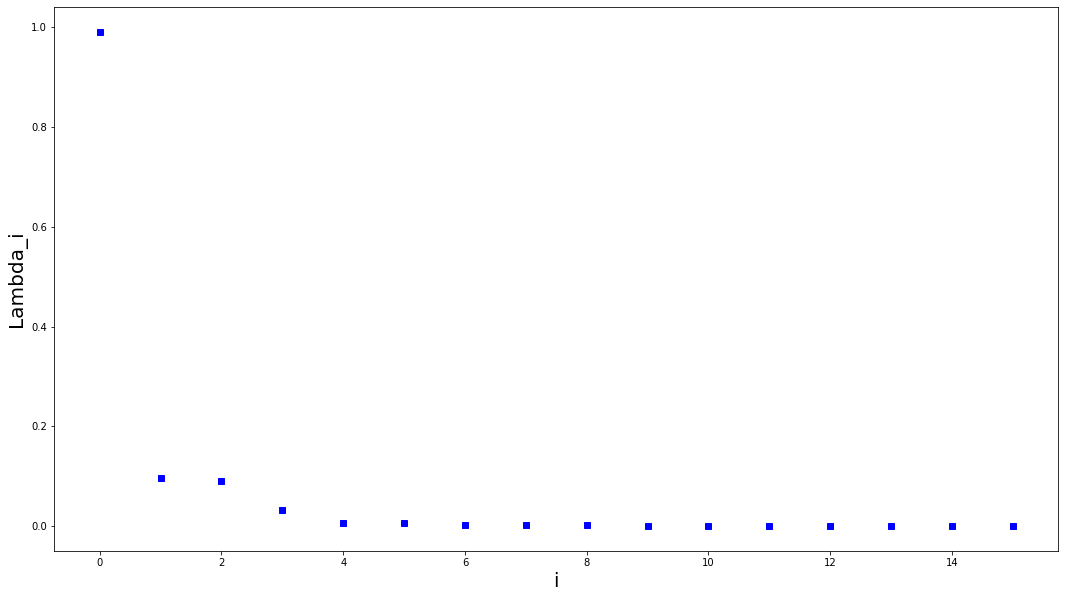

Position =  11 :  0.03896335153081784

Lambda_i = 0.9972404028131402
Lambda_i = 0.05806949877752947
Lambda_i = 0.04196068895222116
Lambda_i = 0.018843775260165705
Lambda_i = 0.003302804818584622
Lambda_i = 0.002777541702291827
Lambda_i = 0.0014415830543999138
Lambda_i = 0.001215090112704793
Lambda_i = 0.0008838931633278114
Lambda_i = 0.0005114873113343625
Lambda_i = 0.0004359233987064563
Lambda_i = 0.0003903088247511443
Lambda_i = 0.00029468594589248553
Lambda_i = 0.00022215234161263733
Lambda_i = 0.0001403760306736447
Lambda_i = 7.751559731009027e-05


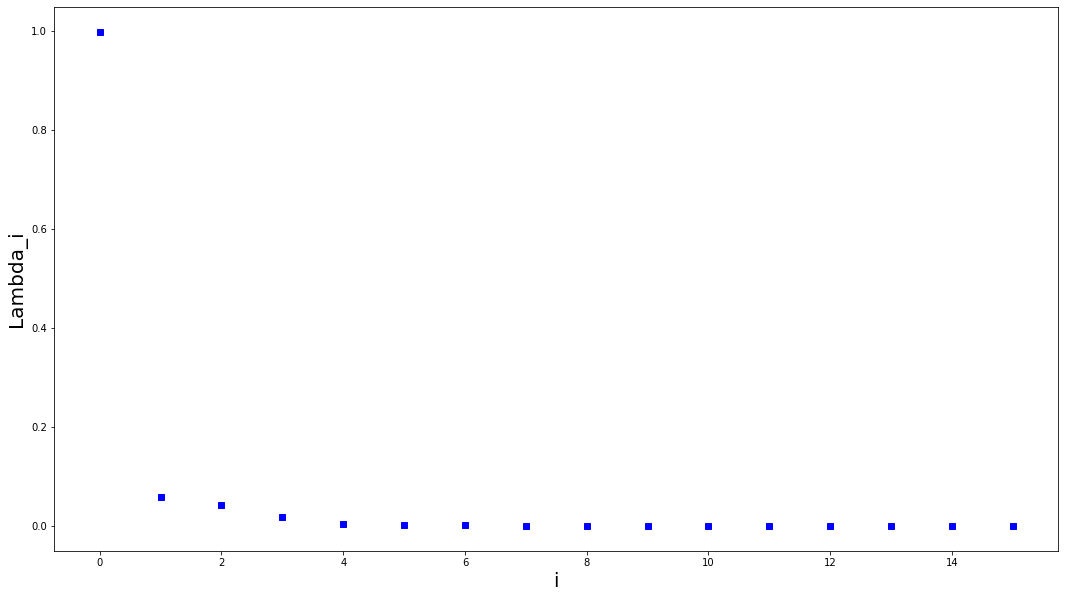

Position =  12 :  0.006059692545947351

Lambda_i = 0.9996549999514518
Lambda_i = 0.02425556423876612
Lambda_i = 0.008553595246608148
Lambda_i = 0.005327727834579909


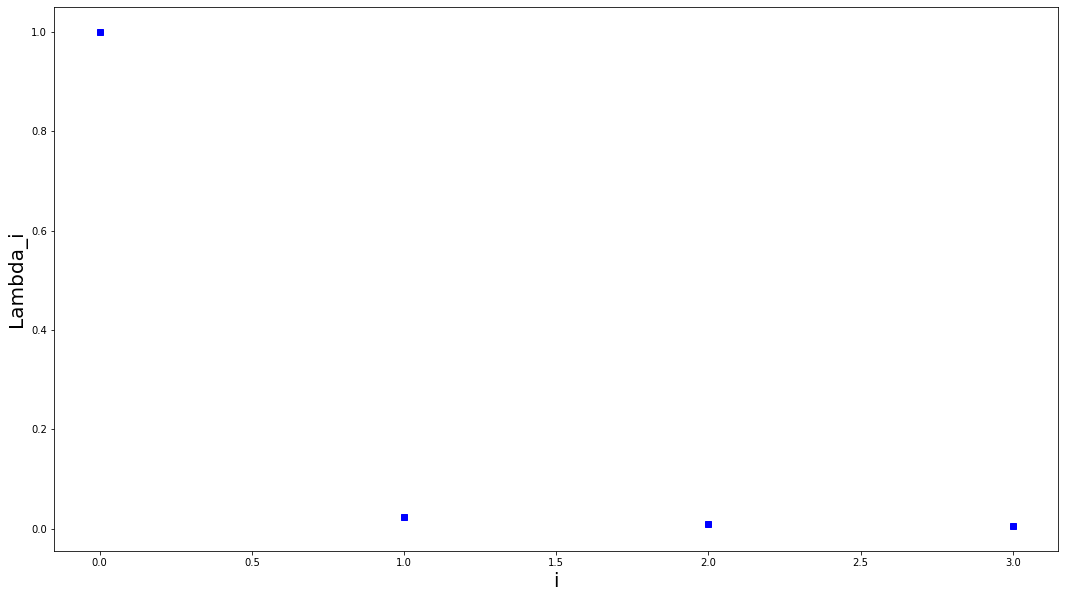

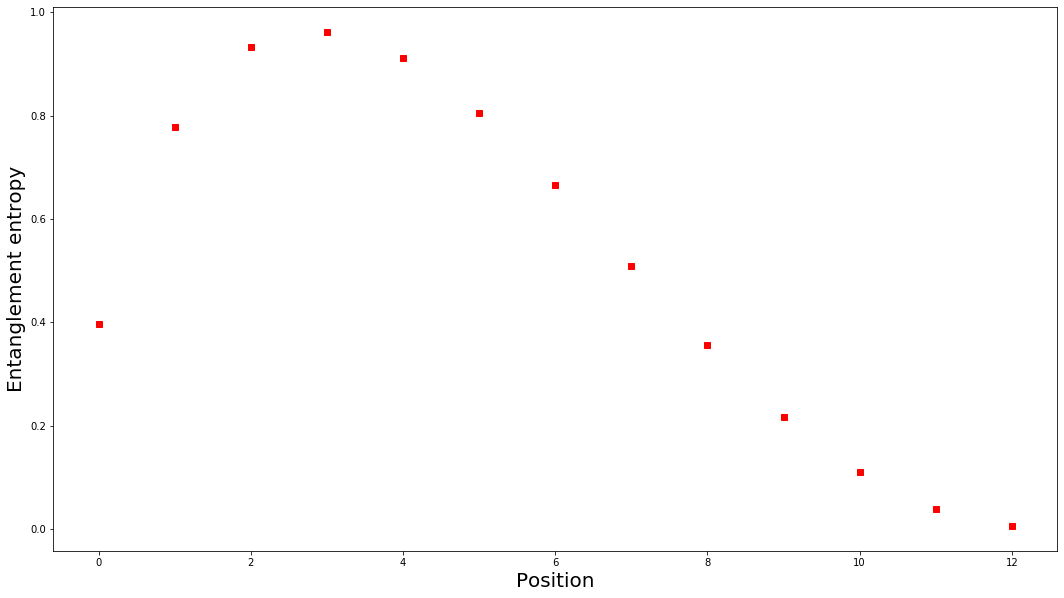

Sweep: 1 of 50, Energy: 0.007406, Bond dim: 32
Sweep: 2 of 50, Energy: 0.007251, Bond dim: 32
Sweep: 3 of 50, Energy: 0.007165, Bond dim: 32
Sweep: 4 of 50, Energy: 0.007103, Bond dim: 32
Sweep: 5 of 50, Energy: 0.007054, Bond dim: 32
Sweep: 6 of 50, Energy: 0.007014, Bond dim: 32
Sweep: 7 of 50, Energy: 0.006980, Bond dim: 32
Sweep: 8 of 50, Energy: 0.006950, Bond dim: 32
Sweep: 9 of 50, Energy: 0.006923, Bond dim: 32
Sweep: 10 of 50, Energy: 0.006898, Bond dim: 32
Sweep: 11 of 50, Energy: 0.006875, Bond dim: 32
Sweep: 12 of 50, Energy: 0.006854, Bond dim: 32
Sweep: 13 of 50, Energy: 0.006833, Bond dim: 32
Sweep: 14 of 50, Energy: 0.006814, Bond dim: 32
Sweep: 15 of 50, Energy: 0.006796, Bond dim: 32
Sweep: 16 of 50, Energy: 0.006778, Bond dim: 32
Sweep: 17 of 50, Energy: 0.006762, Bond dim: 32
Sweep: 18 of 50, Energy: 0.006746, Bond dim: 32
Sweep: 19 of 50, Energy: 0.006730, Bond dim: 32
Sweep: 20 of 50, Energy: 0.006715, Bond dim: 32
Sweep: 21 of 50, Energy: 0.006701, Bond dim: 32
S

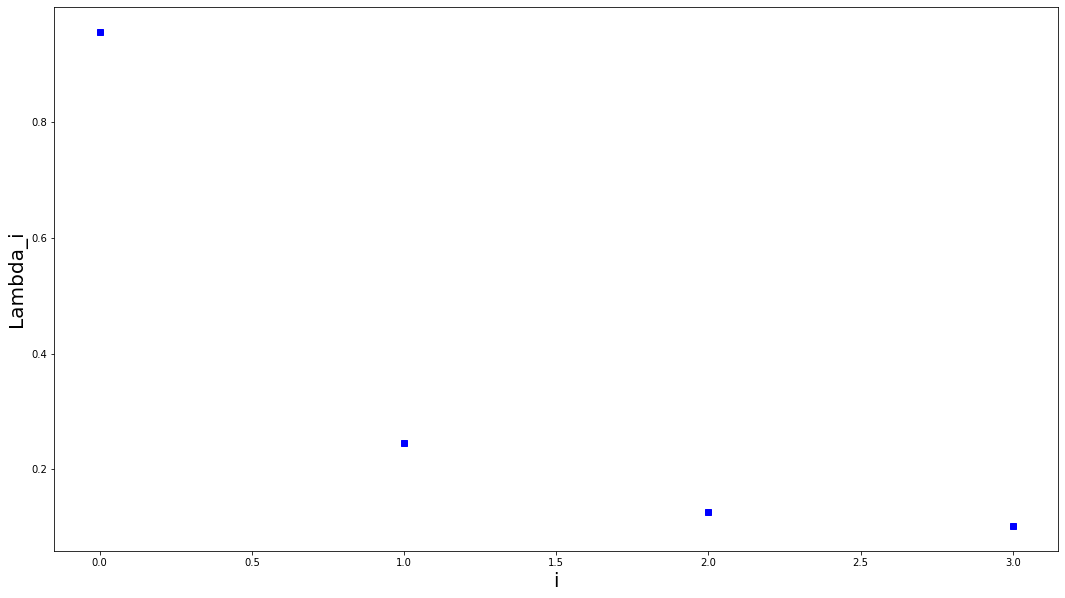

Position =  1 :  0.8036558656926517

Lambda_i = 0.8704295102252818
Lambda_i = 0.3462954563750917
Lambda_i = 0.31110713228040043
Lambda_i = 0.1476211818603276
Lambda_i = 0.030011758558091708
Lambda_i = 0.024838380325747502
Lambda_i = 0.0225828730672097
Lambda_i = 0.022136369697400182
Lambda_i = 0.021969808220481887
Lambda_i = 0.016870276210342924
Lambda_i = 0.013303999536996744
Lambda_i = 0.013101593597208501
Lambda_i = 0.009063515141229708
Lambda_i = 0.007638262081467955
Lambda_i = 0.007082516620639508
Lambda_i = 0.005294192848425181


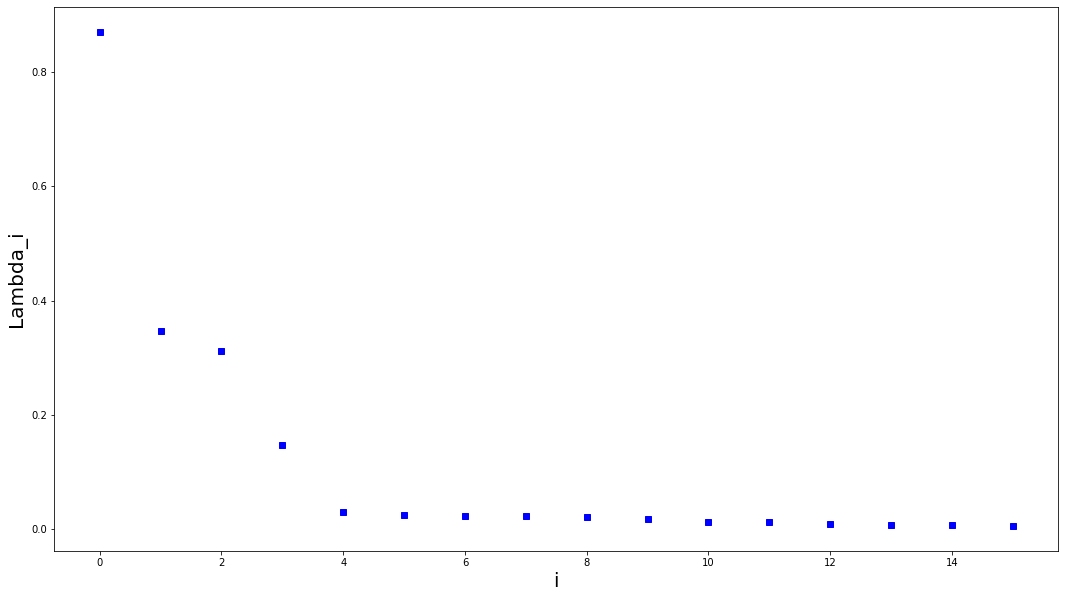

Position =  2 :  0.9982543783101973

Lambda_i = 0.7816015199856984
Lambda_i = 0.5160520094796854
Lambda_i = 0.31028176035807925
Lambda_i = 0.14830653317972883
Lambda_i = 0.03192813753195351
Lambda_i = 0.023662455018777395
Lambda_i = 0.0226600500081059
Lambda_i = 0.022168477478933107
Lambda_i = 0.021492499802168764
Lambda_i = 0.019829009819051502
Lambda_i = 0.014955408366994688
Lambda_i = 0.013435742804971184
Lambda_i = 0.011247660909530654
Lambda_i = 0.009390412697114846
Lambda_i = 0.008847861852628477
Lambda_i = 0.008784210006886322
Lambda_i = 0.008372959824684834
Lambda_i = 0.006896650510904446
Lambda_i = 0.0058265285149963365
Lambda_i = 0.005329394547455701
Lambda_i = 0.005058834607988673
Lambda_i = 0.004626909008197968
Lambda_i = 0.004588606769370013
Lambda_i = 0.0036328305572682824
Lambda_i = 0.003242387655955713
Lambda_i = 0.0029879869564638597
Lambda_i = 0.0024661125813895336
Lambda_i = 0.002349860475595284
Lambda_i = 0.0022197062036532064
Lambda_i = 0.001862609217938209
Lambda_

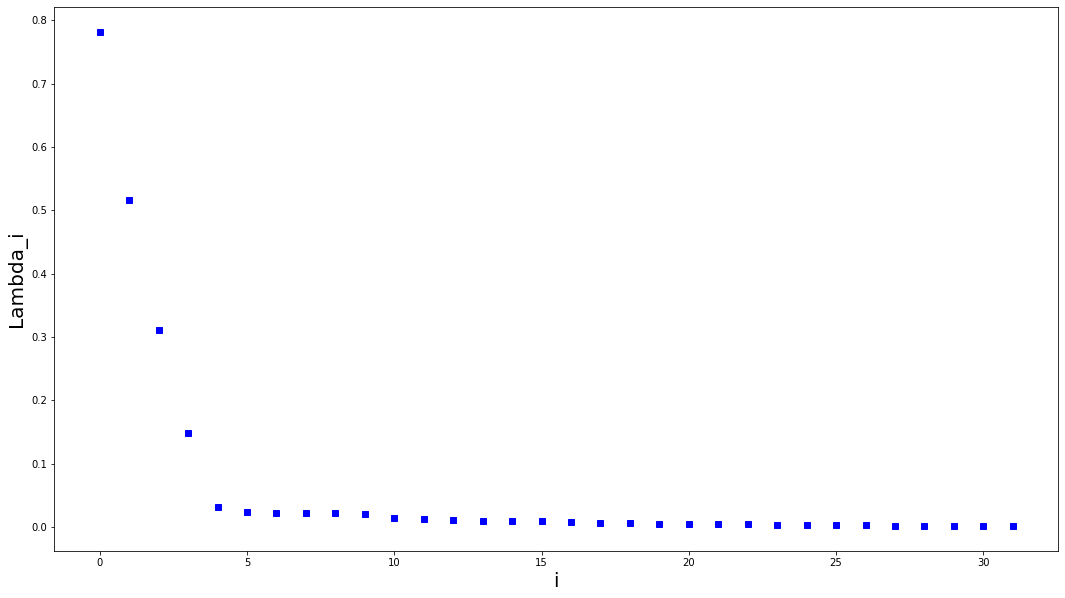

Position =  3 :  1.035427635915144

Lambda_i = 0.7156735735581278
Lambda_i = 0.6134528635379156
Lambda_i = 0.2954685377949229
Lambda_i = 0.14091293382906483
Lambda_i = 0.03153889900614867
Lambda_i = 0.02284394198096085
Lambda_i = 0.022173821533521102
Lambda_i = 0.02169069307026611
Lambda_i = 0.020679439094337223
Lambda_i = 0.019313365514576367
Lambda_i = 0.01361033467563276
Lambda_i = 0.013064038136744099
Lambda_i = 0.011369118930299621
Lambda_i = 0.010319738987148446
Lambda_i = 0.009141096529934938
Lambda_i = 0.008867282542063815
Lambda_i = 0.008231477924140094
Lambda_i = 0.006858437446463448
Lambda_i = 0.006072804065307542
Lambda_i = 0.005504968551903129
Lambda_i = 0.0046339778242520824
Lambda_i = 0.0041921865348917885
Lambda_i = 0.0040510744257855795
Lambda_i = 0.003986917013249682
Lambda_i = 0.0031595008627668267
Lambda_i = 0.0030212770213960873
Lambda_i = 0.0025250515965515815
Lambda_i = 0.0024192607737217146
Lambda_i = 0.0022285979234184772
Lambda_i = 0.001639956226466946
Lambda_

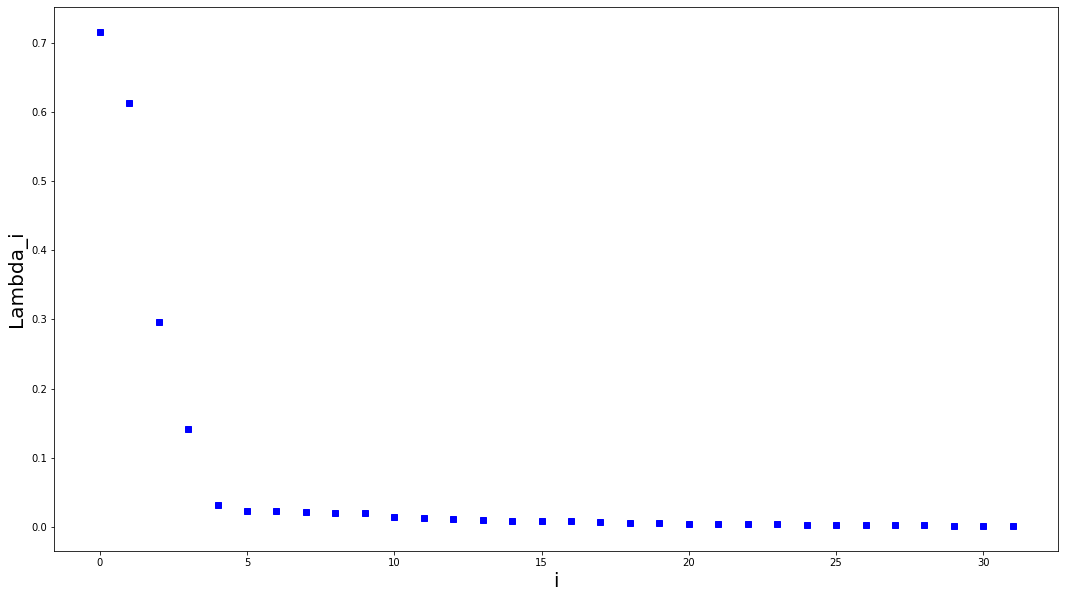

Position =  4 :  0.9751336861127715

Lambda_i = 0.763366715756252
Lambda_i = 0.5661448390678214
Lambda_i = 0.2754115149062584
Lambda_i = 0.13071349659011167
Lambda_i = 0.030238145869676235
Lambda_i = 0.022343555017768753
Lambda_i = 0.0205950319467109
Lambda_i = 0.02003061452658539
Lambda_i = 0.01901371398602042
Lambda_i = 0.01722481508776906
Lambda_i = 0.012763998976662586
Lambda_i = 0.012033424083474822
Lambda_i = 0.010510944412585101
Lambda_i = 0.009824515361270422
Lambda_i = 0.008971233568906131
Lambda_i = 0.008283374154979904
Lambda_i = 0.007746631393772355
Lambda_i = 0.006453507648928912
Lambda_i = 0.005572593183187724
Lambda_i = 0.005223444131714358
Lambda_i = 0.004080979272016103
Lambda_i = 0.00395905106533846
Lambda_i = 0.0038950475304857872
Lambda_i = 0.003240138796930864
Lambda_i = 0.0029009112606601492
Lambda_i = 0.0024473072316493687
Lambda_i = 0.002403999611612995
Lambda_i = 0.0022332243970869265
Lambda_i = 0.0018254415349537626
Lambda_i = 0.0017275079501250722
Lambda_i = 

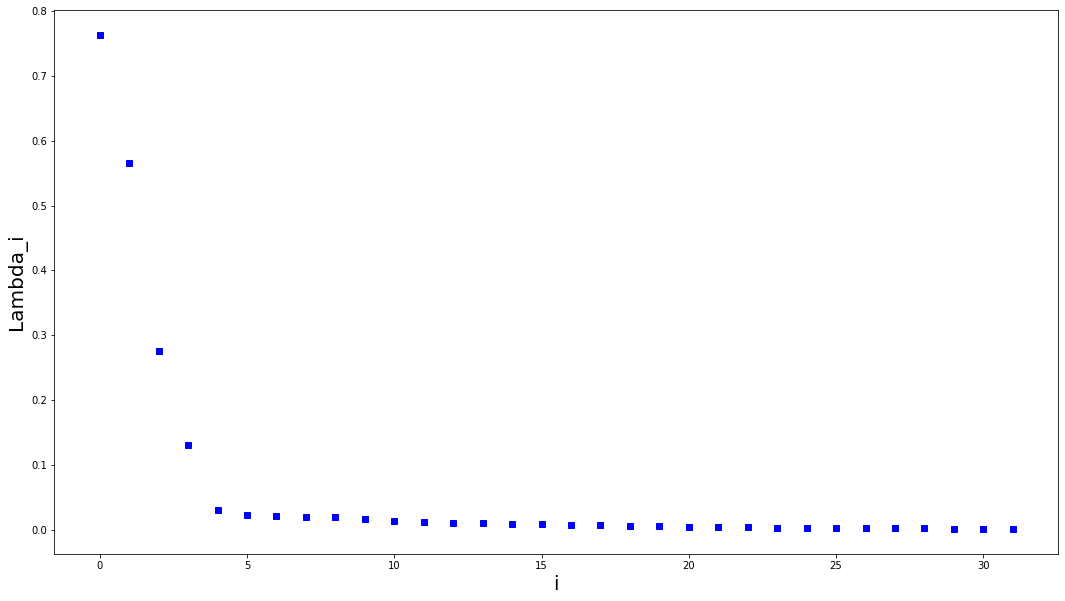

Position =  5 :  0.8517218821807612

Lambda_i = 0.8319148245439958
Lambda_i = 0.47702648923795143
Lambda_i = 0.25133579871318606
Lambda_i = 0.11856329126817113
Lambda_i = 0.02802013009201549
Lambda_i = 0.021040651572499486
Lambda_i = 0.018868697355781668
Lambda_i = 0.01757988346167859
Lambda_i = 0.0167051322419544
Lambda_i = 0.014563205755378013
Lambda_i = 0.011548015188032404
Lambda_i = 0.011029500961063643
Lambda_i = 0.009497523057336095
Lambda_i = 0.008715111372017293
Lambda_i = 0.00836828222220804
Lambda_i = 0.007316899018540558
Lambda_i = 0.007209009863067399
Lambda_i = 0.005971092649925715
Lambda_i = 0.004897976194413744
Lambda_i = 0.004682596184498213
Lambda_i = 0.003600633029891757
Lambda_i = 0.003548832499418104
Lambda_i = 0.0034914120851480736
Lambda_i = 0.0028700099100693256
Lambda_i = 0.002622459982779824
Lambda_i = 0.0024351412198405802
Lambda_i = 0.002229249987218583
Lambda_i = 0.0018726147988184889
Lambda_i = 0.0016329396388780632
Lambda_i = 0.0014103156307810622
Lambda_

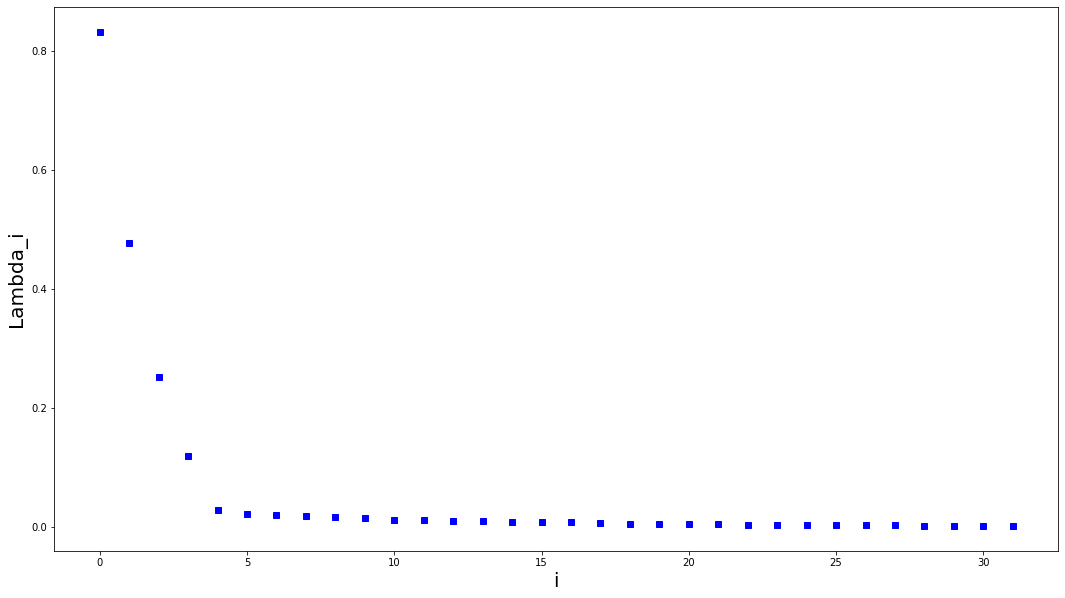

Position =  6 :  0.6918187851203902

Lambda_i = 0.887327396247737
Lambda_i = 0.38626615461205976
Lambda_i = 0.22375383680321112
Lambda_i = 0.10478774959104414
Lambda_i = 0.025068360921494427
Lambda_i = 0.0189923189229211
Lambda_i = 0.016750935446245136
Lambda_i = 0.014947468640092283
Lambda_i = 0.01414940268906417
Lambda_i = 0.011863974651798443
Lambda_i = 0.01015550473950589
Lambda_i = 0.009727934296576337
Lambda_i = 0.008335268312925304
Lambda_i = 0.007421269270040143
Lambda_i = 0.007070635340260928
Lambda_i = 0.006558276575186113
Lambda_i = 0.006098283836572897
Lambda_i = 0.005274180968555425
Lambda_i = 0.004065259047433763
Lambda_i = 0.0038986913754292933
Lambda_i = 0.0033002399291211476
Lambda_i = 0.0029797513058384367
Lambda_i = 0.0029626423043810773
Lambda_i = 0.002762110326594113
Lambda_i = 0.002335931105718055
Lambda_i = 0.00197455965284647
Lambda_i = 0.001919321463884107
Lambda_i = 0.0014965460109049047
Lambda_i = 0.0014331579241987158
Lambda_i = 0.0011381176297061571
Lambda_

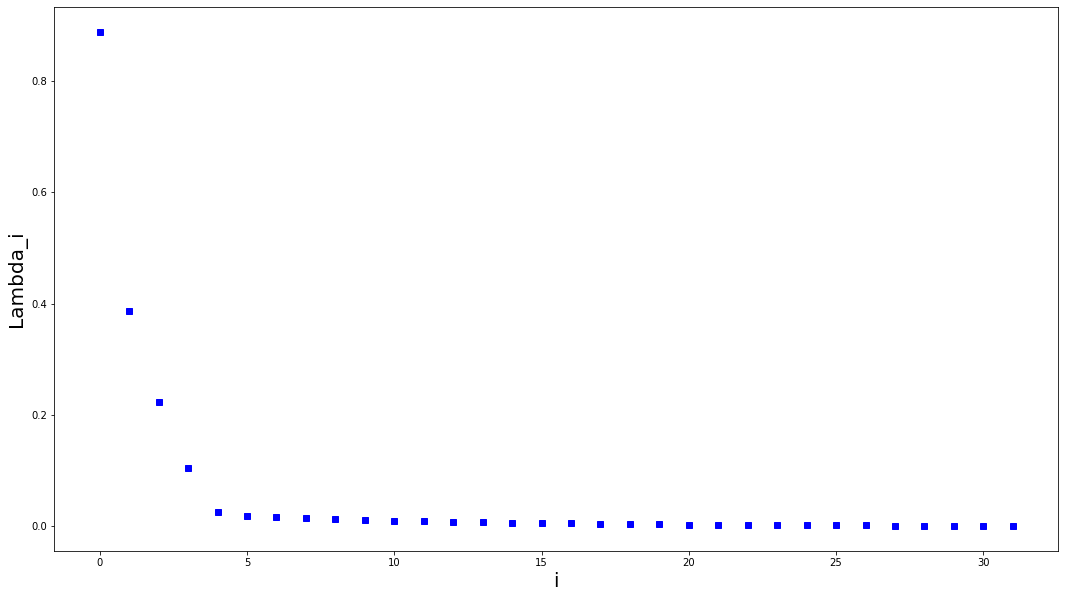

Position =  7 :  0.5183368869062169

Lambda_i = 0.9293612575098296
Lambda_i = 0.298902614366407
Lambda_i = 0.1929843307431494
Lambda_i = 0.08948487707068402
Lambda_i = 0.021662326035744115
Lambda_i = 0.016365321581152763
Lambda_i = 0.014228491372475302
Lambda_i = 0.012333552868327076
Lambda_i = 0.01161894057466579
Lambda_i = 0.009375349580972053
Lambda_i = 0.008434748472924554
Lambda_i = 0.007948356921891596
Lambda_i = 0.006977444453033048
Lambda_i = 0.006066734041265988
Lambda_i = 0.005620711915071571
Lambda_i = 0.005327830614689315
Lambda_i = 0.004919426433385981
Lambda_i = 0.004334891770380902
Lambda_i = 0.0033240164539315377
Lambda_i = 0.003119875203996215
Lambda_i = 0.002913533297384018
Lambda_i = 0.0023101155977855088
Lambda_i = 0.002287929376411246
Lambda_i = 0.0021318346711594483
Lambda_i = 0.001904883819124057
Lambda_i = 0.001624285686934578
Lambda_i = 0.001429628983370636
Lambda_i = 0.0011516131564047248
Lambda_i = 0.0011283509769013848
Lambda_i = 0.000873790954299243
Lambda_

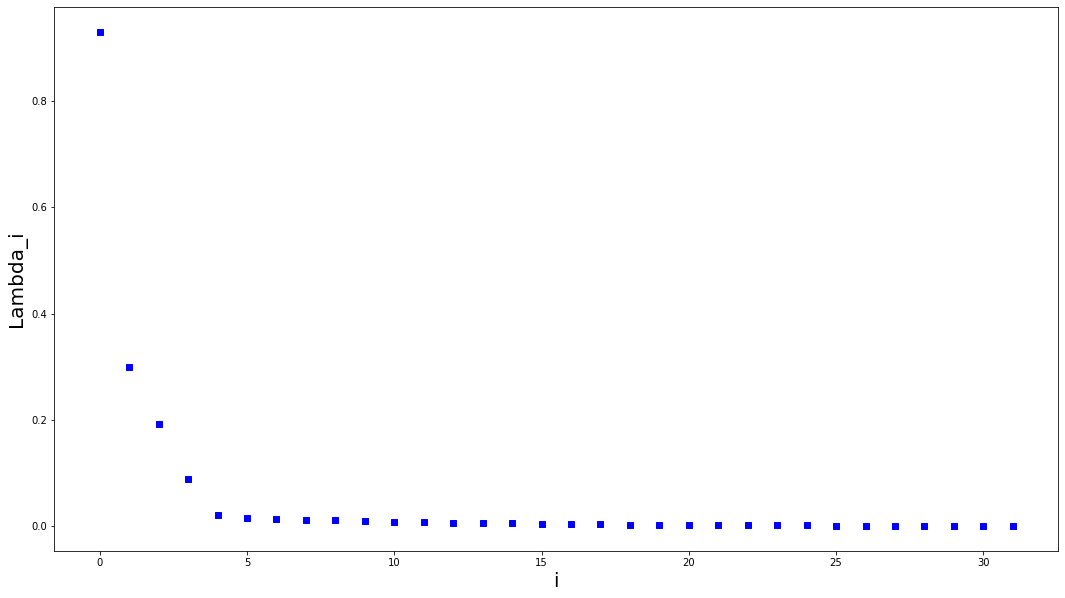

Position =  8 :  0.35159030388517065

Lambda_i = 0.959562134305345
Lambda_i = 0.21770790732993855
Lambda_i = 0.15954945195525227
Lambda_i = 0.07290912862333417
Lambda_i = 0.01791793881038255
Lambda_i = 0.013327412302958854
Lambda_i = 0.011416363411628763
Lambda_i = 0.009979582925523029
Lambda_i = 0.00902174244919586
Lambda_i = 0.0070628597933404
Lambda_i = 0.00633685241236905
Lambda_i = 0.0058519061309824
Lambda_i = 0.00553167007405597
Lambda_i = 0.004573053891537679
Lambda_i = 0.004229342765607687
Lambda_i = 0.0039641154835543405
Lambda_i = 0.003472099159255405
Lambda_i = 0.00318590668213778
Lambda_i = 0.002606510417514027
Lambda_i = 0.002308648007367138
Lambda_i = 0.0020510084044244566
Lambda_i = 0.001621705698973296
Lambda_i = 0.0015662548465100875
Lambda_i = 0.001487308955721174
Lambda_i = 0.001405047081190066
Lambda_i = 0.0012615888955844277
Lambda_i = 0.0009729960197834559
Lambda_i = 0.0008321497296832801
Lambda_i = 0.0007809246901912878
Lambda_i = 0.0006292686480626541
Lambda_i 

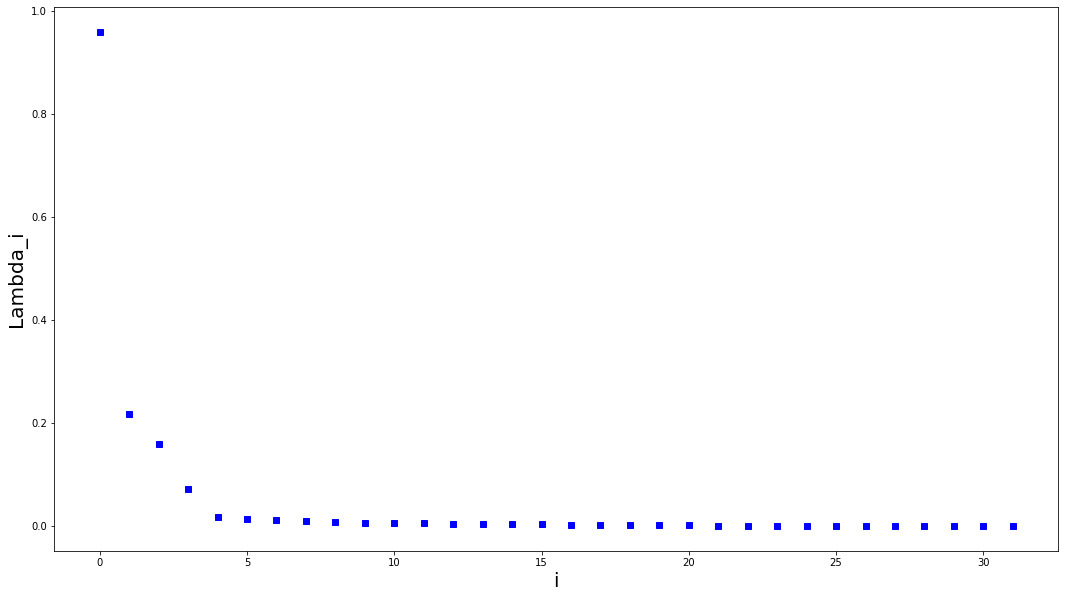

Position =  9 :  0.20845270310318706

Lambda_i = 0.9797054183033189
Lambda_i = 0.14528409449368654
Lambda_i = 0.1241328564383838
Lambda_i = 0.05554677444172956
Lambda_i = 0.013880274770073772
Lambda_i = 0.009992794895055418
Lambda_i = 0.008358943072502902
Lambda_i = 0.007727341101191183
Lambda_i = 0.006375249454484988
Lambda_i = 0.004707507323535309
Lambda_i = 0.004095444228270404
Lambda_i = 0.003987410590916305
Lambda_i = 0.003871155532162837
Lambda_i = 0.003035188869064255
Lambda_i = 0.0027239407154240024
Lambda_i = 0.0026167551808200093
Lambda_i = 0.002154229785782206
Lambda_i = 0.0017933776238859146
Lambda_i = 0.0016180056455550249
Lambda_i = 0.0015364694994186158
Lambda_i = 0.0012519040261003464
Lambda_i = 0.0009901101039806854
Lambda_i = 0.000946504568247621
Lambda_i = 0.0008364834930606677
Lambda_i = 0.000798825241950781
Lambda_i = 0.0007678615849622156
Lambda_i = 0.0005893946113863872
Lambda_i = 0.0005381974630430381
Lambda_i = 0.00043571233247529354
Lambda_i = 0.00035722004040

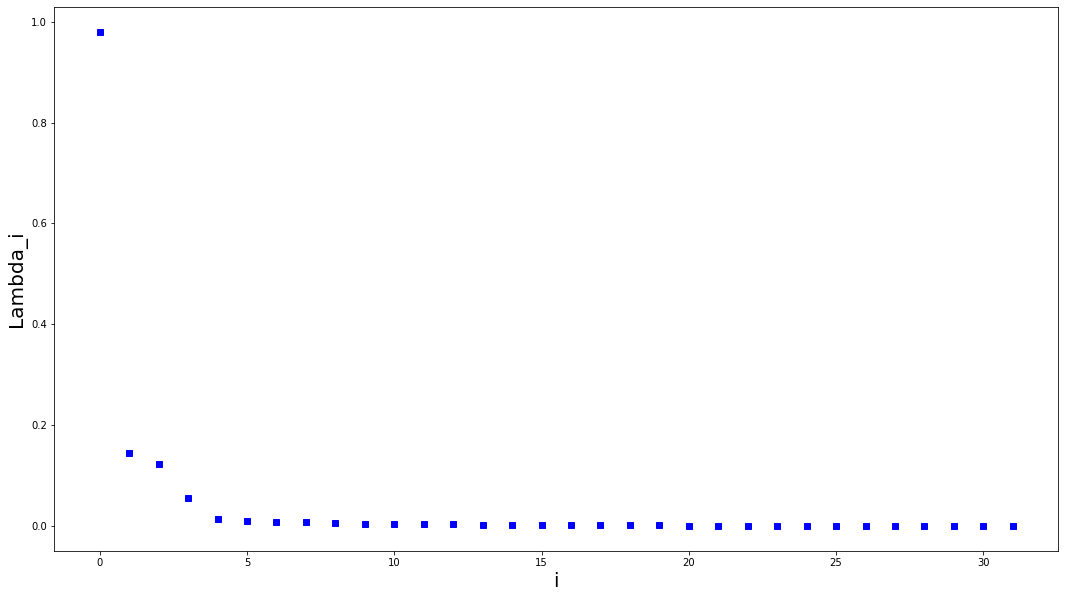

Position =  10 :  0.10077039312273098

Lambda_i = 0.9917209470240591
Lambda_i = 0.08985914417308709
Lambda_i = 0.08214215224899687
Lambda_i = 0.03788735245152079
Lambda_i = 0.00966095536445818
Lambda_i = 0.006523326614652927
Lambda_i = 0.005311195101551723
Lambda_i = 0.004999278725707273
Lambda_i = 0.0036934155295500035
Lambda_i = 0.0023900461771413878
Lambda_i = 0.0023126579537635036
Lambda_i = 0.002123373778998937
Lambda_i = 0.002039635057792183
Lambda_i = 0.0014571486612860128
Lambda_i = 0.001315756426799688
Lambda_i = 0.001200764804518762
Lambda_i = 0.0011620834493332299
Lambda_i = 0.0009019235522294993
Lambda_i = 0.0007534479709123232
Lambda_i = 0.000708662090693127
Lambda_i = 0.0005904341639872213
Lambda_i = 0.0004122251090306094
Lambda_i = 0.0003895999039684681
Lambda_i = 0.0003520867367618743
Lambda_i = 0.0002798639362385472
Lambda_i = 0.00026725381705124286
Lambda_i = 0.00022987255692218892
Lambda_i = 0.00019579259191525525
Lambda_i = 0.0001720646681256897
Lambda_i = 0.0001499

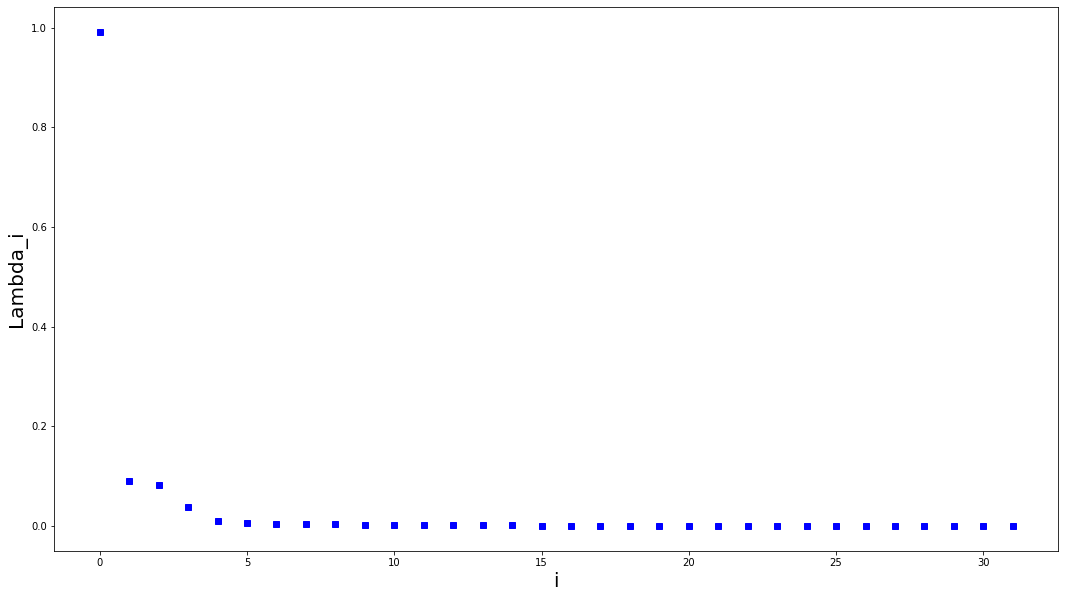

Position =  11 :  0.03403024915719168

Lambda_i = 0.9976672276884174
Lambda_i = 0.053759515491052456
Lambda_i = 0.0358025379827271
Lambda_i = 0.02097170612609123
Lambda_i = 0.005143525702659826
Lambda_i = 0.0030422084492925925
Lambda_i = 0.0023558555176395753
Lambda_i = 0.0018445575249385066
Lambda_i = 0.0012819311024487128
Lambda_i = 0.0008743013523518755
Lambda_i = 0.0006226507545994918
Lambda_i = 0.0006108506672576988
Lambda_i = 0.0005409966063950615
Lambda_i = 0.00035080283680870544
Lambda_i = 0.00033275018253829425
Lambda_i = 0.000157241523634263


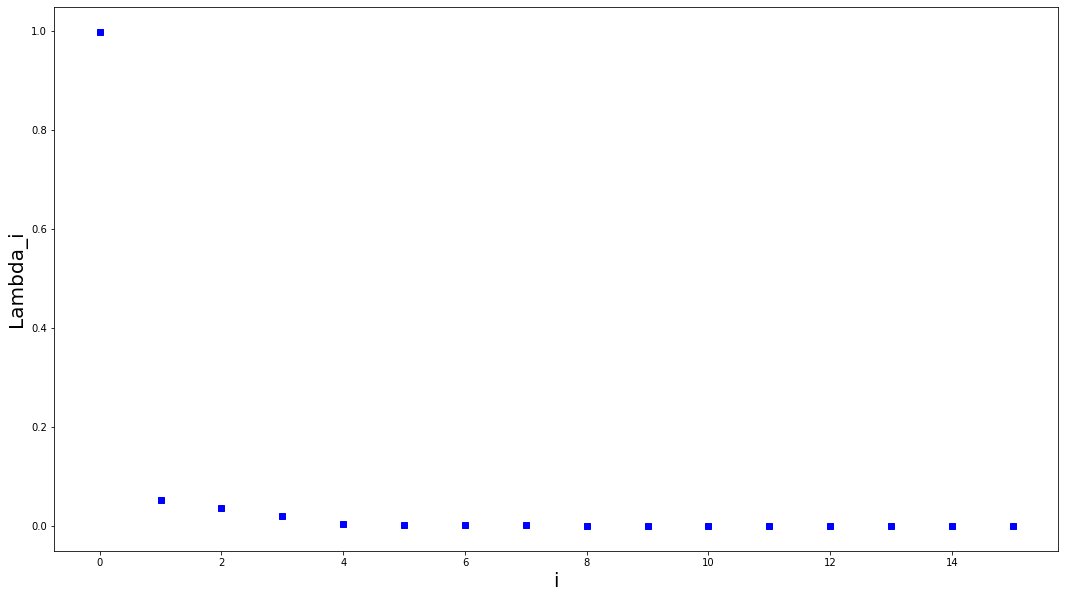

Position =  12 :  0.004934843682404353

Lambda_i = 0.9997266919232624
Lambda_i = 0.021593903044087755
Lambda_i = 0.006747069807286134
Lambda_i = 0.005892525477984396


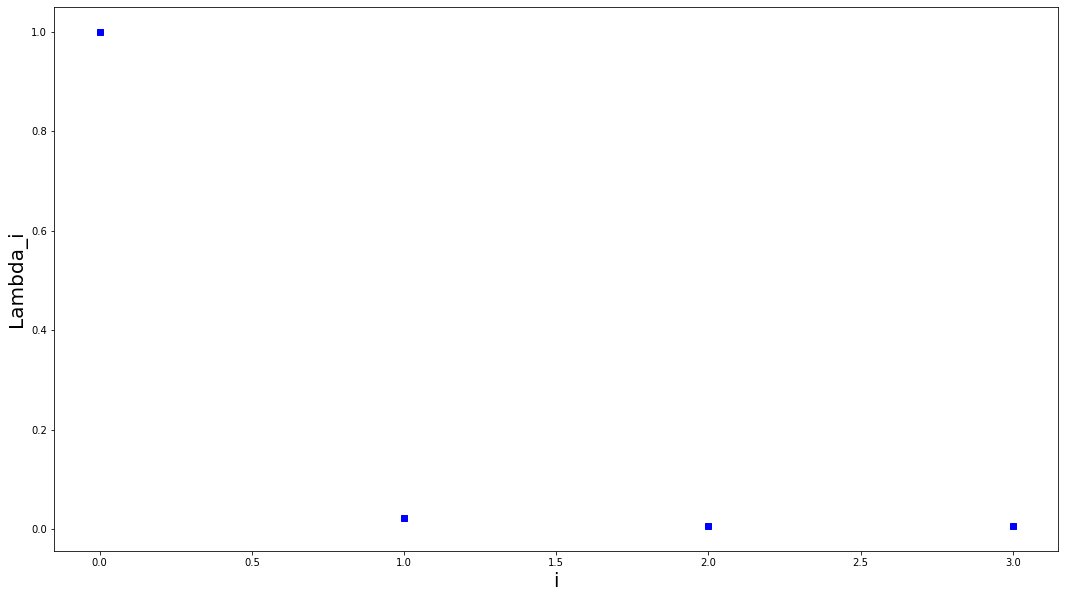

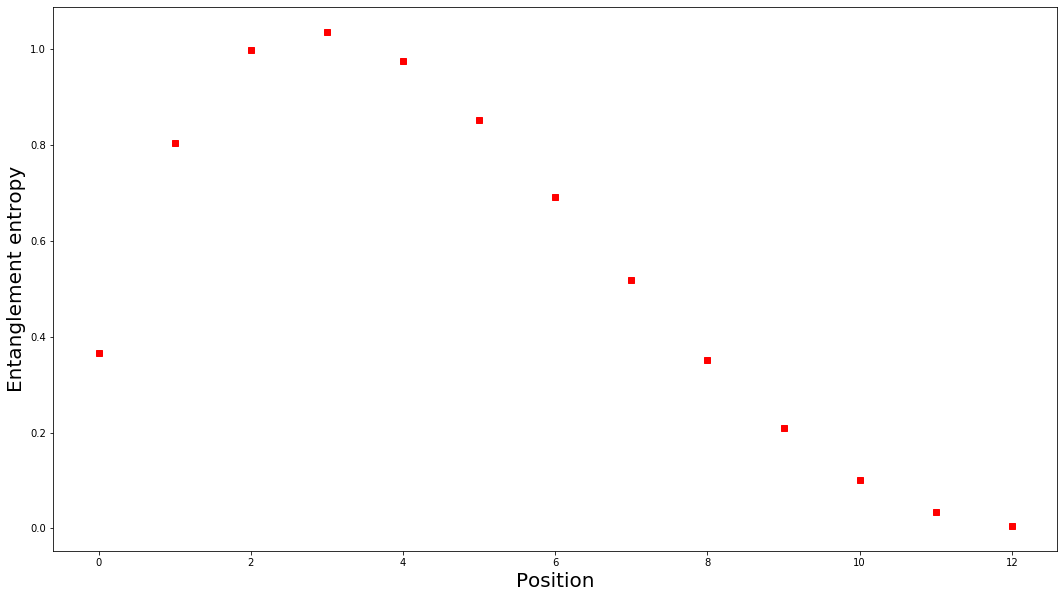

Sweep: 1 of 50, Energy: 0.006114, Bond dim: 64
Sweep: 2 of 50, Energy: 0.006001, Bond dim: 64
Sweep: 3 of 50, Energy: 0.005943, Bond dim: 64
Sweep: 4 of 50, Energy: 0.005907, Bond dim: 64
Sweep: 5 of 50, Energy: 0.005880, Bond dim: 64
Sweep: 6 of 50, Energy: 0.005859, Bond dim: 64
Sweep: 7 of 50, Energy: 0.005841, Bond dim: 64
Sweep: 8 of 50, Energy: 0.005826, Bond dim: 64
Sweep: 9 of 50, Energy: 0.005812, Bond dim: 64
Sweep: 10 of 50, Energy: 0.005800, Bond dim: 64
Sweep: 11 of 50, Energy: 0.005788, Bond dim: 64
Sweep: 12 of 50, Energy: 0.005778, Bond dim: 64
Sweep: 13 of 50, Energy: 0.005768, Bond dim: 64
Sweep: 14 of 50, Energy: 0.005759, Bond dim: 64
Sweep: 15 of 50, Energy: 0.005750, Bond dim: 64
Sweep: 16 of 50, Energy: 0.005742, Bond dim: 64
Sweep: 17 of 50, Energy: 0.005734, Bond dim: 64
Sweep: 18 of 50, Energy: 0.005727, Bond dim: 64
Sweep: 19 of 50, Energy: 0.005720, Bond dim: 64
Sweep: 20 of 50, Energy: 0.005713, Bond dim: 64
Sweep: 21 of 50, Energy: 0.005707, Bond dim: 64
S

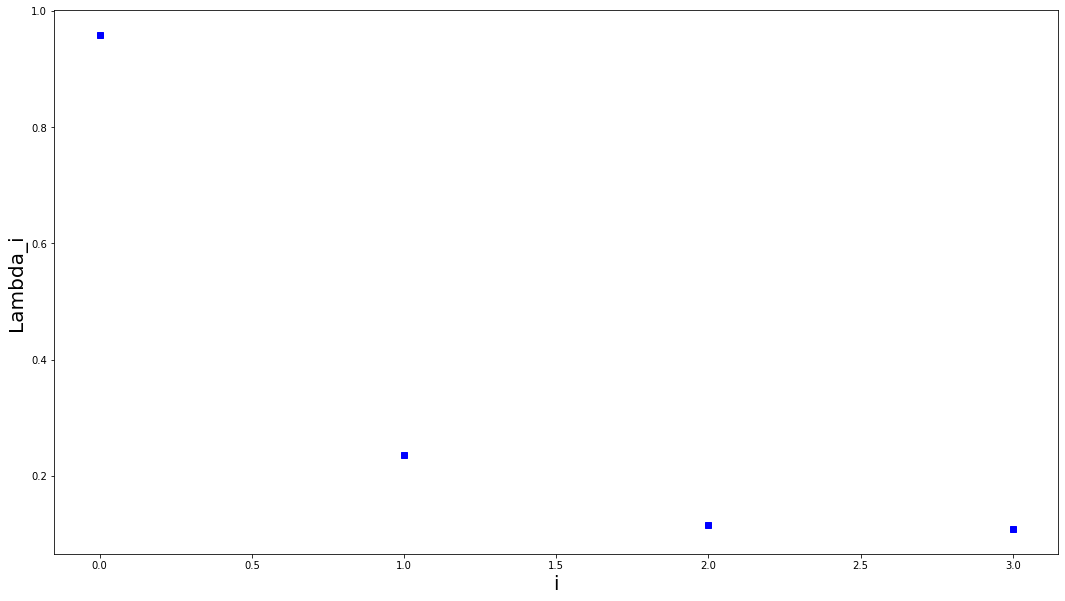

Position =  1 :  0.8313664090261419

Lambda_i = 0.8708230107275499
Lambda_i = 0.32224391188140833
Lambda_i = 0.31910584718315205
Lambda_i = 0.16952864449551505
Lambda_i = 0.03855487380817731
Lambda_i = 0.034957164815029286
Lambda_i = 0.030232190858535884
Lambda_i = 0.03007162702734742
Lambda_i = 0.02899975625005537
Lambda_i = 0.021794432759520425
Lambda_i = 0.02081952254465622
Lambda_i = 0.020615144931735434
Lambda_i = 0.013540456003679549
Lambda_i = 0.012494383889299372
Lambda_i = 0.012374886020150926
Lambda_i = 0.007991319438743809


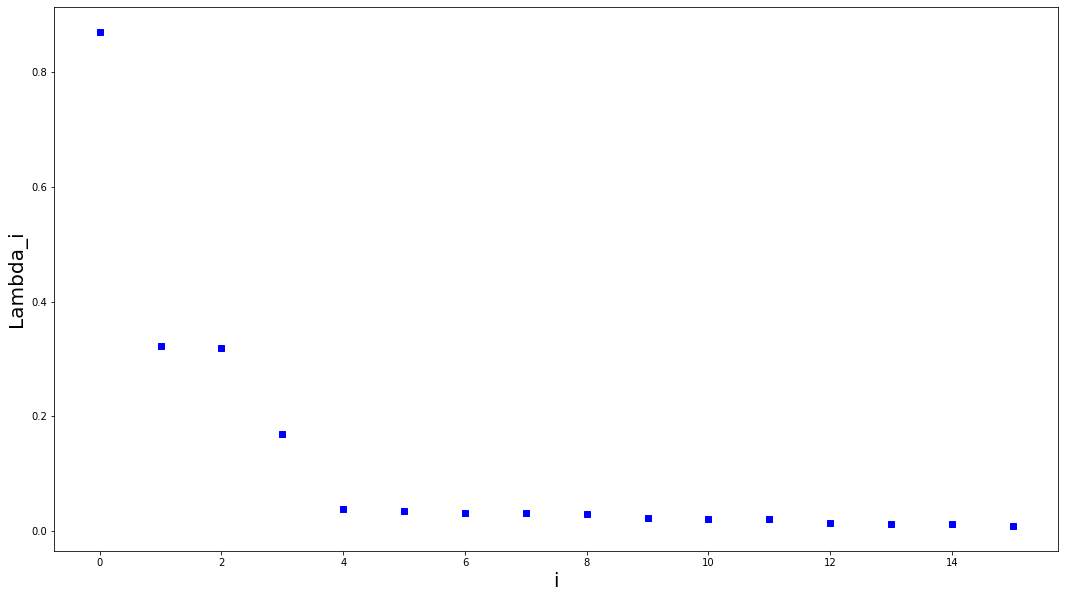

Position =  2 :  1.0673396513813735

Lambda_i = 0.7742896276532181
Lambda_i = 0.5031166562242485
Lambda_i = 0.32841231273594984
Lambda_i = 0.17527424233134226
Lambda_i = 0.03859225943752228
Lambda_i = 0.03162124449061474
Lambda_i = 0.03118787675820386
Lambda_i = 0.02870659157875929
Lambda_i = 0.02856653312111074
Lambda_i = 0.026323697055418326
Lambda_i = 0.02257616086850926
Lambda_i = 0.0206941381790716
Lambda_i = 0.01714927250436061
Lambda_i = 0.015452137499813326
Lambda_i = 0.014324223263422687
Lambda_i = 0.013931324939737184
Lambda_i = 0.012879218754736627
Lambda_i = 0.011631572713984632
Lambda_i = 0.011023844448926989
Lambda_i = 0.010292140993597654
Lambda_i = 0.009658955199476679
Lambda_i = 0.0087660929678119
Lambda_i = 0.008345893602636097
Lambda_i = 0.006700485029786029
Lambda_i = 0.006621005398120704
Lambda_i = 0.0062702120114219145
Lambda_i = 0.0057765993741471025
Lambda_i = 0.004979051479668927
Lambda_i = 0.004719682140947156
Lambda_i = 0.004468383494441044
Lambda_i = 0.00425

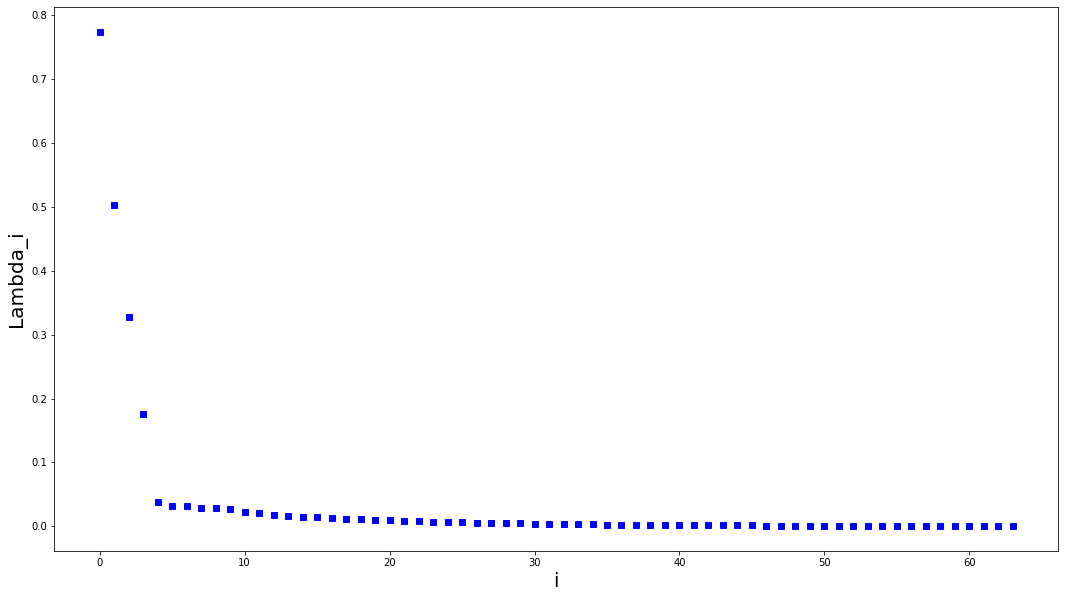

Position =  3 :  1.1102418620508117

Lambda_i = 0.6963029695295515
Lambda_i = 0.6177063593993711
Lambda_i = 0.31200234277332445
Lambda_i = 0.1660021310782107
Lambda_i = 0.03884864664623619
Lambda_i = 0.03065476257780897
Lambda_i = 0.029616245842832296
Lambda_i = 0.028958062064146087
Lambda_i = 0.027473356496000488
Lambda_i = 0.024888021369491548
Lambda_i = 0.02077597771810732
Lambda_i = 0.020172619574767837
Lambda_i = 0.018662955401412343
Lambda_i = 0.016422829246827423
Lambda_i = 0.01546400573508815
Lambda_i = 0.014358273519048684
Lambda_i = 0.013482069257867258
Lambda_i = 0.01177888713425982
Lambda_i = 0.010442524466696449
Lambda_i = 0.010151383462969132
Lambda_i = 0.009911675320110582
Lambda_i = 0.009351615103834787
Lambda_i = 0.007736701273587511
Lambda_i = 0.007512913165203984
Lambda_i = 0.00747768953122658
Lambda_i = 0.006913962116942348
Lambda_i = 0.006206518560261127
Lambda_i = 0.006156231265131228
Lambda_i = 0.0053959082344481185
Lambda_i = 0.0051992333168798645
Lambda_i = 0.0

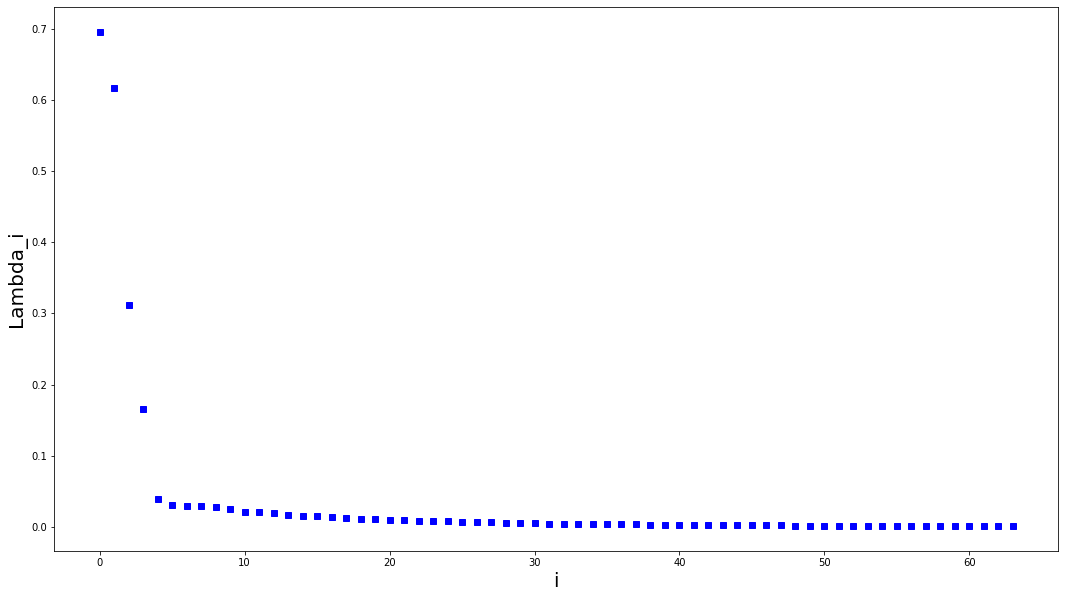

Position =  4 :  1.036518039377922

Lambda_i = 0.7568577092875297
Lambda_i = 0.5594154925452746
Lambda_i = 0.28838129460883966
Lambda_i = 0.1526288408250845
Lambda_i = 0.03824098727291537
Lambda_i = 0.030466611376602417
Lambda_i = 0.02804302202428043
Lambda_i = 0.026810787314457553
Lambda_i = 0.02538483648576387
Lambda_i = 0.022561914757249033
Lambda_i = 0.018703449512659055
Lambda_i = 0.018419264726628366
Lambda_i = 0.01808814250134928
Lambda_i = 0.015205941094203696
Lambda_i = 0.01471604790589124
Lambda_i = 0.013576355350703341
Lambda_i = 0.012604216811425425
Lambda_i = 0.010950722542983548
Lambda_i = 0.00974404855129952
Lambda_i = 0.00928137907195575
Lambda_i = 0.008072268493598371
Lambda_i = 0.008006424081081672
Lambda_i = 0.007204977916024148
Lambda_i = 0.00711264702908458
Lambda_i = 0.00680488268998582
Lambda_i = 0.006442464440055646
Lambda_i = 0.005730012896185183
Lambda_i = 0.005711331370834347
Lambda_i = 0.004884949325469228
Lambda_i = 0.004875574742718221
Lambda_i = 0.0046946

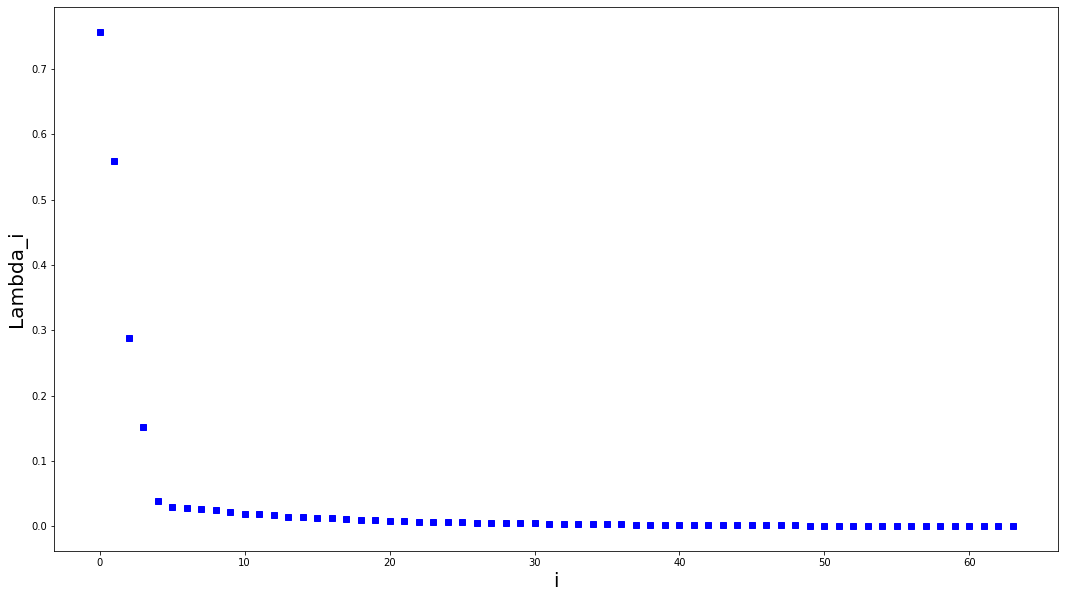

Position =  5 :  0.8924280866837737

Lambda_i = 0.8315756215977181
Lambda_i = 0.4643336576836803
Lambda_i = 0.26033141961638073
Lambda_i = 0.13683193345563088
Lambda_i = 0.03650388066516029
Lambda_i = 0.029311939593046853
Lambda_i = 0.025487045741433647
Lambda_i = 0.023725101238049835
Lambda_i = 0.022396807280504964
Lambda_i = 0.01924522522975797
Lambda_i = 0.016788996296731577
Lambda_i = 0.016448711160233487
Lambda_i = 0.015887036107008146
Lambda_i = 0.013614819610508202
Lambda_i = 0.013040422885125233
Lambda_i = 0.011976470703544677
Lambda_i = 0.01122376592016607
Lambda_i = 0.009652190030685785
Lambda_i = 0.008998310554566605
Lambda_i = 0.007820857541141809
Lambda_i = 0.007684297990224103
Lambda_i = 0.006812882114775974
Lambda_i = 0.006184015596451422
Lambda_i = 0.006070613918370767
Lambda_i = 0.005998161759603119
Lambda_i = 0.00515269926258559
Lambda_i = 0.004336623735705879
Lambda_i = 0.0042363724868492054
Lambda_i = 0.00420398520862871
Lambda_i = 0.004152855941996303
Lambda_i = 0.

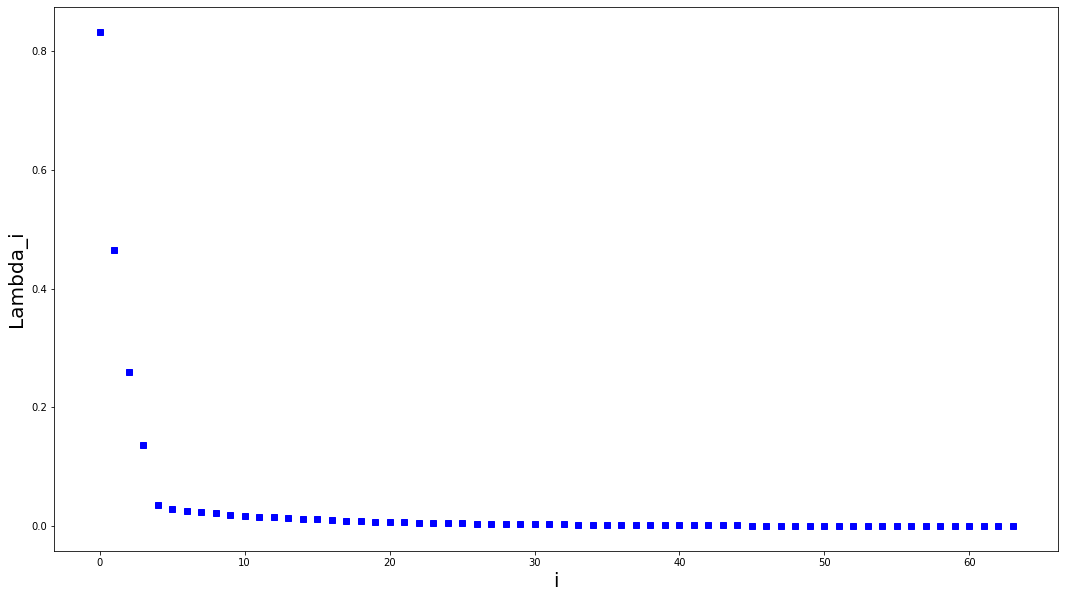

Position =  6 :  0.7116927797606599

Lambda_i = 0.8894147084215601
Lambda_i = 0.37091281839867296
Lambda_i = 0.22875341200420957
Lambda_i = 0.11913421221052842
Lambda_i = 0.03344738588961903
Lambda_i = 0.026655877703259234
Lambda_i = 0.022471595995902247
Lambda_i = 0.0204592498899051
Lambda_i = 0.01896893437250454
Lambda_i = 0.015760164154240912
Lambda_i = 0.014437703944737939
Lambda_i = 0.013969485443692534
Lambda_i = 0.013649243432801035
Lambda_i = 0.01174043661118705
Lambda_i = 0.010503207513274411
Lambda_i = 0.00995607885781168
Lambda_i = 0.009648977627790089
Lambda_i = 0.00805873386360001
Lambda_i = 0.007661113919335151
Lambda_i = 0.007024806890671764
Lambda_i = 0.006312124807138098
Lambda_i = 0.005887467517420631
Lambda_i = 0.005033900802664589
Lambda_i = 0.004763279231092125
Lambda_i = 0.004639261084705532
Lambda_i = 0.003897805790822985
Lambda_i = 0.0035262979653393214
Lambda_i = 0.0034419587750032904
Lambda_i = 0.003194015254668656
Lambda_i = 0.0030696956201571794
Lambda_i = 0

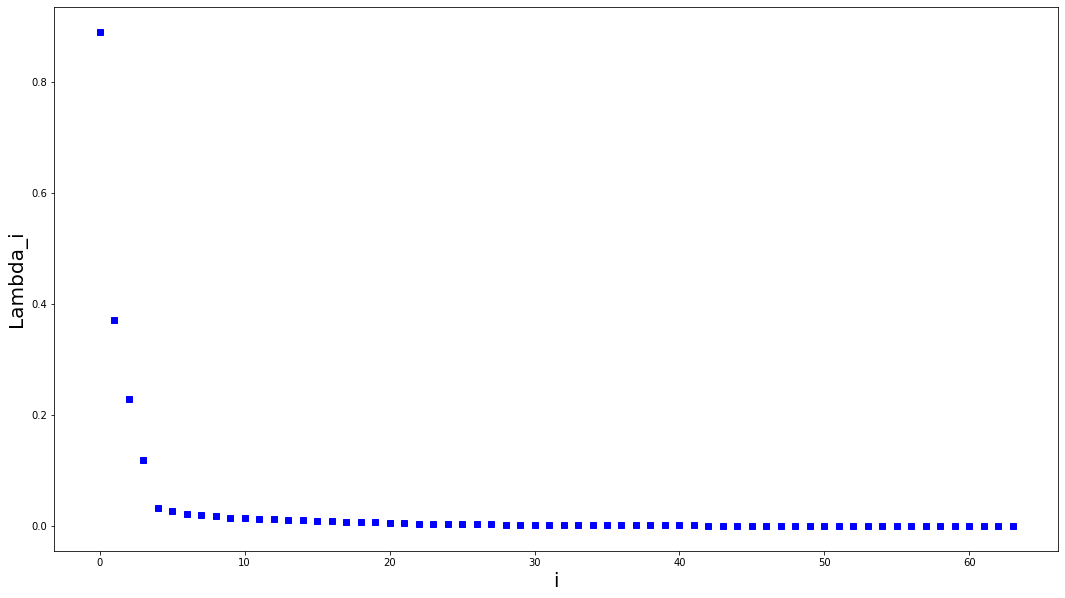

Position =  7 :  0.5218040456230366

Lambda_i = 0.932094215227013
Lambda_i = 0.28294946327023657
Lambda_i = 0.1943823082752074
Lambda_i = 0.10000159078518644
Lambda_i = 0.029267025677077278
Lambda_i = 0.02292677559384749
Lambda_i = 0.01907636467520756
Lambda_i = 0.017366327398047277
Lambda_i = 0.01530967899563337
Lambda_i = 0.012356464975722263
Lambda_i = 0.011562489322308038
Lambda_i = 0.01115096969203131
Lambda_i = 0.011016133648089838
Lambda_i = 0.009473688436209526
Lambda_i = 0.008065008953068508
Lambda_i = 0.007778456292212479
Lambda_i = 0.007615783852491228
Lambda_i = 0.0063390361690528665
Lambda_i = 0.006255975866100736
Lambda_i = 0.0057823488409646994
Lambda_i = 0.004803531687877314
Lambda_i = 0.0044190359879664135
Lambda_i = 0.003875713301399366
Lambda_i = 0.003477288017437798
Lambda_i = 0.0034585030464881874
Lambda_i = 0.0028594428611141403
Lambda_i = 0.0026570043491516413
Lambda_i = 0.0026319397613245236
Lambda_i = 0.0024912682209750387
Lambda_i = 0.0023870692220695324
Lambd

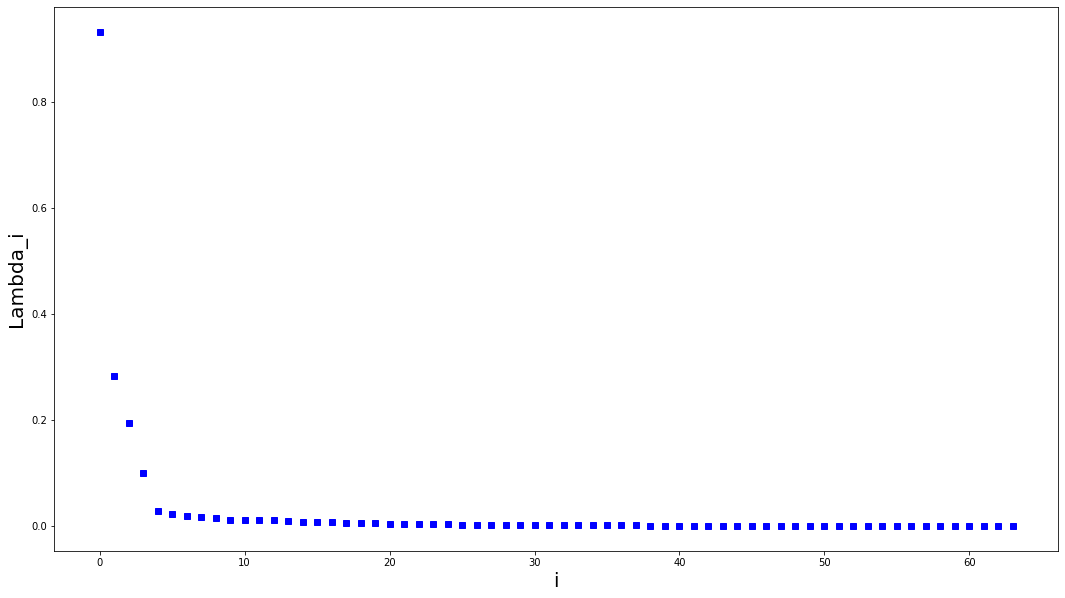

Position =  8 :  0.34524171450265856

Lambda_i = 0.9619784972668991
Lambda_i = 0.20291337592812206
Lambda_i = 0.15800989852943648
Lambda_i = 0.07995198048648694
Lambda_i = 0.024337658691508102
Lambda_i = 0.01845447187236075
Lambda_i = 0.015208634896908312
Lambda_i = 0.014187001423233061
Lambda_i = 0.011595065092000189
Lambda_i = 0.009078731189303298
Lambda_i = 0.008546280777075197
Lambda_i = 0.008305010075122467
Lambda_i = 0.008154309704401359
Lambda_i = 0.006964566548280838
Lambda_i = 0.005909624796606208
Lambda_i = 0.00561356815899903
Lambda_i = 0.005313201139018439
Lambda_i = 0.0046975618140099274
Lambda_i = 0.004482551089900533
Lambda_i = 0.004295668757073269
Lambda_i = 0.003255824049425171
Lambda_i = 0.0029730233794203267
Lambda_i = 0.002720003974618803
Lambda_i = 0.0024107464440515525
Lambda_i = 0.0022707046513429003
Lambda_i = 0.0019101664525637762
Lambda_i = 0.0018643914794502763
Lambda_i = 0.0018291150323449072
Lambda_i = 0.001653861609939347
Lambda_i = 0.0015296107081430737
L

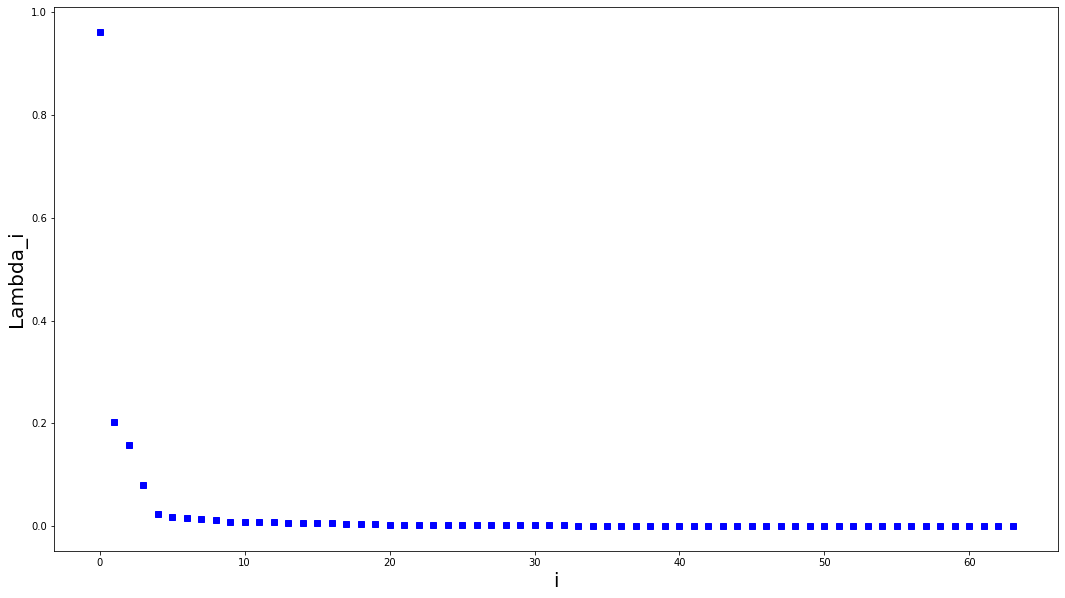

Position =  9 :  0.199013373584137

Lambda_i = 0.9813690197923075
Lambda_i = 0.13337752073741935
Lambda_i = 0.12039673850578739
Lambda_i = 0.0596798636031946
Lambda_i = 0.018928706831681106
Lambda_i = 0.013600036012867345
Lambda_i = 0.01098716683021136
Lambda_i = 0.010736014644615436
Lambda_i = 0.007937774884557504
Lambda_i = 0.006084230376395838
Lambda_i = 0.005854631338814373
Lambda_i = 0.005376846037772063
Lambda_i = 0.005177763041787151
Lambda_i = 0.004227275100739622
Lambda_i = 0.003913171331627873
Lambda_i = 0.0036520362732195303
Lambda_i = 0.0030159910938651266
Lambda_i = 0.0029051836948883365
Lambda_i = 0.0027473885797991413
Lambda_i = 0.002579942542322002
Lambda_i = 0.0018076678028553566
Lambda_i = 0.0016067495877055099
Lambda_i = 0.0015392734591674223
Lambda_i = 0.0014047127971182957
Lambda_i = 0.0011599542399814368
Lambda_i = 0.0011250416816122738
Lambda_i = 0.0010583555057988466
Lambda_i = 0.0009877847004024405
Lambda_i = 0.0008391125697482206
Lambda_i = 0.00081840467536120

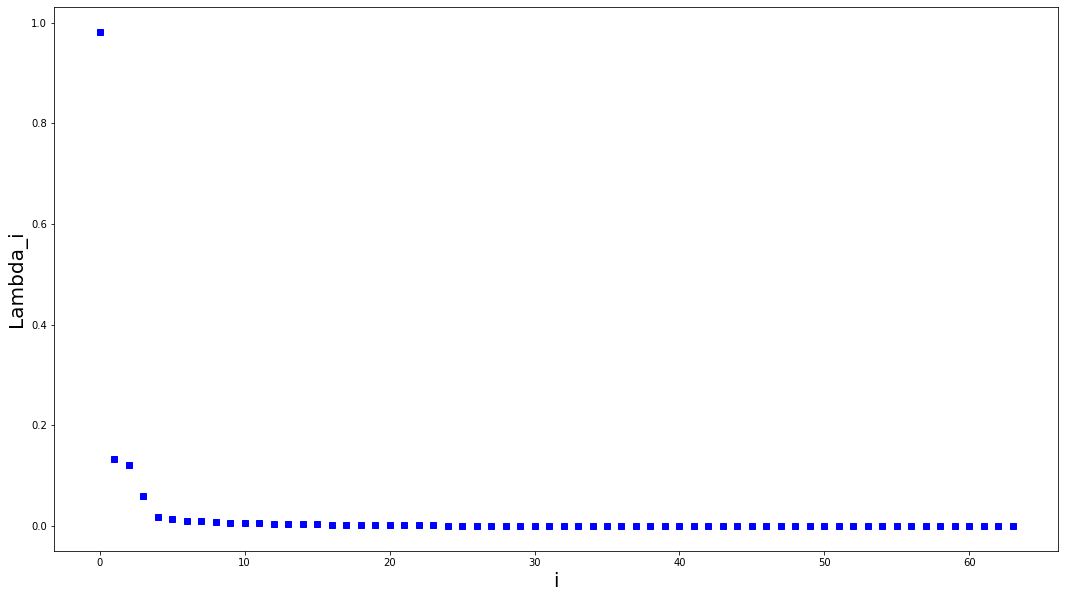

Position =  10 :  0.09335952718945313

Lambda_i = 0.9925830093304079
Lambda_i = 0.08522852228862107
Lambda_i = 0.07416005065052066
Lambda_i = 0.040035510772898485
Lambda_i = 0.013207239166560041
Lambda_i = 0.008614427184488602
Lambda_i = 0.00710282019542587
Lambda_i = 0.006520388436493634
Lambda_i = 0.00422793593838922
Lambda_i = 0.003341331252050409
Lambda_i = 0.00318320971784364
Lambda_i = 0.002636354528787182
Lambda_i = 0.0024788037095295743
Lambda_i = 0.0019228983994489105
Lambda_i = 0.0017879572356687909
Lambda_i = 0.0016429834113309612
Lambda_i = 0.0013792644755036977
Lambda_i = 0.0013541252122966356
Lambda_i = 0.0011639891971094195
Lambda_i = 0.0011083172969210144
Lambda_i = 0.00075716483843168
Lambda_i = 0.0005950917241087219
Lambda_i = 0.0005869568357366978
Lambda_i = 0.0004997888470397025
Lambda_i = 0.00044108517059437963
Lambda_i = 0.000393723537940306
Lambda_i = 0.00036560421924700765
Lambda_i = 0.00035762846236051026
Lambda_i = 0.0003068639514618463
Lambda_i = 0.0002645359

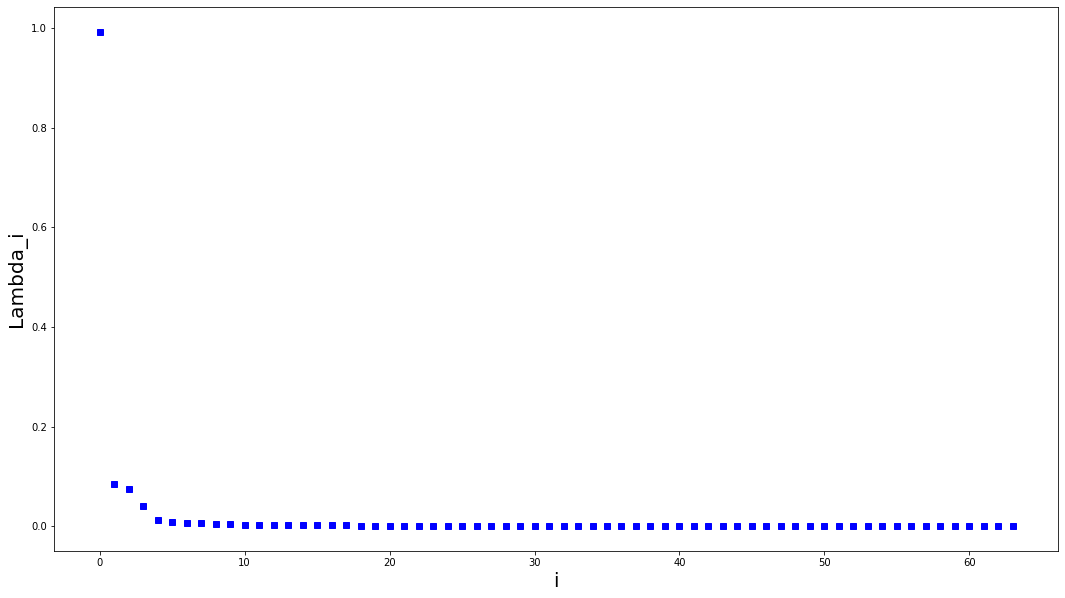

Position =  11 :  0.030456476630693795

Lambda_i = 0.9979676618084461
Lambda_i = 0.05025674944818701
Lambda_i = 0.031218691526424345
Lambda_i = 0.021845409081217196
Lambda_i = 0.006950351573661691
Lambda_i = 0.0036052751979033515
Lambda_i = 0.003305918082111799
Lambda_i = 0.0023621555705974277
Lambda_i = 0.0013777608744253934
Lambda_i = 0.001121323201140991
Lambda_i = 0.000759966988268836
Lambda_i = 0.0007538282483737678
Lambda_i = 0.0007103099108920905
Lambda_i = 0.0003943858163001635
Lambda_i = 0.00038005478988389175
Lambda_i = 0.00023734320563414865


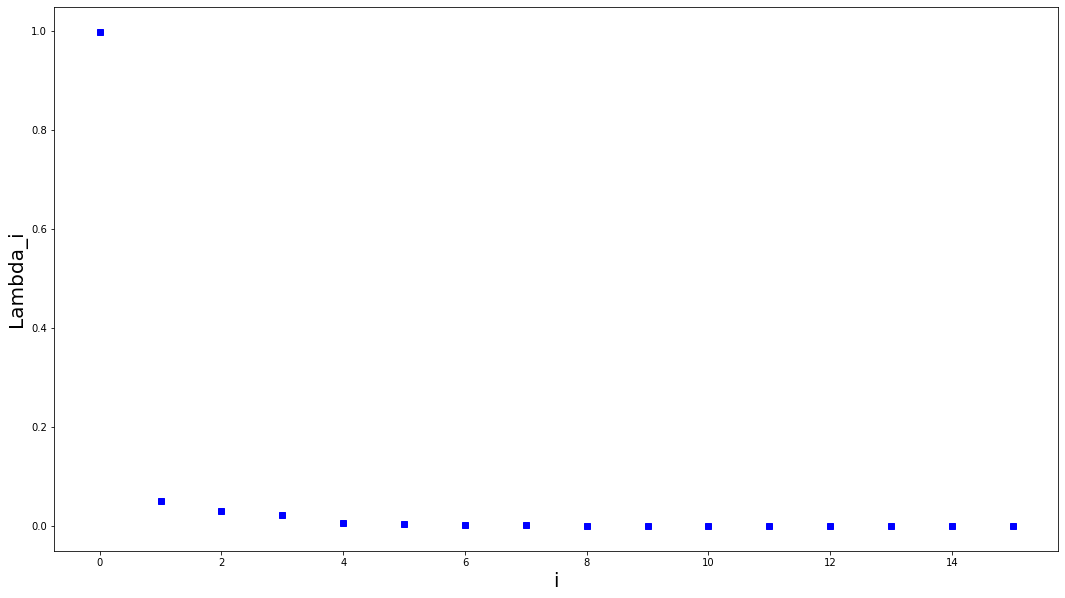

Position =  12 :  0.004275510338672203

Lambda_i = 0.9997679961299817
Lambda_i = 0.01979120344892402
Lambda_i = 0.006276357476839066
Lambda_i = 0.005733194319691298


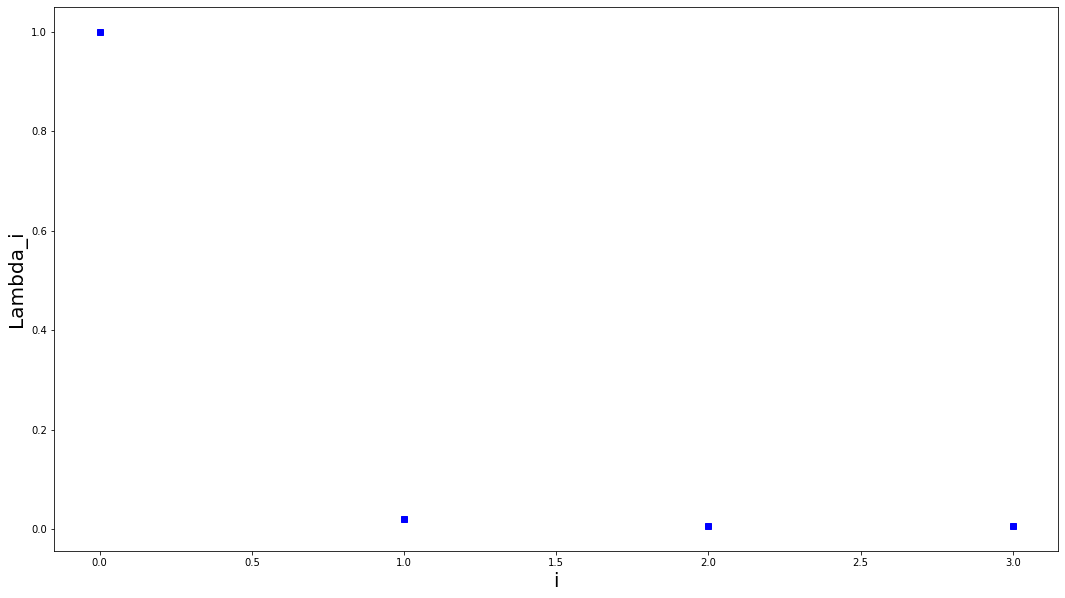

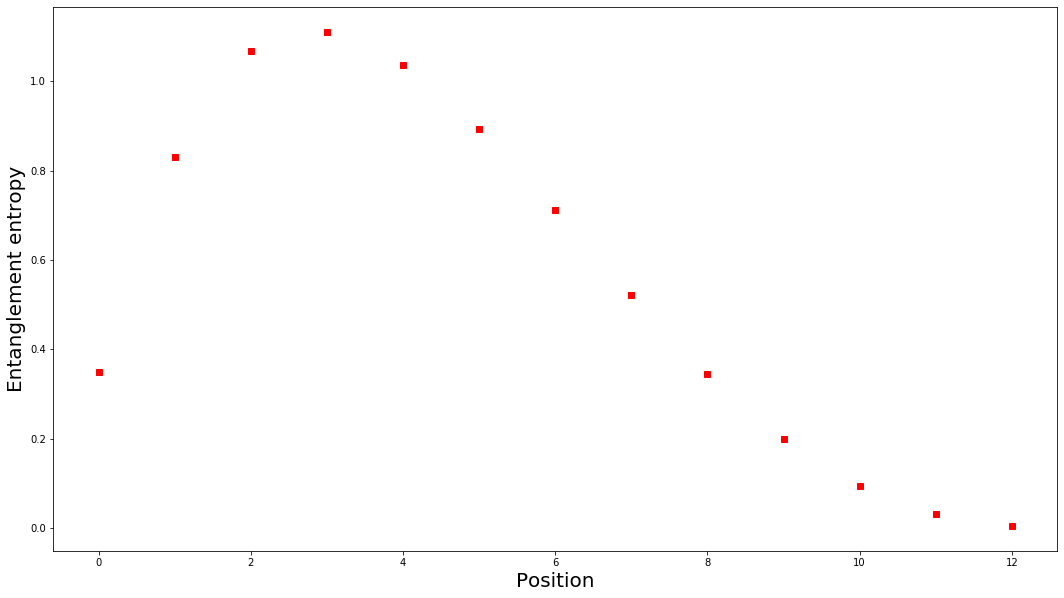

Sweep: 1 of 2, Energy: 0.018724, Bond dim: 4
Sweep: 2 of 2, Energy: 0.016492, Bond dim: 4
Minimal value of the functional:  0.016492265837589507
Entanglement entropy for different positions:

Position =  0 :  0.33420357156164965

Lambda_i = 0.9605073363637419
Lambda_i = 0.2333828556421507
Lambda_i = 0.12319092628761444
Lambda_i = 0.08821618425291408


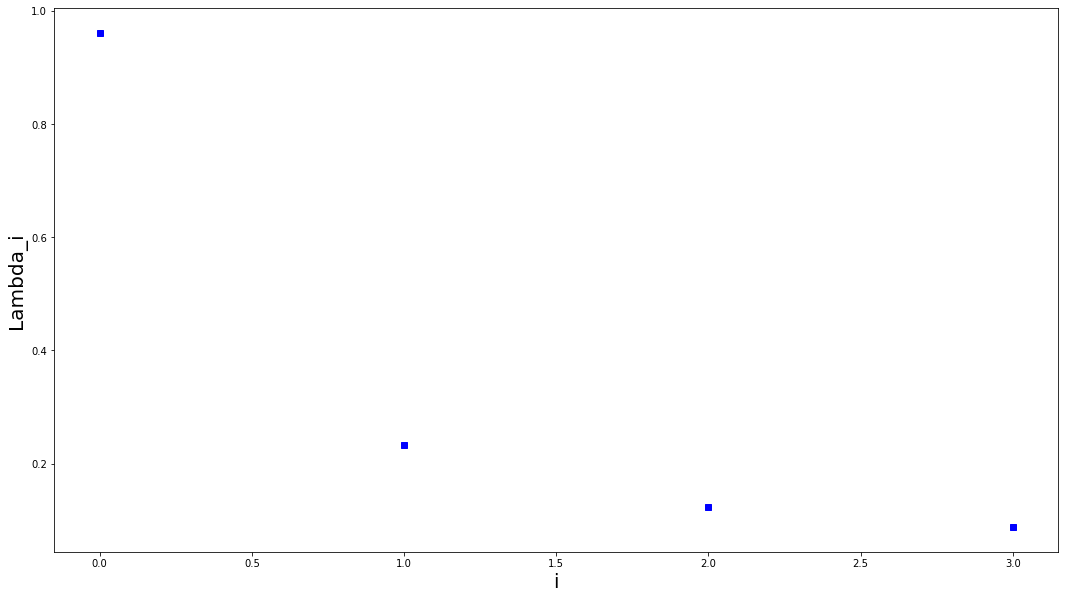

Position =  1 :  0.7774143755433307

Lambda_i = 0.8724647346153408
Lambda_i = 0.3354070819909717
Lambda_i = 0.31857069972910224
Lambda_i = 0.15754391602659448


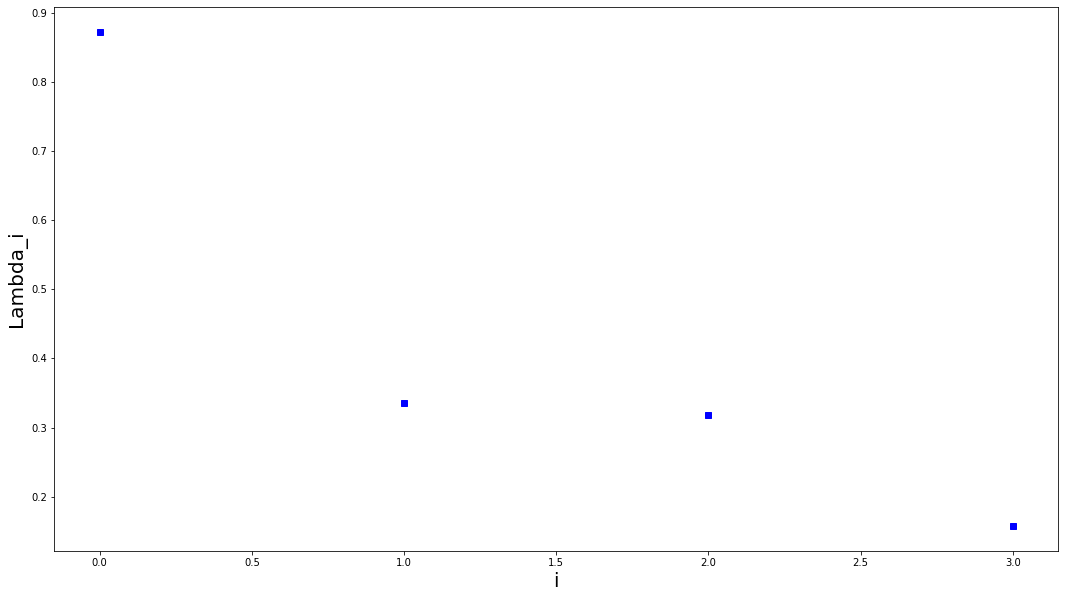

Position =  2 :  1.0019919812114528

Lambda_i = 0.7731799038830125
Lambda_i = 0.5147686241887917
Lambda_i = 0.32984598557894856
Lambda_i = 0.16854591534559993


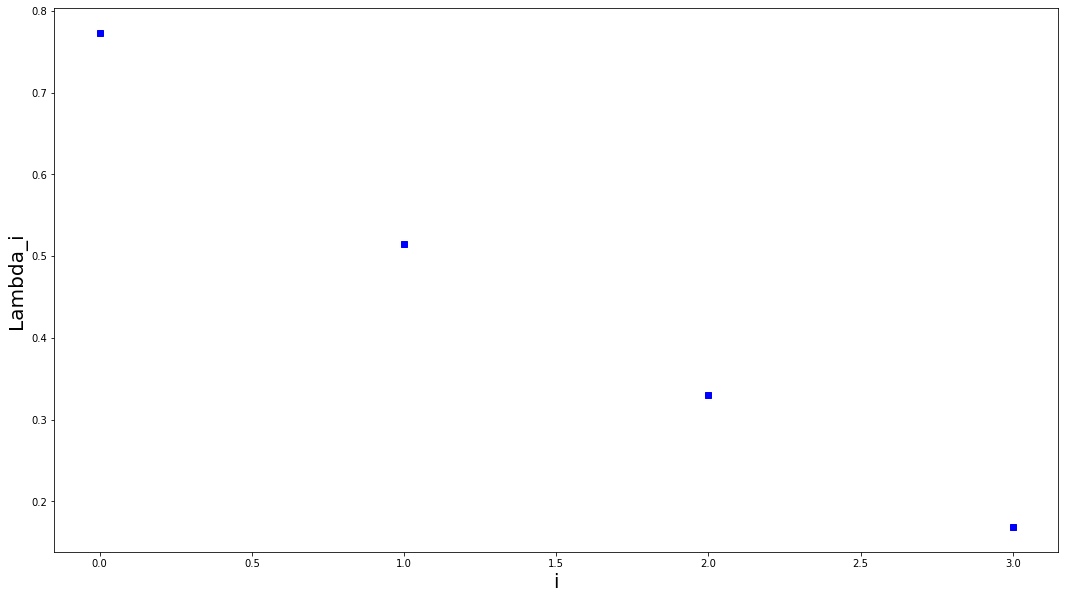

Position =  3 :  1.0334172816301679

Lambda_i = 0.7020522161779102
Lambda_i = 0.621138627506846
Lambda_i = 0.3107470732584451
Lambda_i = 0.15730781175741745


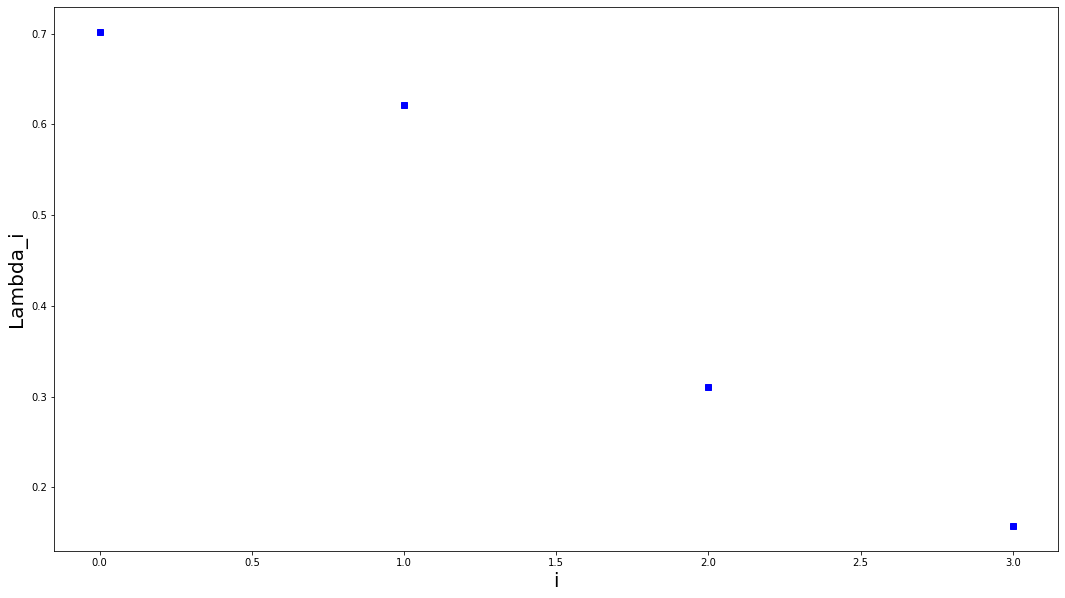

Position =  4 :  0.9551299684347399

Lambda_i = 0.7692510910485594
Lambda_i = 0.5542566073936765
Lambda_i = 0.2844674528561944
Lambda_i = 0.1418824878079095


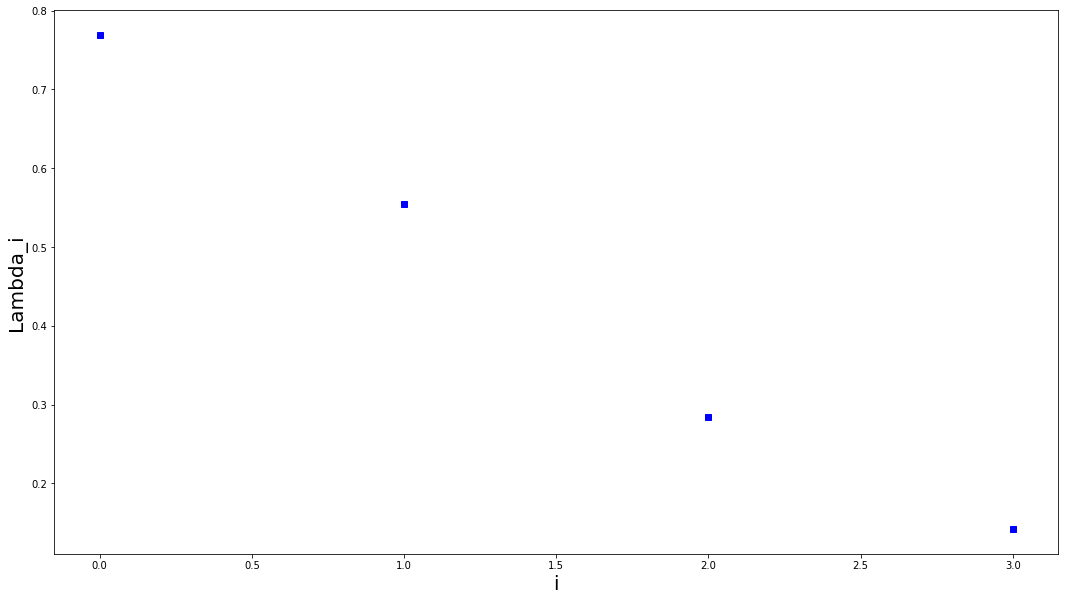

Position =  5 :  0.8153071112808973

Lambda_i = 0.8418495853715922
Lambda_i = 0.4586878566804351
Lambda_i = 0.2551807079129998
Lambda_i = 0.12560864640862607


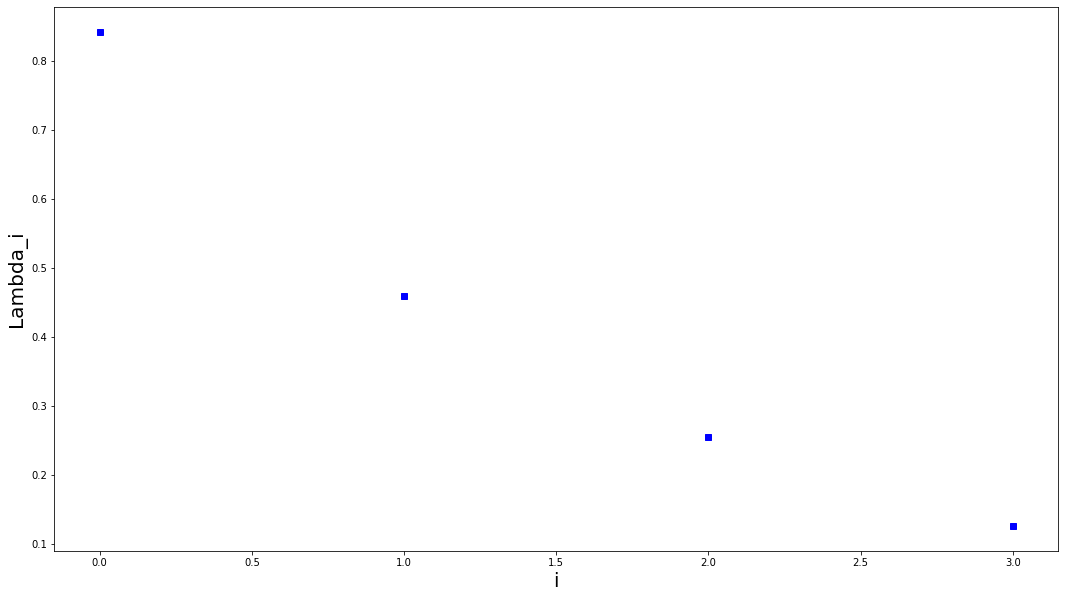

Position =  6 :  0.644354368640544

Lambda_i = 0.89734065993236
Lambda_i = 0.36524040397678503
Lambda_i = 0.22288657542241844
Lambda_i = 0.10817005977394235


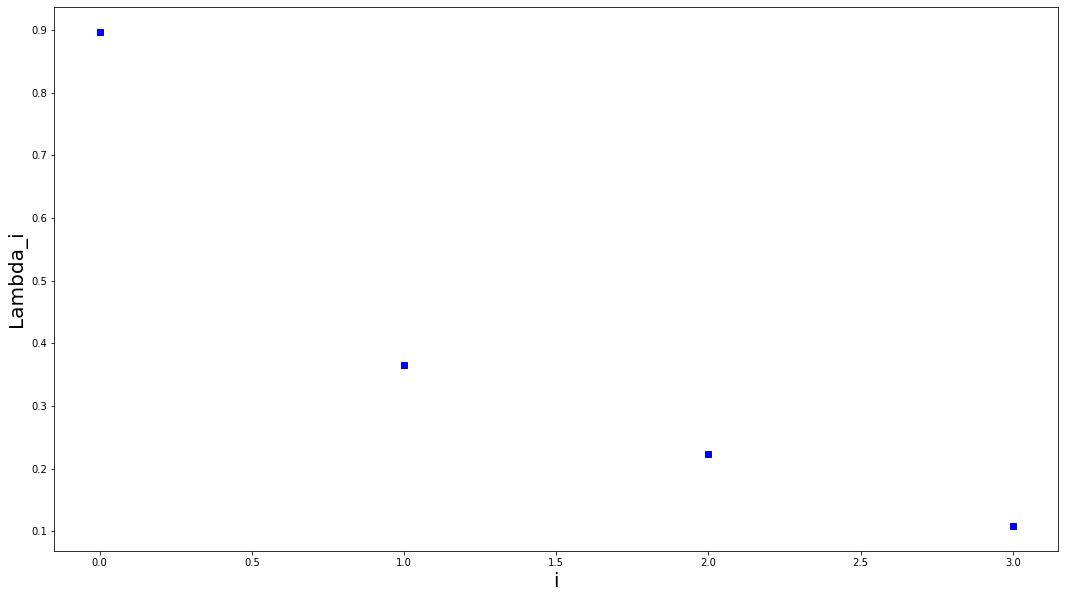

Position =  7 :  0.4677117922145884

Lambda_i = 0.9377704288553503
Lambda_i = 0.27775527804154426
Lambda_i = 0.1881411697789363
Lambda_i = 0.08967457007831352


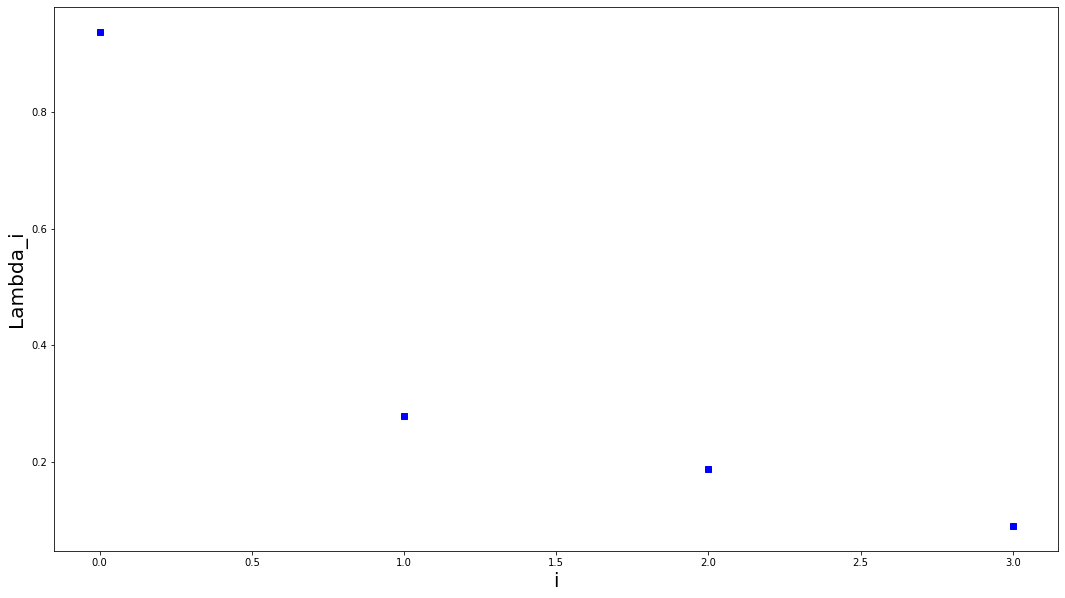

Position =  8 :  0.30607110374073027

Lambda_i = 0.9656613489560795
Lambda_i = 0.1985909019722847
Lambda_i = 0.15189794865701342
Lambda_i = 0.07061746228767206


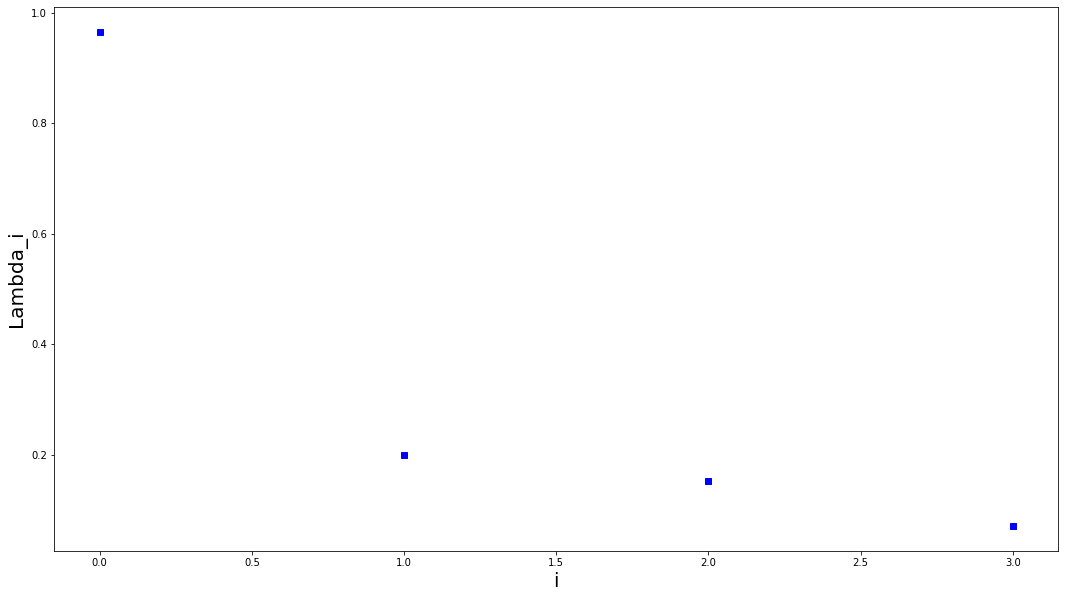

Position =  9 :  0.17417930887753683

Lambda_i = 0.9834711486835921
Lambda_i = 0.12993440773178763
Lambda_i = 0.11507930318284666
Lambda_i = 0.05155873711909414


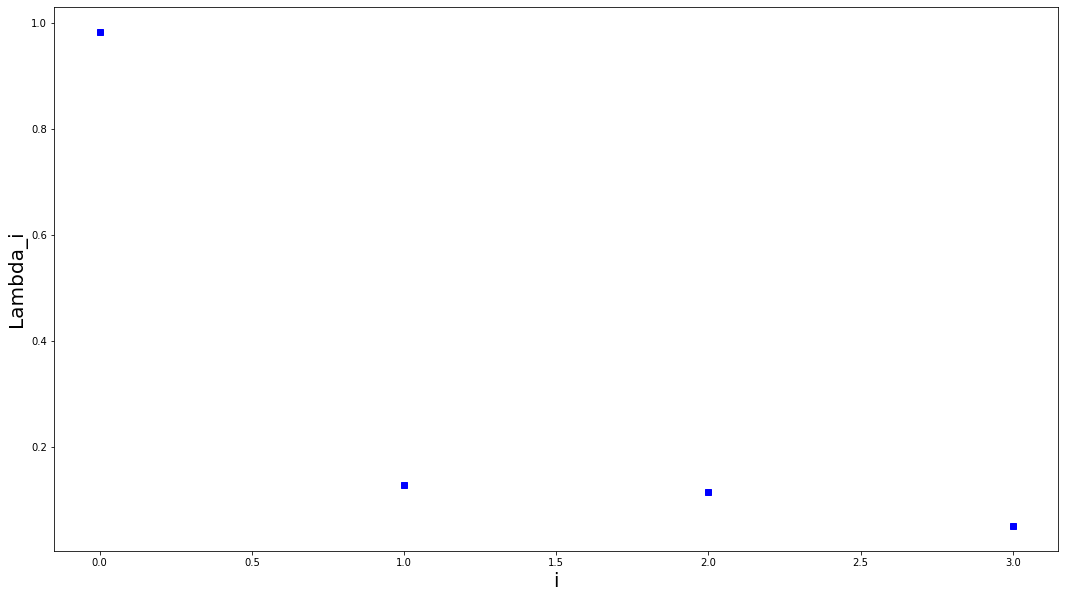

Position =  10 :  0.08022009991658621

Lambda_i = 0.993587979117965
Lambda_i = 0.08012445594221217
Lambda_i = 0.0725454004166191
Lambda_i = 0.03316872307815465


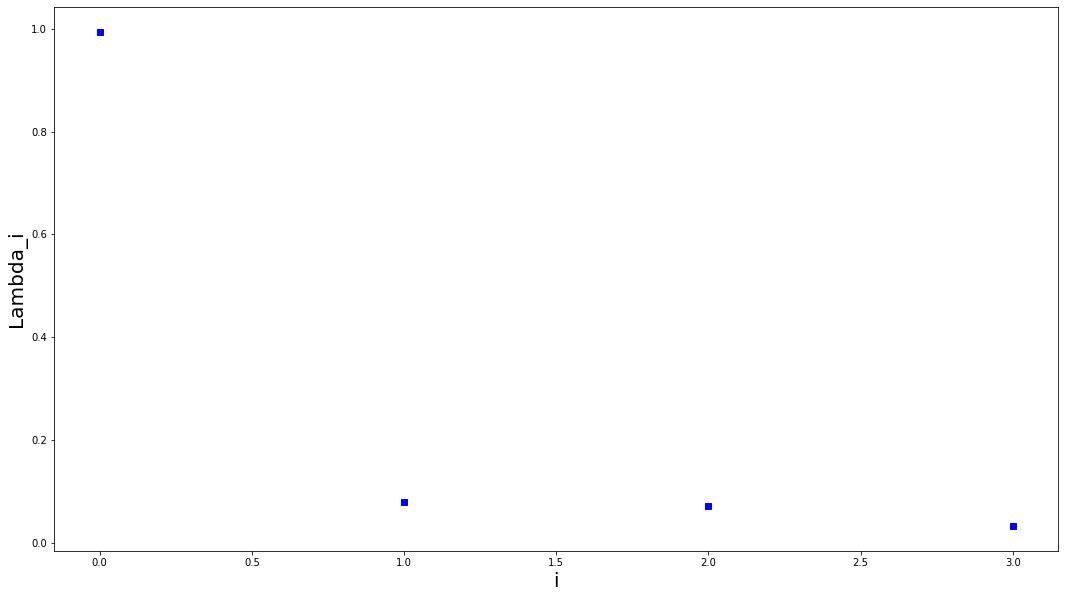

Position =  11 :  0.025385500366571973

Lambda_i = 0.9983158926578255
Lambda_i = 0.046121495285880755
Lambda_i = 0.031123621599968725
Lambda_i = 0.016416647584254263


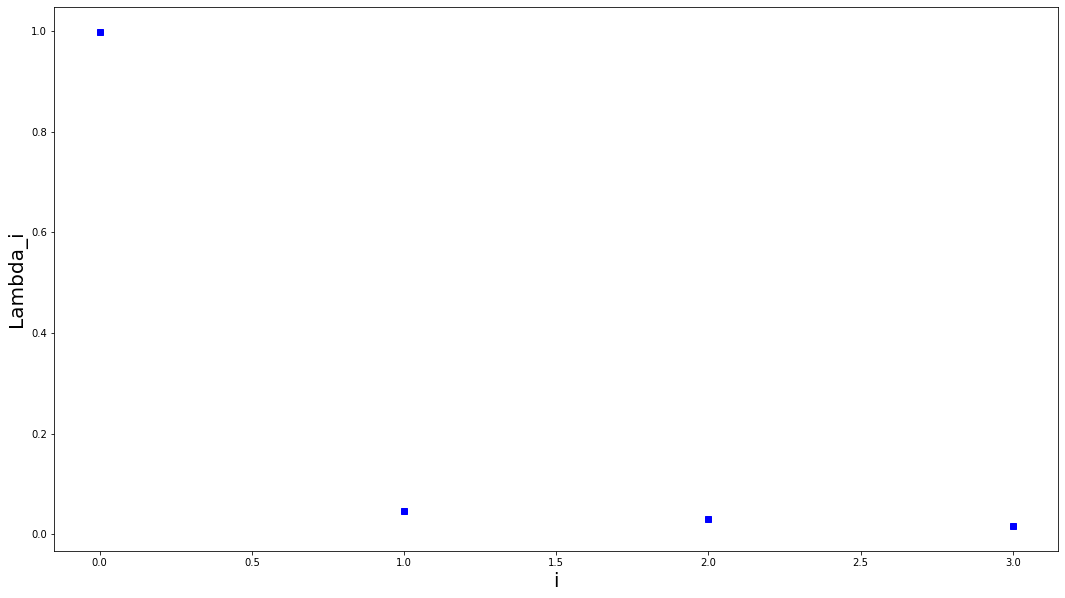

Position =  12 :  0.0034478632924084844

Lambda_i = 0.999816526016856
Lambda_i = 0.017759738677208835
Lambda_i = 0.006155589798689577
Lambda_i = 0.0036898102841734135


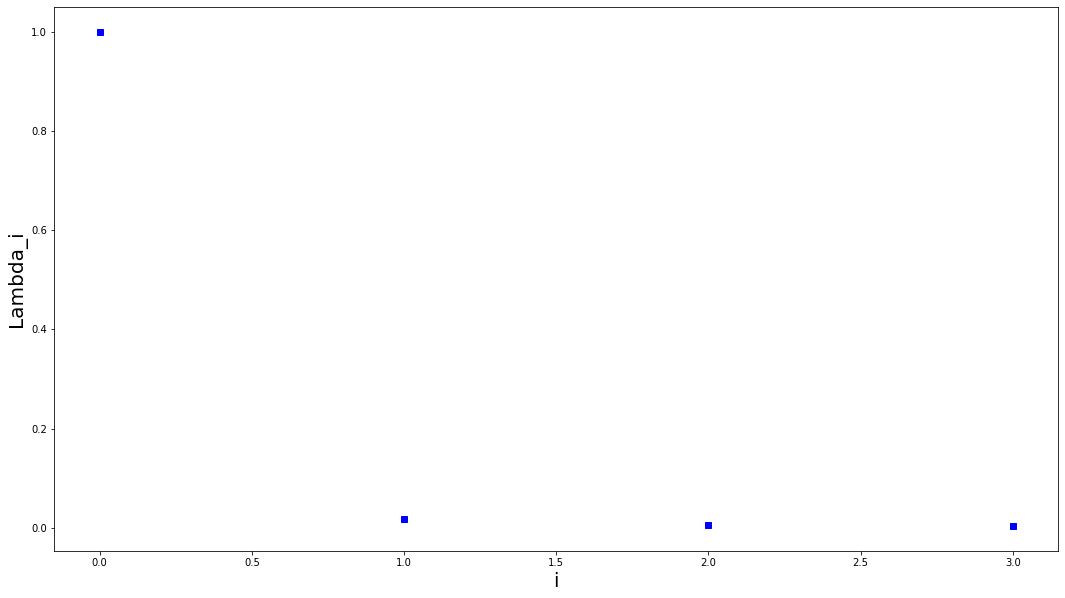

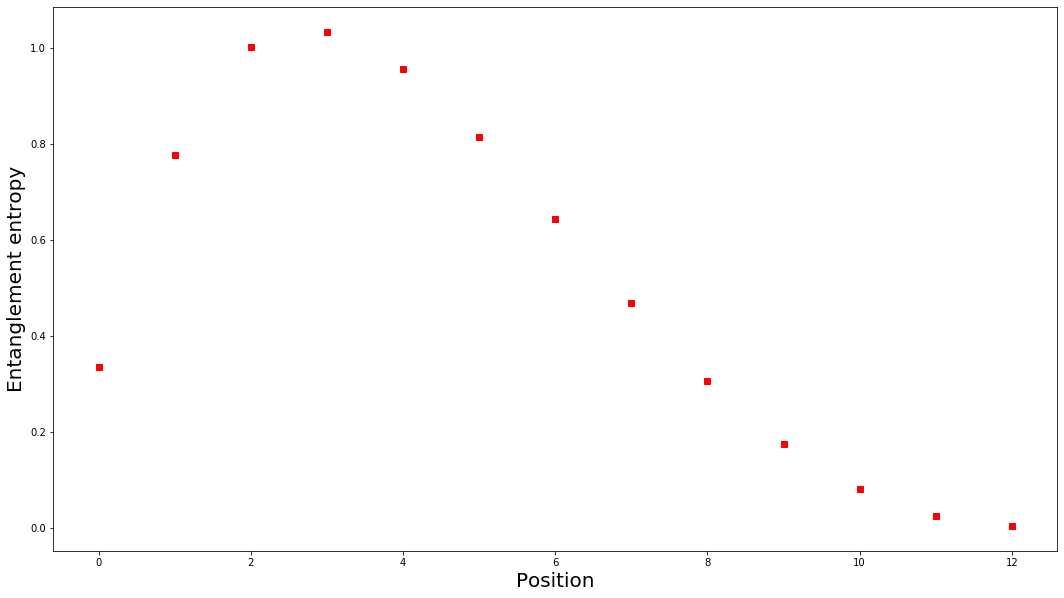

Mininimal value of the functional
0.016492265837589507

peak memory: 246.73 MiB, increment: 49.33 MiB
CPU times: user 42min 28s, sys: 1min 39s, total: 44min 8s
Wall time: 22min 21s


In [57]:
##### -ZZ+hZ+gX model #############
#######################################

##### Set bond dimensions and simulation options
chi = 16
chid = 4
N = 20
#print('The length of the Ising spin chain:',N)
print('H = - ZZ + hZ + gX')

OPTS_numsweeps = 50 # number of DMRG sweeps
OPTS_dispon = 1 # level of output display
OPTS_updateon = True # level of output display
OPTS_maxit = 2 # iterations of Lanczos method
OPTS_krydim = 4 # dimension of Krylov subspace

acc = 50

#printentrhdensmatr()

#printentrlocdensmatr()


h = 0.1
%time %memit CalculateEnergy()
#h = 0.1
#CalculateEnergy()
#h = 0.7
#CalculateEnergy()